In [10]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import cv2
import re

1.11.0+cu102 True
0.26.0


In [1]:
!nvidia-smi

Tue Jul 19 12:15:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:9E:00.0 Off |                  Off |
| 69%   85C    P2   256W / 260W |  12570MiB / 24211MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# convert dataset annotation to semantic segmentation map
data_root = 'data/Real'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
CLASSES = ('background', 'buisson', 'champs', 'eau', 'falaise','foret_dense','foret_claire','pierrier','prairie','route','verger','batiment')
PALETTE = [[0,0,0],[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8], [9,9,9], [10,10,10], [11,11,11]]

In [12]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class HugoDataset(CustomDataset):
    CLASSES = CLASSES
    PALETTE = PALETTE
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                         split=split,reduce_zero_label=False, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None    

In [13]:
from mmcv import Config
cfg = Config.fromfile('configs/unet/hugo_unet.py')

In [14]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 12
cfg.model.auxiliary_head.num_classes = 12

# Modify dataset type and path
cfg.dataset_type = 'HugoDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/unet/'

cfg.total_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [8]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)


2022-07-13 17:45:32,599 - mmseg - INFO - Loaded 219 images
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [9]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-13 17:45:37,509 - mmseg - INFO - Loaded 73 images
2022-07-13 17:45:37,511 - mmseg - INFO - Start running, host: hugo@hugobis, work_dir: /home/hugo/SwinTransfo/mmsegmentation/work_dirs/unet
2022-07-13 17:45:37,511 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) O

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.9 task/s, elapsed: 5s, ETA:     0s

2022-07-13 17:48:40,552 - mmseg - INFO - per class results:
2022-07-13 17:48:40,554 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 16.04 | 25.91 |
|   buisson    |  0.0  |  0.0  |
|    champs    | 59.05 | 76.92 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 44.99 | 89.15 |
| foret_claire | 34.57 | 58.67 |
|   pierrier   | 49.87 | 66.89 |
|   prairie    |  0.11 |  0.11 |
|    route     | 18.58 | 19.65 |
|    verger    | 26.48 | 34.46 |
|   batiment   |  0.01 |  0.01 |
+--------------+-------+-------+
2022-07-13 17:48:40,555 - mmseg - INFO - Summary:
2022-07-13 17:48:40,555 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 49.71 | 20.81 | 30.98 |
+-------+-------+-------+
2022-07-13 17:48:40,556 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4971, mIoU: 0.2081, mAcc: 0.3098, IoU.background: 0.1604, IoU.buisson: 0.0000, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 18.1 task/s, elapsed: 4s, ETA:     0s

2022-07-13 17:51:44,147 - mmseg - INFO - per class results:
2022-07-13 17:51:44,149 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  21.4 | 42.31 |
|   buisson    | 30.72 | 37.29 |
|    champs    | 35.67 | 39.54 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 57.87 | 89.72 |
| foret_claire | 30.52 | 51.44 |
|   pierrier   | 30.97 | 33.68 |
|   prairie    | 19.37 | 24.49 |
|    route     | 18.09 | 48.61 |
|    verger    | 40.47 | 54.97 |
|   batiment   |  5.41 |  5.43 |
+--------------+-------+-------+
2022-07-13 17:51:44,149 - mmseg - INFO - Summary:
2022-07-13 17:51:44,150 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 53.07 | 24.21 | 35.62 |
+-------+-------+-------+
2022-07-13 17:51:44,150 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5307, mIoU: 0.2421, mAcc: 0.3562, IoU.background: 0.2140, IoU.buisson: 0.3072, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 18.0 task/s, elapsed: 4s, ETA:     0s

2022-07-13 17:54:50,185 - mmseg - INFO - per class results:
2022-07-13 17:54:50,187 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.89 | 29.76 |
|   buisson    | 40.77 | 51.02 |
|    champs    | 61.55 | 75.64 |
|     eau      | 24.89 | 24.89 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 49.78 | 58.11 |
| foret_claire | 37.12 |  77.9 |
|   pierrier   | 52.47 | 66.13 |
|   prairie    | 24.77 | 38.84 |
|    route     | 33.91 | 56.49 |
|    verger    | 48.91 | 71.29 |
|   batiment   |  4.08 |  4.08 |
+--------------+-------+-------+
2022-07-13 17:54:50,187 - mmseg - INFO - Summary:
2022-07-13 17:54:50,188 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 57.2 | 33.1 | 46.18 |
+------+------+-------+
2022-07-13 17:54:50,189 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5720, mIoU: 0.3310, mAcc: 0.4618, IoU.background: 0.1889, IoU.buisson: 0.4077, IoU.champs: 0.6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.9 task/s, elapsed: 4s, ETA:     0s

2022-07-13 17:57:53,810 - mmseg - INFO - per class results:
2022-07-13 17:57:53,812 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.22 | 30.44 |
|   buisson    | 25.36 | 29.03 |
|    champs    | 56.09 | 59.77 |
|     eau      | 10.74 | 10.74 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 48.67 | 80.41 |
| foret_claire | 30.48 | 55.58 |
|   pierrier   | 37.72 | 43.44 |
|   prairie    | 20.92 |  37.2 |
|    route     |  21.8 | 36.11 |
|    verger    |  50.0 | 52.87 |
|   batiment   |  4.18 |  4.18 |
+--------------+-------+-------+
2022-07-13 17:57:53,812 - mmseg - INFO - Summary:
2022-07-13 17:57:53,813 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 52.78 | 27.18 | 36.65 |
+-------+-------+-------+
2022-07-13 17:57:53,813 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5278, mIoU: 0.2718, mAcc: 0.3665, IoU.background: 0.2022, IoU.buisson: 0.2536, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:01:00,282 - mmseg - INFO - per class results:
2022-07-13 18:01:00,283 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 15.52 | 21.22 |
|   buisson    | 33.68 | 57.97 |
|    champs    | 63.83 | 81.52 |
|     eau      | 58.01 | 58.23 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 60.93 |  85.1 |
| foret_claire | 27.27 | 41.15 |
|   pierrier   | 49.64 | 88.26 |
|   prairie    | 21.36 | 25.54 |
|    route     |  37.8 | 59.91 |
|    verger    | 49.53 | 60.04 |
|   batiment   |  1.95 |  1.96 |
+--------------+-------+-------+
2022-07-13 18:01:00,284 - mmseg - INFO - Summary:
2022-07-13 18:01:00,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 59.28 | 34.96 | 48.41 |
+-------+-------+-------+
2022-07-13 18:01:00,285 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5928, mIoU: 0.3496, mAcc: 0.4841, IoU.background: 0.1552, IoU.buisson: 0.3368, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.9 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:04:04,952 - mmseg - INFO - per class results:
2022-07-13 18:04:04,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.05 | 35.71 |
|   buisson    | 23.69 | 33.35 |
|    champs    | 53.15 | 86.32 |
|     eau      | 32.56 | 32.67 |
|   falaise    |  0.04 |  0.04 |
| foret_dense  | 59.01 | 71.02 |
| foret_claire |  39.5 | 62.41 |
|   pierrier   | 57.74 | 78.04 |
|   prairie    |  21.3 | 38.54 |
|    route     | 26.64 | 32.61 |
|    verger    | 52.97 | 56.78 |
|   batiment   | 19.58 | 23.24 |
+--------------+-------+-------+
2022-07-13 18:04:04,954 - mmseg - INFO - Summary:
2022-07-13 18:04:04,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 57.51 | 33.93 | 45.89 |
+-------+-------+-------+
2022-07-13 18:04:04,955 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5751, mIoU: 0.3393, mAcc: 0.4589, IoU.background: 0.2105, IoU.buisson: 0.2369, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:07:09,600 - mmseg - INFO - per class results:
2022-07-13 18:07:09,602 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 17.74 | 24.08 |
|   buisson    | 42.93 | 54.54 |
|    champs    | 70.24 | 80.13 |
|     eau      | 51.58 |  51.8 |
|   falaise    |  0.01 |  0.01 |
| foret_dense  | 59.02 | 87.06 |
| foret_claire | 39.29 | 71.01 |
|   pierrier   | 51.48 | 63.25 |
|   prairie    | 18.12 | 21.82 |
|    route     | 33.11 | 42.11 |
|    verger    | 60.66 | 63.48 |
|   batiment   | 16.26 | 17.15 |
+--------------+-------+-------+
2022-07-13 18:07:09,602 - mmseg - INFO - Summary:
2022-07-13 18:07:09,603 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.75 | 38.37 | 48.04 |
+-------+-------+-------+
2022-07-13 18:07:09,603 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6275, mIoU: 0.3837, mAcc: 0.4804, IoU.background: 0.1774, IoU.buisson: 0.4293, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 18.0 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:10:15,737 - mmseg - INFO - per class results:
2022-07-13 18:10:15,738 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 11.66 | 14.89 |
|   buisson    | 20.39 | 24.52 |
|    champs    | 59.38 | 80.74 |
|     eau      | 37.38 | 37.57 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 64.95 | 89.76 |
| foret_claire | 37.21 | 60.42 |
|   pierrier   | 53.33 | 70.95 |
|   prairie    | 23.82 | 45.73 |
|    route     | 28.98 | 34.09 |
|    verger    | 48.62 | 60.01 |
|   batiment   | 16.57 | 16.76 |
+--------------+-------+-------+
2022-07-13 18:10:15,739 - mmseg - INFO - Summary:
2022-07-13 18:10:15,739 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 59.46 | 33.52 | 44.62 |
+-------+-------+-------+
2022-07-13 18:10:15,740 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5946, mIoU: 0.3352, mAcc: 0.4462, IoU.background: 0.1166, IoU.buisson: 0.2039, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.9 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:13:20,540 - mmseg - INFO - per class results:
2022-07-13 18:13:20,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 19.19 | 27.46 |
|   buisson    | 45.82 | 62.91 |
|    champs    | 61.47 | 73.29 |
|     eau      | 68.82 | 69.49 |
|   falaise    |  3.89 |  4.14 |
| foret_dense  | 62.81 | 73.91 |
| foret_claire | 39.54 | 75.87 |
|   pierrier   | 22.18 | 26.19 |
|   prairie    |  36.7 | 56.32 |
|    route     | 37.94 | 54.74 |
|    verger    | 72.29 | 76.98 |
|   batiment   |  1.46 |  1.47 |
+--------------+-------+-------+
2022-07-13 18:13:20,542 - mmseg - INFO - Summary:
2022-07-13 18:13:20,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 63.48 | 39.34 | 50.23 |
+-------+-------+-------+
2022-07-13 18:13:20,543 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6348, mIoU: 0.3934, mAcc: 0.5023, IoU.background: 0.1919, IoU.buisson: 0.4582, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:16:27,149 - mmseg - INFO - per class results:
2022-07-13 18:16:27,151 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 14.34 | 19.23 |
|   buisson    | 41.81 | 61.51 |
|    champs    | 63.49 | 79.35 |
|     eau      |  50.7 | 51.21 |
|   falaise    |  1.19 |  1.33 |
| foret_dense  | 60.77 | 66.66 |
| foret_claire | 35.73 | 71.62 |
|   pierrier   | 28.62 | 31.79 |
|   prairie    | 39.02 | 61.85 |
|    route     | 36.13 | 49.32 |
|    verger    | 60.49 | 84.16 |
|   batiment   | 17.08 | 18.33 |
+--------------+-------+-------+
2022-07-13 18:16:27,151 - mmseg - INFO - Summary:
2022-07-13 18:16:27,152 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 61.33 | 37.45 | 49.7 |
+-------+-------+------+
2022-07-13 18:16:27,152 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6133, mIoU: 0.3745, mAcc: 0.4970, IoU.background: 0.1434, IoU.buisson: 0.4181, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:19:31,857 - mmseg - INFO - per class results:
2022-07-13 18:19:31,858 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.82 | 51.21 |
|   buisson    | 49.35 | 60.42 |
|    champs    | 66.81 | 77.64 |
|     eau      | 53.63 | 54.11 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 62.19 | 92.72 |
| foret_claire | 34.05 | 42.72 |
|   pierrier   | 45.34 | 55.11 |
|   prairie    | 30.01 | 37.76 |
|    route     | 41.75 | 46.45 |
|    verger    | 61.38 | 71.55 |
|   batiment   | 25.92 | 41.72 |
+--------------+-------+-------+
2022-07-13 18:19:31,859 - mmseg - INFO - Summary:
2022-07-13 18:19:31,859 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 64.77 | 41.44 | 52.62 |
+-------+-------+-------+
2022-07-13 18:19:31,860 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6477, mIoU: 0.4144, mAcc: 0.5262, IoU.background: 0.2682, IoU.buisson: 0.4935, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:22:36,177 - mmseg - INFO - per class results:
2022-07-13 18:22:36,178 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.73 | 28.73 |
|   buisson    | 52.55 | 69.48 |
|    champs    | 68.07 | 88.15 |
|     eau      | 42.58 | 42.81 |
|   falaise    |  0.44 |  0.47 |
| foret_dense  | 68.83 | 85.44 |
| foret_claire | 44.37 | 67.94 |
|   pierrier   | 55.98 | 78.42 |
|   prairie    | 40.88 | 52.72 |
|    route     | 44.87 | 56.09 |
|    verger    | 72.18 | 77.87 |
|   batiment   | 22.91 | 25.08 |
+--------------+-------+-------+
2022-07-13 18:22:36,178 - mmseg - INFO - Summary:
2022-07-13 18:22:36,179 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 69.24 | 44.53 | 56.1 |
+-------+-------+------+
2022-07-13 18:22:36,180 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6924, mIoU: 0.4453, mAcc: 0.5610, IoU.background: 0.2073, IoU.buisson: 0.5255, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:25:42,740 - mmseg - INFO - per class results:
2022-07-13 18:25:42,741 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.44 | 41.01 |
|   buisson    | 52.85 | 80.98 |
|    champs    | 64.49 | 79.82 |
|     eau      | 78.53 | 80.57 |
|   falaise    |  0.08 |  0.08 |
| foret_dense  | 71.84 | 81.63 |
| foret_claire | 36.99 | 52.52 |
|   pierrier   | 56.78 | 79.83 |
|   prairie    | 47.24 | 56.87 |
|    route     | 26.42 |  33.6 |
|    verger    | 64.54 | 86.95 |
|   batiment   | 37.52 | 51.93 |
+--------------+-------+-------+
2022-07-13 18:25:42,742 - mmseg - INFO - Summary:
2022-07-13 18:25:42,742 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 68.9 | 46.89 | 60.48 |
+------+-------+-------+
2022-07-13 18:25:42,743 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6890, mIoU: 0.4689, mAcc: 0.6048, IoU.background: 0.2544, IoU.buisson: 0.5285, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:28:47,234 - mmseg - INFO - per class results:
2022-07-13 18:28:47,235 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.54 | 47.86 |
|   buisson    | 38.72 | 42.95 |
|    champs    | 69.72 | 82.75 |
|     eau      | 52.65 | 54.96 |
|   falaise    |  8.53 | 18.83 |
| foret_dense  | 70.44 | 85.81 |
| foret_claire | 46.05 | 64.79 |
|   pierrier   | 51.25 | 63.99 |
|   prairie    | 38.69 |  60.6 |
|    route     | 46.45 | 68.36 |
|    verger    | 66.31 | 76.16 |
|   batiment   | 34.84 | 57.55 |
+--------------+-------+-------+
2022-07-13 18:28:47,235 - mmseg - INFO - Summary:
2022-07-13 18:28:47,236 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.14 | 46.02 | 60.38 |
+-------+-------+-------+
2022-07-13 18:28:47,237 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6814, mIoU: 0.4602, mAcc: 0.6038, IoU.background: 0.2854, IoU.buisson: 0.3872, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:31:54,162 - mmseg - INFO - per class results:
2022-07-13 18:31:54,163 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.51 | 50.78 |
|   buisson    | 46.87 | 55.99 |
|    champs    | 61.99 | 83.78 |
|     eau      | 67.13 | 71.38 |
|   falaise    |  1.21 |  1.23 |
| foret_dense  | 69.23 | 89.51 |
| foret_claire | 30.84 | 37.17 |
|   pierrier   | 51.07 | 62.03 |
|   prairie    | 45.33 | 66.77 |
|    route     | 47.96 | 59.71 |
|    verger    | 69.99 | 78.78 |
|   batiment   | 28.73 | 55.72 |
+--------------+-------+-------+
2022-07-13 18:31:54,164 - mmseg - INFO - Summary:
2022-07-13 18:31:54,164 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 67.33 | 45.65 | 59.4 |
+-------+-------+------+
2022-07-13 18:31:54,165 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6733, mIoU: 0.4565, mAcc: 0.5940, IoU.background: 0.2751, IoU.buisson: 0.4687, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:34:58,078 - mmseg - INFO - per class results:
2022-07-13 18:34:58,080 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.63 | 40.31 |
|   buisson    | 57.94 | 65.13 |
|    champs    | 69.79 | 94.16 |
|     eau      | 73.52 | 78.64 |
|   falaise    |  0.4  |  0.41 |
| foret_dense  |  71.4 | 81.55 |
| foret_claire | 47.35 | 75.85 |
|   pierrier   | 26.75 | 34.37 |
|   prairie    | 46.32 | 55.03 |
|    route     |  24.4 |  25.4 |
|    verger    | 73.17 | 74.82 |
|   batiment   | 16.75 | 64.69 |
+--------------+-------+-------+
2022-07-13 18:34:58,080 - mmseg - INFO - Summary:
2022-07-13 18:34:58,081 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.57 | 44.37 | 57.53 |
+-------+-------+-------+
2022-07-13 18:34:58,081 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6957, mIoU: 0.4437, mAcc: 0.5753, IoU.background: 0.2463, IoU.buisson: 0.5794, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:38:02,954 - mmseg - INFO - per class results:
2022-07-13 18:38:02,955 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.92 | 33.26 |
|   buisson    | 46.49 | 71.17 |
|    champs    | 73.77 | 89.33 |
|     eau      | 73.02 | 79.44 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 69.47 | 78.59 |
| foret_claire | 37.15 | 54.36 |
|   pierrier   | 47.79 | 85.86 |
|   prairie    | 46.83 | 68.14 |
|    route     | 36.43 | 41.23 |
|    verger    | 73.56 | 77.89 |
|   batiment   | 34.34 | 59.15 |
+--------------+-------+-------+
2022-07-13 18:38:02,956 - mmseg - INFO - Summary:
2022-07-13 18:38:02,956 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 68.52 | 46.9 | 61.53 |
+-------+------+-------+
2022-07-13 18:38:02,957 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6852, mIoU: 0.4690, mAcc: 0.6153, IoU.background: 0.2392, IoU.buisson: 0.4649, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:41:09,838 - mmseg - INFO - per class results:
2022-07-13 18:41:09,839 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.82 | 49.54 |
|   buisson    | 61.31 | 77.84 |
|    champs    | 66.52 | 88.01 |
|     eau      | 72.35 | 78.02 |
|   falaise    |  8.95 | 16.73 |
| foret_dense  | 64.22 | 83.17 |
| foret_claire | 34.29 | 38.79 |
|   pierrier   |  54.3 | 64.71 |
|   prairie    | 43.54 | 61.33 |
|    route     | 44.46 | 52.23 |
|    verger    | 60.42 | 83.48 |
|   batiment   | 18.48 | 19.38 |
+--------------+-------+-------+
2022-07-13 18:41:09,840 - mmseg - INFO - Summary:
2022-07-13 18:41:09,840 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.35 | 46.47 | 59.44 |
+-------+-------+-------+
2022-07-13 18:41:09,841 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6835, mIoU: 0.4647, mAcc: 0.5944, IoU.background: 0.2882, IoU.buisson: 0.6131, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:44:14,554 - mmseg - INFO - per class results:
2022-07-13 18:44:14,556 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.18 |  43.2 |
|   buisson    | 55.33 | 63.27 |
|    champs    | 71.21 |  80.2 |
|     eau      | 76.21 |  78.6 |
|   falaise    | 13.63 | 18.29 |
| foret_dense  | 71.54 | 88.19 |
| foret_claire | 44.49 | 67.95 |
|   pierrier   | 49.99 | 59.71 |
|   prairie    | 39.53 | 51.75 |
|    route     | 35.62 | 39.05 |
|    verger    | 77.24 | 87.59 |
|   batiment   | 36.26 | 48.63 |
+--------------+-------+-------+
2022-07-13 18:44:14,556 - mmseg - INFO - Summary:
2022-07-13 18:44:14,557 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 70.4 | 49.69 | 60.53 |
+------+-------+-------+
2022-07-13 18:44:14,557 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7040, mIoU: 0.4969, mAcc: 0.6053, IoU.background: 0.2518, IoU.buisson: 0.5533, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:47:20,820 - mmseg - INFO - per class results:
2022-07-13 18:47:20,821 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.86 | 49.41 |
|   buisson    |  47.2 |  69.8 |
|    champs    | 73.63 | 88.92 |
|     eau      | 79.67 |  87.7 |
|   falaise    |  1.31 |  1.63 |
| foret_dense  | 64.01 | 67.75 |
| foret_claire | 41.55 | 60.37 |
|   pierrier   | 54.79 | 88.04 |
|   prairie    | 47.26 | 68.53 |
|    route     | 48.21 |  53.3 |
|    verger    | 63.13 | 78.67 |
|   batiment   | 32.14 | 38.95 |
+--------------+-------+-------+
2022-07-13 18:47:20,822 - mmseg - INFO - Summary:
2022-07-13 18:47:20,822 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.22 | 48.48 | 62.76 |
+-------+-------+-------+
2022-07-13 18:47:20,823 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6822, mIoU: 0.4848, mAcc: 0.6276, IoU.background: 0.2886, IoU.buisson: 0.4720, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:50:25,626 - mmseg - INFO - per class results:
2022-07-13 18:50:25,627 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.98 | 31.01 |
|   buisson    | 58.98 |  75.7 |
|    champs    | 68.17 | 78.12 |
|     eau      | 68.76 | 70.75 |
|   falaise    |  0.26 |  0.26 |
| foret_dense  | 72.15 | 87.81 |
| foret_claire | 44.18 | 66.15 |
|   pierrier   | 55.06 | 71.52 |
|   prairie    | 50.56 | 67.58 |
|    route     | 30.03 | 31.75 |
|    verger    | 72.78 | 90.91 |
|   batiment   | 41.19 | 46.92 |
+--------------+-------+-------+
2022-07-13 18:50:25,628 - mmseg - INFO - Summary:
2022-07-13 18:50:25,628 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 71.6 | 48.67 | 59.87 |
+------+-------+-------+
2022-07-13 18:50:25,629 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7160, mIoU: 0.4867, mAcc: 0.5987, IoU.background: 0.2198, IoU.buisson: 0.5898, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:53:30,339 - mmseg - INFO - per class results:
2022-07-13 18:53:30,340 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.49 | 40.87 |
|   buisson    | 65.41 | 74.86 |
|    champs    | 71.84 | 85.41 |
|     eau      | 73.48 | 76.44 |
|   falaise    |  2.4  |  3.57 |
| foret_dense  | 70.59 | 88.39 |
| foret_claire | 44.37 | 59.95 |
|   pierrier   | 53.48 | 70.59 |
|   prairie    | 51.57 | 68.34 |
|    route     | 27.96 | 30.16 |
|    verger    | 71.17 | 79.67 |
|   batiment   | 31.25 | 66.36 |
+--------------+-------+-------+
2022-07-13 18:53:30,341 - mmseg - INFO - Summary:
2022-07-13 18:53:30,341 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.11 | 49.17 | 62.05 |
+-------+-------+-------+
2022-07-13 18:53:30,342 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7211, mIoU: 0.4917, mAcc: 0.6205, IoU.background: 0.2649, IoU.buisson: 0.6541, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:56:37,242 - mmseg - INFO - per class results:
2022-07-13 18:56:37,243 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.42 | 38.93 |
|   buisson    | 59.45 | 77.77 |
|    champs    |  67.3 | 76.95 |
|     eau      | 73.02 | 75.36 |
|   falaise    |  2.82 |  2.96 |
| foret_dense  | 70.86 | 89.79 |
| foret_claire | 43.81 | 58.49 |
|   pierrier   | 53.12 | 62.75 |
|   prairie    | 52.85 | 76.73 |
|    route     | 32.32 | 33.73 |
|    verger    | 71.51 | 82.02 |
|   batiment   | 29.36 | 36.85 |
+--------------+-------+-------+
2022-07-13 18:56:37,244 - mmseg - INFO - Summary:
2022-07-13 18:56:37,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.83 | 48.57 | 59.36 |
+-------+-------+-------+
2022-07-13 18:56:37,245 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7183, mIoU: 0.4857, mAcc: 0.5936, IoU.background: 0.2642, IoU.buisson: 0.5945, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 18:59:41,618 - mmseg - INFO - per class results:
2022-07-13 18:59:41,619 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.24 | 38.84 |
|   buisson    | 45.87 | 86.91 |
|    champs    | 69.65 | 76.75 |
|     eau      | 73.71 | 75.11 |
|   falaise    |  0.39 |  0.4  |
| foret_dense  | 69.22 |  78.9 |
| foret_claire | 28.56 | 44.74 |
|   pierrier   | 56.56 | 70.36 |
|   prairie    | 48.39 | 60.26 |
|    route     | 43.24 | 50.02 |
|    verger    | 66.84 | 82.06 |
|   batiment   | 26.78 | 28.85 |
+--------------+-------+-------+
2022-07-13 18:59:41,620 - mmseg - INFO - Summary:
2022-07-13 18:59:41,620 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.71 | 46.29 | 57.76 |
+-------+-------+-------+
2022-07-13 18:59:41,621 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6671, mIoU: 0.4629, mAcc: 0.5776, IoU.background: 0.2624, IoU.buisson: 0.4587, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:02:48,477 - mmseg - INFO - per class results:
2022-07-13 19:02:48,479 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.29 | 36.49 |
|   buisson    | 59.24 | 71.14 |
|    champs    | 70.24 |  85.3 |
|     eau      | 58.07 | 59.04 |
|   falaise    | 20.87 | 55.31 |
| foret_dense  |  70.3 | 78.31 |
| foret_claire | 47.14 | 82.02 |
|   pierrier   | 18.81 | 19.24 |
|   prairie    | 50.78 | 65.14 |
|    route     |  40.9 | 44.77 |
|    verger    | 70.01 | 78.71 |
|   batiment   | 32.61 |  72.1 |
+--------------+-------+-------+
2022-07-13 19:02:48,479 - mmseg - INFO - Summary:
2022-07-13 19:02:48,480 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 70.12 | 47.02 | 62.3 |
+-------+-------+------+
2022-07-13 19:02:48,480 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7012, mIoU: 0.4702, mAcc: 0.6230, IoU.background: 0.2529, IoU.buisson: 0.5924, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:05:53,380 - mmseg - INFO - per class results:
2022-07-13 19:05:53,381 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.09 | 58.12 |
|   buisson    | 42.56 | 49.61 |
|    champs    | 66.81 | 78.96 |
|     eau      | 76.43 | 79.56 |
|   falaise    |  4.89 |  5.81 |
| foret_dense  | 70.91 | 90.53 |
| foret_claire | 30.56 | 34.87 |
|   pierrier   | 55.27 | 67.19 |
|   prairie    | 43.02 | 81.61 |
|    route     | 44.06 |  50.0 |
|    verger    | 58.21 |  65.3 |
|   batiment   | 24.46 | 28.81 |
+--------------+-------+-------+
2022-07-13 19:05:53,382 - mmseg - INFO - Summary:
2022-07-13 19:05:53,382 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.21 | 45.61 | 57.53 |
+-------+-------+-------+
2022-07-13 19:05:53,383 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6721, mIoU: 0.4561, mAcc: 0.5753, IoU.background: 0.3009, IoU.buisson: 0.4256, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:08:57,748 - mmseg - INFO - per class results:
2022-07-13 19:08:57,749 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.64 | 66.81 |
|   buisson    | 59.32 | 66.72 |
|    champs    | 74.61 | 91.66 |
|     eau      | 77.52 | 79.18 |
|   falaise    |  6.57 |  7.27 |
| foret_dense  | 71.64 | 89.84 |
| foret_claire | 31.83 | 37.11 |
|   pierrier   | 34.36 | 37.52 |
|   prairie    | 49.13 | 62.89 |
|    route     | 45.49 | 51.67 |
|    verger    | 74.57 | 77.75 |
|   batiment   | 15.18 | 20.58 |
+--------------+-------+-------+
2022-07-13 19:08:57,750 - mmseg - INFO - Summary:
2022-07-13 19:08:57,750 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.38 | 47.32 | 57.42 |
+-------+-------+-------+
2022-07-13 19:08:57,751 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6938, mIoU: 0.4732, mAcc: 0.5742, IoU.background: 0.2764, IoU.buisson: 0.5932, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:12:04,880 - mmseg - INFO - per class results:
2022-07-13 19:12:04,881 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  24.7 | 41.36 |
|   buisson    | 60.47 |  63.4 |
|    champs    | 65.56 | 87.89 |
|     eau      | 82.56 | 93.65 |
|   falaise    |  8.14 | 12.01 |
| foret_dense  | 64.03 | 87.06 |
| foret_claire |  23.4 |  26.2 |
|   pierrier   | 14.94 | 15.66 |
|   prairie    | 51.14 | 80.33 |
|    route     | 54.97 | 69.29 |
|    verger    | 72.34 | 91.17 |
|   batiment   | 16.09 | 65.83 |
+--------------+-------+-------+
2022-07-13 19:12:04,882 - mmseg - INFO - Summary:
2022-07-13 19:12:04,882 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.48 | 44.86 | 61.15 |
+-------+-------+-------+
2022-07-13 19:12:04,883 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6648, mIoU: 0.4486, mAcc: 0.6115, IoU.background: 0.2470, IoU.buisson: 0.6047, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:15:10,082 - mmseg - INFO - per class results:
2022-07-13 19:15:10,083 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.19 | 56.72 |
|   buisson    | 60.46 | 81.11 |
|    champs    | 66.75 | 74.27 |
|     eau      |  74.2 | 91.23 |
|   falaise    |  4.18 |  7.22 |
| foret_dense  | 71.77 | 83.88 |
| foret_claire | 35.97 | 41.75 |
|   pierrier   | 39.43 | 61.82 |
|   prairie    | 51.04 | 71.98 |
|    route     |  42.9 | 48.33 |
|    verger    | 69.25 |  78.5 |
|   batiment   | 23.04 | 77.48 |
+--------------+-------+-------+
2022-07-13 19:15:10,084 - mmseg - INFO - Summary:
2022-07-13 19:15:10,085 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.73 | 47.51 | 64.52 |
+-------+-------+-------+
2022-07-13 19:15:10,085 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6973, mIoU: 0.4751, mAcc: 0.6452, IoU.background: 0.3119, IoU.buisson: 0.6046, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:18:17,237 - mmseg - INFO - per class results:
2022-07-13 19:18:17,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.44 | 42.92 |
|   buisson    | 32.91 | 37.09 |
|    champs    | 68.58 | 83.71 |
|     eau      |  77.8 | 83.43 |
|   falaise    |  5.17 |  5.83 |
| foret_dense  | 74.57 | 85.93 |
| foret_claire | 51.38 | 71.36 |
|   pierrier   | 55.27 | 69.51 |
|   prairie    | 42.17 | 80.64 |
|    route     | 48.74 | 54.62 |
|    verger    |  69.7 | 75.48 |
|   batiment   | 34.69 | 62.81 |
+--------------+-------+-------+
2022-07-13 19:18:17,238 - mmseg - INFO - Summary:
2022-07-13 19:18:17,239 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 70.48 | 49.2 | 62.78 |
+-------+------+-------+
2022-07-13 19:18:17,240 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7048, mIoU: 0.4920, mAcc: 0.6278, IoU.background: 0.2944, IoU.buisson: 0.3291, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:21:21,682 - mmseg - INFO - per class results:
2022-07-13 19:21:21,683 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.17 | 60.54 |
|   buisson    | 62.61 | 77.26 |
|    champs    | 68.02 | 77.64 |
|     eau      | 60.21 | 68.76 |
|   falaise    |  2.72 |  3.06 |
| foret_dense  | 68.68 |  77.5 |
| foret_claire |  48.6 | 66.51 |
|   pierrier   | 42.76 | 54.46 |
|   prairie    | 50.38 | 74.81 |
|    route     | 46.29 | 51.52 |
|    verger    | 67.46 | 69.14 |
|   batiment   | 22.55 | 61.29 |
+--------------+-------+-------+
2022-07-13 19:21:21,684 - mmseg - INFO - Summary:
2022-07-13 19:21:21,684 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.93 | 47.79 | 61.87 |
+-------+-------+-------+
2022-07-13 19:21:21,685 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7093, mIoU: 0.4779, mAcc: 0.6187, IoU.background: 0.3317, IoU.buisson: 0.6261, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:24:28,767 - mmseg - INFO - per class results:
2022-07-13 19:24:28,769 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.93 | 43.07 |
|   buisson    | 57.67 | 87.05 |
|    champs    | 74.76 | 95.87 |
|     eau      | 82.03 | 86.78 |
|   falaise    |  3.06 |  3.34 |
| foret_dense  | 76.08 | 87.48 |
| foret_claire | 41.91 | 55.51 |
|   pierrier   | 59.22 | 76.45 |
|   prairie    | 56.03 | 61.82 |
|    route     | 44.55 | 49.42 |
|    verger    | 77.36 | 80.66 |
|   batiment   | 42.13 | 62.33 |
+--------------+-------+-------+
2022-07-13 19:24:28,769 - mmseg - INFO - Summary:
2022-07-13 19:24:28,770 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.19 | 53.64 | 65.82 |
+-------+-------+-------+
2022-07-13 19:24:28,770 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7419, mIoU: 0.5364, mAcc: 0.6582, IoU.background: 0.2893, IoU.buisson: 0.5767, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:27:33,756 - mmseg - INFO - per class results:
2022-07-13 19:27:33,757 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.79 | 39.39 |
|   buisson    | 57.08 | 69.37 |
|    champs    | 72.11 | 90.18 |
|     eau      | 80.06 |  85.2 |
|   falaise    | 16.19 | 40.02 |
| foret_dense  | 74.58 | 84.94 |
| foret_claire | 50.25 | 70.95 |
|   pierrier   |  53.4 | 62.74 |
|   prairie    | 53.99 |  76.7 |
|    route     | 48.71 | 54.23 |
|    verger    | 68.19 | 74.85 |
|   batiment   | 33.46 | 36.56 |
+--------------+-------+-------+
2022-07-13 19:27:33,758 - mmseg - INFO - Summary:
2022-07-13 19:27:33,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.63 | 52.98 | 65.43 |
+-------+-------+-------+
2022-07-13 19:27:33,759 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7363, mIoU: 0.5298, mAcc: 0.6543, IoU.background: 0.2779, IoU.buisson: 0.5708, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:30:38,842 - mmseg - INFO - per class results:
2022-07-13 19:30:38,843 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.17 |  51.4 |
|   buisson    | 63.25 | 76.88 |
|    champs    | 77.32 | 87.52 |
|     eau      | 78.26 |  82.8 |
|   falaise    | 14.29 | 27.96 |
| foret_dense  |  72.8 | 78.73 |
| foret_claire | 50.92 | 75.29 |
|   pierrier   | 59.37 | 69.42 |
|   prairie    | 57.13 | 73.62 |
|    route     | 36.55 | 40.03 |
|    verger    |  79.7 | 85.65 |
|   batiment   | 40.54 | 52.97 |
+--------------+-------+-------+
2022-07-13 19:30:38,844 - mmseg - INFO - Summary:
2022-07-13 19:30:38,844 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.56 | 55.02 | 66.86 |
+-------+-------+-------+
2022-07-13 19:30:38,845 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7456, mIoU: 0.5502, mAcc: 0.6686, IoU.background: 0.3017, IoU.buisson: 0.6325, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:33:44,956 - mmseg - INFO - per class results:
2022-07-13 19:33:44,957 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.66 | 42.97 |
|   buisson    | 61.96 | 86.81 |
|    champs    | 72.06 | 94.12 |
|     eau      | 71.37 | 72.91 |
|   falaise    |  6.86 |  8.24 |
| foret_dense  | 73.92 | 89.97 |
| foret_claire | 42.92 | 54.63 |
|   pierrier   | 51.51 | 63.44 |
|   prairie    | 54.77 | 61.37 |
|    route     | 45.83 | 50.56 |
|    verger    | 71.86 | 82.02 |
|   batiment   | 35.03 | 45.39 |
+--------------+-------+-------+
2022-07-13 19:33:44,957 - mmseg - INFO - Summary:
2022-07-13 19:33:44,958 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 73.65 | 51.4 | 62.7 |
+-------+------+------+
2022-07-13 19:33:44,959 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7365, mIoU: 0.5140, mAcc: 0.6270, IoU.background: 0.2866, IoU.buisson: 0.6196, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:36:49,947 - mmseg - INFO - per class results:
2022-07-13 19:36:49,949 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.58 | 57.11 |
|   buisson    | 51.75 | 55.79 |
|    champs    | 76.67 | 88.55 |
|     eau      | 80.86 | 85.55 |
|   falaise    | 20.05 | 38.64 |
| foret_dense  | 74.93 | 88.66 |
| foret_claire | 47.83 | 64.83 |
|   pierrier   | 46.37 | 50.58 |
|   prairie    | 55.64 | 76.47 |
|    route     | 50.77 | 60.95 |
|    verger    | 73.84 |  78.8 |
|   batiment   | 39.04 | 57.97 |
+--------------+-------+-------+
2022-07-13 19:36:49,949 - mmseg - INFO - Summary:
2022-07-13 19:36:49,950 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.72 | 54.19 | 66.99 |
+-------+-------+-------+
2022-07-13 19:36:49,950 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7372, mIoU: 0.5419, mAcc: 0.6699, IoU.background: 0.3258, IoU.buisson: 0.5175, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:39:57,110 - mmseg - INFO - per class results:
2022-07-13 19:39:57,112 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.78 | 36.12 |
|   buisson    | 60.59 | 70.76 |
|    champs    | 77.12 | 93.68 |
|     eau      | 73.57 | 88.92 |
|   falaise    |  7.64 |  8.49 |
| foret_dense  | 68.02 | 88.12 |
| foret_claire | 43.51 | 51.85 |
|   pierrier   | 44.24 | 54.16 |
|   prairie    | 51.65 | 74.64 |
|    route     | 55.87 | 70.71 |
|    verger    | 72.11 | 76.39 |
|   batiment   | 21.24 | 80.37 |
+--------------+-------+-------+
2022-07-13 19:39:57,112 - mmseg - INFO - Summary:
2022-07-13 19:39:57,113 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.86 | 50.11 | 66.18 |
+-------+-------+-------+
2022-07-13 19:39:57,114 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7186, mIoU: 0.5011, mAcc: 0.6618, IoU.background: 0.2578, IoU.buisson: 0.6059, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:43:02,227 - mmseg - INFO - per class results:
2022-07-13 19:43:02,229 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.82 | 46.31 |
|   buisson    |  58.2 | 76.28 |
|    champs    | 74.63 | 93.71 |
|     eau      | 79.16 | 85.36 |
|   falaise    | 17.16 | 45.34 |
| foret_dense  | 72.29 | 90.03 |
| foret_claire | 39.27 | 47.82 |
|   pierrier   | 21.39 | 22.53 |
|   prairie    | 53.67 | 68.64 |
|    route     | 50.56 | 60.61 |
|    verger    | 77.24 | 85.09 |
|   batiment   | 38.47 | 54.29 |
+--------------+-------+-------+
2022-07-13 19:43:02,229 - mmseg - INFO - Summary:
2022-07-13 19:43:02,230 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 71.91 | 50.9 | 64.67 |
+-------+------+-------+
2022-07-13 19:43:02,231 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7191, mIoU: 0.5090, mAcc: 0.6467, IoU.background: 0.2882, IoU.buisson: 0.5820, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:46:06,751 - mmseg - INFO - per class results:
2022-07-13 19:46:06,753 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.96 | 45.07 |
|   buisson    | 69.72 | 78.88 |
|    champs    | 75.14 | 93.89 |
|     eau      | 80.11 | 84.04 |
|   falaise    | 19.95 | 30.23 |
| foret_dense  | 73.46 | 88.52 |
| foret_claire | 49.42 | 67.12 |
|   pierrier   | 52.86 | 61.35 |
|   prairie    | 58.02 | 66.41 |
|    route     | 48.74 | 55.71 |
|    verger    | 80.41 | 86.72 |
|   batiment   | 42.78 | 52.64 |
+--------------+-------+-------+
2022-07-13 19:46:06,753 - mmseg - INFO - Summary:
2022-07-13 19:46:06,754 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 56.63 | 67.55 |
+-------+-------+-------+
2022-07-13 19:46:06,754 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.5663, mAcc: 0.6755, IoU.background: 0.2896, IoU.buisson: 0.6972, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:49:13,679 - mmseg - INFO - per class results:
2022-07-13 19:49:13,680 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.65 | 49.31 |
|   buisson    | 66.62 |  72.7 |
|    champs    | 73.41 |  93.5 |
|     eau      |  83.6 | 89.83 |
|   falaise    | 17.07 | 27.22 |
| foret_dense  |  75.9 | 89.31 |
| foret_claire | 52.12 | 68.19 |
|   pierrier   | 60.42 | 73.38 |
|   prairie    | 56.71 | 69.14 |
|    route     | 55.44 | 68.23 |
|    verger    | 77.18 | 82.39 |
|   batiment   | 33.09 | 36.35 |
+--------------+-------+-------+
2022-07-13 19:49:13,681 - mmseg - INFO - Summary:
2022-07-13 19:49:13,681 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 76.5 | 56.93 | 68.3 |
+------+-------+------+
2022-07-13 19:49:13,682 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7650, mIoU: 0.5693, mAcc: 0.6830, IoU.background: 0.3165, IoU.buisson: 0.6662, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:52:18,586 - mmseg - INFO - per class results:
2022-07-13 19:52:18,587 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.95 | 57.81 |
|   buisson    | 56.03 |  79.8 |
|    champs    | 77.22 | 86.64 |
|     eau      |  73.4 | 94.26 |
|   falaise    |  12.6 | 15.04 |
| foret_dense  | 75.45 | 84.57 |
| foret_claire | 39.81 | 47.82 |
|   pierrier   | 59.65 | 78.79 |
|   prairie    | 57.55 | 77.38 |
|    route     | 46.13 | 51.26 |
|    verger    | 81.16 | 86.24 |
|   batiment   | 38.92 | 66.63 |
+--------------+-------+-------+
2022-07-13 19:52:18,588 - mmseg - INFO - Summary:
2022-07-13 19:52:18,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.93 | 54.24 | 68.85 |
+-------+-------+-------+
2022-07-13 19:52:18,589 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7393, mIoU: 0.5424, mAcc: 0.6885, IoU.background: 0.3295, IoU.buisson: 0.5603, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:55:25,602 - mmseg - INFO - per class results:
2022-07-13 19:55:25,603 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.43 | 41.93 |
|   buisson    | 54.14 | 83.07 |
|    champs    | 73.42 | 92.93 |
|     eau      | 81.66 | 87.19 |
|   falaise    |  7.8  |  8.31 |
| foret_dense  | 69.46 | 76.82 |
| foret_claire | 44.36 | 62.91 |
|   pierrier   | 48.67 | 60.48 |
|   prairie    | 57.37 | 74.11 |
|    route     | 41.18 | 44.45 |
|    verger    |  71.9 | 75.33 |
|   batiment   | 27.71 | 63.76 |
+--------------+-------+-------+
2022-07-13 19:55:25,604 - mmseg - INFO - Summary:
2022-07-13 19:55:25,605 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 71.7 | 50.51 | 64.27 |
+------+-------+-------+
2022-07-13 19:55:25,605 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7170, mIoU: 0.5051, mAcc: 0.6427, IoU.background: 0.2843, IoU.buisson: 0.5414, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 19:58:30,087 - mmseg - INFO - per class results:
2022-07-13 19:58:30,088 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.58 | 40.57 |
|   buisson    | 58.76 | 90.98 |
|    champs    | 75.28 | 90.23 |
|     eau      |  82.1 | 90.26 |
|   falaise    | 10.49 |  14.4 |
| foret_dense  | 75.69 |  88.3 |
| foret_claire | 41.08 | 49.67 |
|   pierrier   | 60.64 | 88.89 |
|   prairie    | 59.48 | 70.25 |
|    route     | 47.95 |  52.5 |
|    verger    | 79.19 | 87.64 |
|   batiment   | 40.21 | 47.73 |
+--------------+-------+-------+
2022-07-13 19:58:30,089 - mmseg - INFO - Summary:
2022-07-13 19:58:30,089 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.86 | 54.95 | 67.62 |
+-------+-------+-------+
2022-07-13 19:58:30,090 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.5495, mAcc: 0.6762, IoU.background: 0.2858, IoU.buisson: 0.5876, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:01:35,119 - mmseg - INFO - per class results:
2022-07-13 20:01:35,120 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.35 | 47.21 |
|   buisson    | 69.11 | 77.25 |
|    champs    | 72.47 | 83.89 |
|     eau      | 78.64 | 90.52 |
|   falaise    | 15.44 | 29.54 |
| foret_dense  | 73.35 | 91.98 |
| foret_claire | 46.87 | 58.85 |
|   pierrier   |  44.0 |  47.8 |
|   prairie    | 61.03 | 72.72 |
|    route     | 54.39 | 81.14 |
|    verger    | 68.26 | 79.04 |
|   batiment   | 38.06 | 52.99 |
+--------------+-------+-------+
2022-07-13 20:01:35,121 - mmseg - INFO - Summary:
2022-07-13 20:01:35,121 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.62 | 54.25 | 67.74 |
+-------+-------+-------+
2022-07-13 20:01:35,122 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7462, mIoU: 0.5425, mAcc: 0.6774, IoU.background: 0.2935, IoU.buisson: 0.6911, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:04:42,000 - mmseg - INFO - per class results:
2022-07-13 20:04:42,001 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.59 | 48.97 |
|   buisson    | 52.24 | 83.25 |
|    champs    | 75.08 | 87.21 |
|     eau      | 73.05 | 79.07 |
|   falaise    |  8.32 |  9.89 |
| foret_dense  | 71.51 | 84.82 |
| foret_claire | 37.95 | 49.99 |
|   pierrier   | 61.57 | 83.33 |
|   prairie    |  47.7 |  60.1 |
|    route     | 43.34 | 49.18 |
|    verger    | 72.94 | 79.74 |
|   batiment   | 30.85 | 31.81 |
+--------------+-------+-------+
2022-07-13 20:04:42,002 - mmseg - INFO - Summary:
2022-07-13 20:04:42,002 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 71.4 | 50.51 | 62.28 |
+------+-------+-------+
2022-07-13 20:04:42,003 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7140, mIoU: 0.5051, mAcc: 0.6228, IoU.background: 0.3159, IoU.buisson: 0.5224, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:07:46,905 - mmseg - INFO - per class results:
2022-07-13 20:07:46,907 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.49 | 46.88 |
|   buisson    | 65.39 | 80.14 |
|    champs    | 78.65 | 90.55 |
|     eau      | 77.31 | 83.53 |
|   falaise    | 23.48 | 44.42 |
| foret_dense  |  73.6 | 90.34 |
| foret_claire | 50.43 | 62.63 |
|   pierrier   | 59.08 |  73.5 |
|   prairie    | 54.26 | 67.37 |
|    route     |  41.0 |  45.3 |
|    verger    | 78.89 | 81.48 |
|   batiment   | 47.73 |  65.3 |
+--------------+-------+-------+
2022-07-13 20:07:46,907 - mmseg - INFO - Summary:
2022-07-13 20:07:46,908 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 56.69 | 69.29 |
+-------+-------+-------+
2022-07-13 20:07:46,908 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.5669, mAcc: 0.6929, IoU.background: 0.3049, IoU.buisson: 0.6539, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:10:53,191 - mmseg - INFO - per class results:
2022-07-13 20:10:53,192 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.11 | 39.07 |
|   buisson    | 55.38 | 85.35 |
|    champs    | 70.73 | 92.93 |
|     eau      | 82.85 | 90.02 |
|   falaise    | 17.42 | 34.19 |
| foret_dense  | 75.83 | 88.03 |
| foret_claire |  41.1 | 49.96 |
|   pierrier   | 49.65 | 54.64 |
|   prairie    | 61.96 | 80.49 |
|    route     | 54.12 | 64.13 |
|    verger    | 73.51 | 78.03 |
|   batiment   | 41.25 | 47.96 |
+--------------+-------+-------+
2022-07-13 20:10:53,193 - mmseg - INFO - Summary:
2022-07-13 20:10:53,193 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.85 | 54.33 | 67.07 |
+-------+-------+-------+
2022-07-13 20:10:53,194 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7385, mIoU: 0.5433, mAcc: 0.6707, IoU.background: 0.2811, IoU.buisson: 0.5538, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:13:58,038 - mmseg - INFO - per class results:
2022-07-13 20:13:58,039 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.77 | 54.05 |
|   buisson    | 58.95 |  62.1 |
|    champs    | 76.82 | 91.25 |
|     eau      | 81.92 | 88.39 |
|   falaise    | 12.85 | 15.63 |
| foret_dense  | 75.65 | 90.61 |
| foret_claire | 50.93 |  68.5 |
|   pierrier   | 62.64 | 76.94 |
|   prairie    | 57.83 | 73.13 |
|    route     | 46.95 | 54.07 |
|    verger    | 70.66 | 74.89 |
|   batiment   | 46.97 | 63.02 |
+--------------+-------+-------+
2022-07-13 20:13:58,040 - mmseg - INFO - Summary:
2022-07-13 20:13:58,041 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.77 | 56.24 | 67.72 |
+-------+-------+-------+
2022-07-13 20:13:58,041 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7577, mIoU: 0.5624, mAcc: 0.6772, IoU.background: 0.3277, IoU.buisson: 0.5895, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:17:02,850 - mmseg - INFO - per class results:
2022-07-13 20:17:02,852 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.79 | 48.22 |
|   buisson    | 63.87 | 75.44 |
|    champs    | 68.29 | 87.75 |
|     eau      | 84.55 | 87.82 |
|   falaise    | 19.99 | 24.78 |
| foret_dense  | 75.93 | 87.41 |
| foret_claire |  52.0 | 66.93 |
|   pierrier   | 58.35 |  69.9 |
|   prairie    | 57.07 | 75.33 |
|    route     |  52.4 |  64.0 |
|    verger    | 68.81 | 76.93 |
|   batiment   | 38.32 | 63.83 |
+--------------+-------+-------+
2022-07-13 20:17:02,852 - mmseg - INFO - Summary:
2022-07-13 20:17:02,853 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.55 | 55.95 | 69.03 |
+-------+-------+-------+
2022-07-13 20:17:02,853 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7555, mIoU: 0.5595, mAcc: 0.6903, IoU.background: 0.3179, IoU.buisson: 0.6387, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:20:09,992 - mmseg - INFO - per class results:
2022-07-13 20:20:09,994 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.03 | 48.95 |
|   buisson    | 61.65 | 67.96 |
|    champs    | 74.61 | 92.65 |
|     eau      | 78.85 | 85.03 |
|   falaise    | 17.66 | 67.32 |
| foret_dense  | 74.54 | 88.72 |
| foret_claire | 43.11 | 53.36 |
|   pierrier   | 42.35 | 46.01 |
|   prairie    | 57.11 | 72.06 |
|    route     | 52.15 |  59.6 |
|    verger    | 80.28 | 90.08 |
|   batiment   | 38.65 | 82.51 |
+--------------+-------+-------+
2022-07-13 20:20:09,994 - mmseg - INFO - Summary:
2022-07-13 20:20:09,995 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.58 | 54.25 | 71.19 |
+-------+-------+-------+
2022-07-13 20:20:09,995 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7358, mIoU: 0.5425, mAcc: 0.7119, IoU.background: 0.3003, IoU.buisson: 0.6165, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:23:14,722 - mmseg - INFO - per class results:
2022-07-13 20:23:14,723 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.72 | 44.78 |
|   buisson    | 51.58 | 87.08 |
|    champs    | 72.45 | 79.09 |
|     eau      | 71.62 | 72.99 |
|   falaise    |  17.1 | 21.91 |
| foret_dense  | 72.97 | 79.57 |
| foret_claire | 45.66 | 61.74 |
|   pierrier   | 44.98 | 50.27 |
|   prairie    | 56.62 | 87.12 |
|    route     | 38.52 | 40.56 |
|    verger    | 74.97 | 83.45 |
|   batiment   |  25.4 | 25.82 |
+--------------+-------+-------+
2022-07-13 20:23:14,724 - mmseg - INFO - Summary:
2022-07-13 20:23:14,724 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 72.09 | 50.13 | 61.2 |
+-------+-------+------+
2022-07-13 20:23:14,725 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7209, mIoU: 0.5013, mAcc: 0.6120, IoU.background: 0.2972, IoU.buisson: 0.5158, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:26:21,662 - mmseg - INFO - per class results:
2022-07-13 20:26:21,663 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.75 | 42.14 |
|   buisson    | 63.77 | 82.85 |
|    champs    |  75.7 | 89.45 |
|     eau      | 80.77 | 84.43 |
|   falaise    | 20.41 | 64.48 |
| foret_dense  |  73.5 | 79.23 |
| foret_claire | 50.02 | 70.65 |
|   pierrier   | 55.44 | 66.12 |
|   prairie    | 60.49 | 84.26 |
|    route     | 49.19 | 53.85 |
|    verger    | 78.39 | 81.39 |
|   batiment   | 32.39 | 34.51 |
+--------------+-------+-------+
2022-07-13 20:26:21,664 - mmseg - INFO - Summary:
2022-07-13 20:26:21,665 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.1 | 55.82 | 69.45 |
+------+-------+-------+
2022-07-13 20:26:21,665 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7510, mIoU: 0.5582, mAcc: 0.6945, IoU.background: 0.2975, IoU.buisson: 0.6377, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:29:26,751 - mmseg - INFO - per class results:
2022-07-13 20:29:26,753 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.39 | 43.09 |
|   buisson    | 55.88 | 69.85 |
|    champs    | 78.25 |  94.6 |
|     eau      | 79.08 | 84.74 |
|   falaise    | 28.89 | 66.07 |
| foret_dense  | 72.27 | 94.77 |
| foret_claire | 36.36 | 41.34 |
|   pierrier   | 41.79 | 42.93 |
|   prairie    | 54.29 | 74.55 |
|    route     | 53.48 | 72.23 |
|    verger    | 80.54 | 85.99 |
|   batiment   | 44.36 | 69.19 |
+--------------+-------+-------+
2022-07-13 20:29:26,753 - mmseg - INFO - Summary:
2022-07-13 20:29:26,754 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.23 | 54.55 | 69.95 |
+-------+-------+-------+
2022-07-13 20:29:26,754 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7323, mIoU: 0.5455, mAcc: 0.6995, IoU.background: 0.2939, IoU.buisson: 0.5588, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:32:31,195 - mmseg - INFO - per class results:
2022-07-13 20:32:31,196 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.19 | 33.69 |
|   buisson    | 62.87 | 84.13 |
|    champs    | 80.14 | 86.41 |
|     eau      | 74.93 | 77.99 |
|   falaise    | 27.43 | 43.81 |
| foret_dense  | 73.25 | 86.63 |
| foret_claire | 52.14 |  73.6 |
|   pierrier   | 44.29 | 46.81 |
|   prairie    | 61.57 | 69.96 |
|    route     | 54.93 | 84.16 |
|    verger    | 78.48 | 88.45 |
|   batiment   | 33.92 | 73.54 |
+--------------+-------+-------+
2022-07-13 20:32:31,197 - mmseg - INFO - Summary:
2022-07-13 20:32:31,198 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.64 | 55.76 | 70.76 |
+-------+-------+-------+
2022-07-13 20:32:31,198 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7564, mIoU: 0.5576, mAcc: 0.7076, IoU.background: 0.2519, IoU.buisson: 0.6287, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:35:38,429 - mmseg - INFO - per class results:
2022-07-13 20:35:38,430 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.41 | 47.53 |
|   buisson    | 62.17 | 76.07 |
|    champs    | 82.66 | 94.95 |
|     eau      | 82.34 | 89.76 |
|   falaise    | 29.68 | 46.52 |
| foret_dense  | 73.21 | 79.35 |
| foret_claire | 50.51 | 78.92 |
|   pierrier   | 58.98 | 65.64 |
|   prairie    | 62.59 | 69.12 |
|    route     | 57.49 | 75.05 |
|    verger    | 82.61 |  88.4 |
|   batiment   |  41.1 | 56.62 |
+--------------+-------+-------+
2022-07-13 20:35:38,431 - mmseg - INFO - Summary:
2022-07-13 20:35:38,431 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.4 | 59.56 | 72.33 |
+------+-------+-------+
2022-07-13 20:35:38,432 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7640, mIoU: 0.5956, mAcc: 0.7233, IoU.background: 0.3141, IoU.buisson: 0.6217, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:38:43,201 - mmseg - INFO - per class results:
2022-07-13 20:38:43,203 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.21 | 48.54 |
|   buisson    | 56.51 | 62.87 |
|    champs    | 72.71 | 82.04 |
|     eau      | 78.51 | 92.76 |
|   falaise    | 23.53 | 62.31 |
| foret_dense  |  74.5 | 92.75 |
| foret_claire | 43.87 | 58.85 |
|   pierrier   | 40.84 | 42.92 |
|   prairie    | 58.63 | 70.61 |
|    route     | 56.95 | 68.92 |
|    verger    | 77.45 | 91.22 |
|   batiment   |  42.3 | 72.97 |
+--------------+-------+-------+
2022-07-13 20:38:43,203 - mmseg - INFO - Summary:
2022-07-13 20:38:43,204 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.79 | 54.75 | 70.56 |
+-------+-------+-------+
2022-07-13 20:38:43,204 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7379, mIoU: 0.5475, mAcc: 0.7056, IoU.background: 0.3121, IoU.buisson: 0.5651, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:41:50,298 - mmseg - INFO - per class results:
2022-07-13 20:41:50,299 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.86 | 35.69 |
|   buisson    | 60.56 | 79.38 |
|    champs    | 74.08 | 82.01 |
|     eau      | 83.36 | 87.65 |
|   falaise    | 35.58 | 57.74 |
| foret_dense  | 75.58 | 90.94 |
| foret_claire | 45.21 | 62.46 |
|   pierrier   | 57.05 | 61.14 |
|   prairie    | 61.76 | 79.04 |
|    route     | 53.26 |  61.0 |
|    verger    | 74.45 | 86.74 |
|   batiment   | 50.03 | 75.09 |
+--------------+-------+-------+
2022-07-13 20:41:50,299 - mmseg - INFO - Summary:
2022-07-13 20:41:50,300 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.4 | 58.15 | 71.57 |
+------+-------+-------+
2022-07-13 20:41:50,301 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7540, mIoU: 0.5815, mAcc: 0.7157, IoU.background: 0.2686, IoU.buisson: 0.6056, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:44:54,529 - mmseg - INFO - per class results:
2022-07-13 20:44:54,530 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.43 | 57.93 |
|   buisson    |  58.6 | 80.93 |
|    champs    | 78.05 | 90.95 |
|     eau      | 75.54 | 90.36 |
|   falaise    | 26.37 | 55.41 |
| foret_dense  | 74.21 |  89.9 |
| foret_claire |  26.7 | 28.73 |
|   pierrier   | 47.86 | 54.37 |
|   prairie    | 60.92 | 75.64 |
|    route     | 52.74 | 63.52 |
|    verger    | 77.68 | 82.27 |
|   batiment   | 31.75 | 85.04 |
+--------------+-------+-------+
2022-07-13 20:44:54,531 - mmseg - INFO - Summary:
2022-07-13 20:44:54,531 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.43 | 53.49 | 71.25 |
+-------+-------+-------+
2022-07-13 20:44:54,532 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7243, mIoU: 0.5349, mAcc: 0.7125, IoU.background: 0.3143, IoU.buisson: 0.5860, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:48:01,481 - mmseg - INFO - per class results:
2022-07-13 20:48:01,482 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.52 |  40.5 |
|   buisson    | 64.52 | 73.04 |
|    champs    | 79.31 | 89.13 |
|     eau      | 83.55 | 91.02 |
|   falaise    | 23.31 | 35.53 |
| foret_dense  | 73.29 | 83.91 |
| foret_claire | 50.25 | 75.12 |
|   pierrier   | 66.91 |  82.1 |
|   prairie    | 64.04 | 78.19 |
|    route     | 55.92 | 67.34 |
|    verger    | 82.71 | 92.39 |
|   batiment   | 54.24 | 68.83 |
+--------------+-------+-------+
2022-07-13 20:48:01,483 - mmseg - INFO - Summary:
2022-07-13 20:48:01,483 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.98 | 60.63 | 73.09 |
+-------+-------+-------+
2022-07-13 20:48:01,484 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7698, mIoU: 0.6063, mAcc: 0.7309, IoU.background: 0.2952, IoU.buisson: 0.6452, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:51:06,438 - mmseg - INFO - per class results:
2022-07-13 20:51:06,439 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.22 | 40.17 |
|   buisson    | 67.63 | 78.34 |
|    champs    | 72.37 | 87.75 |
|     eau      | 84.76 | 94.59 |
|   falaise    |  25.4 | 40.35 |
| foret_dense  |  76.4 | 89.77 |
| foret_claire | 52.41 | 64.72 |
|   pierrier   | 63.59 | 87.37 |
|   prairie    |  61.7 | 79.15 |
|    route     | 53.88 | 64.03 |
|    verger    | 73.32 | 89.66 |
|   batiment   | 35.11 | 36.85 |
+--------------+-------+-------+
2022-07-13 20:51:06,440 - mmseg - INFO - Summary:
2022-07-13 20:51:06,440 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.26 | 57.98 | 71.06 |
+-------+-------+-------+
2022-07-13 20:51:06,441 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7726, mIoU: 0.5798, mAcc: 0.7106, IoU.background: 0.2922, IoU.buisson: 0.6763, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:54:11,612 - mmseg - INFO - per class results:
2022-07-13 20:54:11,614 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.22 |  58.4 |
|   buisson    |  68.9 | 74.95 |
|    champs    | 78.87 | 89.56 |
|     eau      |  78.7 | 93.65 |
|   falaise    | 24.43 | 56.57 |
| foret_dense  | 72.52 | 89.79 |
| foret_claire | 33.08 | 37.36 |
|   pierrier   | 49.91 | 52.93 |
|   prairie    | 59.92 |  79.0 |
|    route     | 36.28 | 39.19 |
|    verger    | 83.49 | 90.68 |
|   batiment   | 35.02 | 87.41 |
+--------------+-------+-------+
2022-07-13 20:54:11,614 - mmseg - INFO - Summary:
2022-07-13 20:54:11,615 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.32 | 54.28 | 70.79 |
+-------+-------+-------+
2022-07-13 20:54:11,615 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7332, mIoU: 0.5428, mAcc: 0.7079, IoU.background: 0.3022, IoU.buisson: 0.6890, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 20:57:18,176 - mmseg - INFO - per class results:
2022-07-13 20:57:18,177 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.45 | 55.37 |
|   buisson    | 62.57 |  73.8 |
|    champs    | 71.98 |  87.1 |
|     eau      | 83.93 |  89.0 |
|   falaise    | 27.74 | 32.92 |
| foret_dense  | 76.42 |  84.2 |
| foret_claire | 51.94 | 73.04 |
|   pierrier   |  52.3 | 56.66 |
|   prairie    | 61.98 | 84.09 |
|    route     | 53.39 |  63.2 |
|    verger    | 64.73 | 66.51 |
|   batiment   | 26.42 | 27.36 |
+--------------+-------+-------+
2022-07-13 20:57:18,178 - mmseg - INFO - Summary:
2022-07-13 20:57:18,178 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.45 | 55.49 | 66.1 |
+-------+-------+------+
2022-07-13 20:57:18,179 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7545, mIoU: 0.5549, mAcc: 0.6610, IoU.background: 0.3245, IoU.buisson: 0.6257, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:00:23,078 - mmseg - INFO - per class results:
2022-07-13 21:00:23,079 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  28.3 | 38.98 |
|   buisson    | 67.27 | 88.75 |
|    champs    | 77.05 | 86.76 |
|     eau      |  78.0 | 81.37 |
|   falaise    | 27.26 | 72.49 |
| foret_dense  | 75.85 | 90.83 |
| foret_claire | 50.96 | 64.84 |
|   pierrier   | 35.46 | 36.03 |
|   prairie    | 61.17 |  74.1 |
|    route     | 54.52 | 63.19 |
|    verger    | 80.41 | 88.85 |
|   batiment   | 48.92 |  83.4 |
+--------------+-------+-------+
2022-07-13 21:00:23,080 - mmseg - INFO - Summary:
2022-07-13 21:00:23,080 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.47 | 57.1 | 72.47 |
+-------+------+-------+
2022-07-13 21:00:23,081 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7647, mIoU: 0.5710, mAcc: 0.7247, IoU.background: 0.2830, IoU.buisson: 0.6727, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:03:29,860 - mmseg - INFO - per class results:
2022-07-13 21:03:29,862 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.74 | 51.58 |
|   buisson    | 63.87 | 85.48 |
|    champs    | 79.55 | 90.99 |
|     eau      | 81.42 | 85.93 |
|   falaise    | 35.31 | 57.58 |
| foret_dense  | 75.89 | 86.45 |
| foret_claire | 48.86 | 61.25 |
|   pierrier   | 42.79 | 44.62 |
|   prairie    | 62.27 | 79.12 |
|    route     | 52.01 | 59.61 |
|    verger    | 79.83 | 86.19 |
|   batiment   | 45.97 | 69.53 |
+--------------+-------+-------+
2022-07-13 21:03:29,862 - mmseg - INFO - Summary:
2022-07-13 21:03:29,863 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.37 | 58.29 | 71.53 |
+-------+-------+-------+
2022-07-13 21:03:29,863 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7637, mIoU: 0.5829, mAcc: 0.7153, IoU.background: 0.3174, IoU.buisson: 0.6387, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:06:34,881 - mmseg - INFO - per class results:
2022-07-13 21:06:34,882 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.49 | 48.45 |
|   buisson    | 57.54 | 83.55 |
|    champs    | 75.83 | 94.06 |
|     eau      | 83.21 | 88.89 |
|   falaise    | 30.42 |  75.3 |
| foret_dense  | 71.43 | 78.07 |
| foret_claire | 52.09 | 66.16 |
|   pierrier   | 43.61 | 44.87 |
|   prairie    | 61.52 | 76.43 |
|    route     | 54.84 | 66.35 |
|    verger    | 78.94 | 83.14 |
|   batiment   | 40.41 | 83.35 |
+--------------+-------+-------+
2022-07-13 21:06:34,883 - mmseg - INFO - Summary:
2022-07-13 21:06:34,883 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.77 | 56.78 | 74.05 |
+-------+-------+-------+
2022-07-13 21:06:34,884 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7477, mIoU: 0.5678, mAcc: 0.7405, IoU.background: 0.3149, IoU.buisson: 0.5754, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:09:39,437 - mmseg - INFO - per class results:
2022-07-13 21:09:39,438 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.23 |  39.9 |
|   buisson    | 55.22 | 60.42 |
|    champs    | 74.94 | 95.01 |
|     eau      | 83.25 | 86.75 |
|   falaise    | 31.59 | 69.46 |
| foret_dense  | 74.45 | 93.09 |
| foret_claire | 47.83 | 66.82 |
|   pierrier   | 59.29 |  63.1 |
|   prairie    | 62.81 | 72.08 |
|    route     | 56.93 | 74.15 |
|    verger    |  70.1 | 72.19 |
|   batiment   | 46.26 | 55.11 |
+--------------+-------+-------+
2022-07-13 21:09:39,439 - mmseg - INFO - Summary:
2022-07-13 21:09:39,439 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.16 | 57.58 | 70.67 |
+-------+-------+-------+
2022-07-13 21:09:39,440 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7516, mIoU: 0.5758, mAcc: 0.7067, IoU.background: 0.2823, IoU.buisson: 0.5522, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:12:46,604 - mmseg - INFO - per class results:
2022-07-13 21:12:46,605 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.29 | 47.88 |
|   buisson    | 52.38 | 91.41 |
|    champs    | 78.61 |  85.5 |
|     eau      | 74.58 | 76.93 |
|   falaise    | 38.17 |  47.7 |
| foret_dense  | 74.17 | 92.22 |
| foret_claire | 26.85 | 32.26 |
|   pierrier   | 56.31 | 60.81 |
|   prairie    |  61.0 | 66.64 |
|    route     | 50.91 | 57.56 |
|    verger    | 72.85 | 88.37 |
|   batiment   | 48.19 | 57.15 |
+--------------+-------+-------+
2022-07-13 21:12:46,606 - mmseg - INFO - Summary:
2022-07-13 21:12:46,607 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.27 | 55.36 | 67.04 |
+-------+-------+-------+
2022-07-13 21:12:46,607 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7227, mIoU: 0.5536, mAcc: 0.6704, IoU.background: 0.3029, IoU.buisson: 0.5238, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:15:51,644 - mmseg - INFO - per class results:
2022-07-13 21:15:51,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.34 | 43.63 |
|   buisson    | 63.06 | 67.86 |
|    champs    | 77.79 | 83.59 |
|     eau      | 72.82 | 76.74 |
|   falaise    | 25.01 | 72.53 |
| foret_dense  | 66.26 | 95.96 |
| foret_claire | 29.11 | 33.48 |
|   pierrier   | 27.52 | 27.94 |
|   prairie    | 59.22 | 86.89 |
|    route     | 58.82 | 72.43 |
|    verger    |  80.8 | 86.14 |
|   batiment   | 40.61 |  80.4 |
+--------------+-------+-------+
2022-07-13 21:15:51,646 - mmseg - INFO - Summary:
2022-07-13 21:15:51,647 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.47 | 52.61 | 68.97 |
+-------+-------+-------+
2022-07-13 21:15:51,647 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7147, mIoU: 0.5261, mAcc: 0.6897, IoU.background: 0.3034, IoU.buisson: 0.6306, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:18:58,431 - mmseg - INFO - per class results:
2022-07-13 21:18:58,433 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.82 | 47.18 |
|   buisson    | 54.13 | 60.89 |
|    champs    | 74.47 | 87.53 |
|     eau      | 79.72 | 85.55 |
|   falaise    | 29.34 |  62.3 |
| foret_dense  | 72.97 | 91.59 |
| foret_claire | 48.67 | 59.95 |
|   pierrier   | 43.73 | 45.51 |
|   prairie    | 48.32 | 74.84 |
|    route     |  46.5 | 50.84 |
|    verger    | 73.65 | 82.39 |
|   batiment   | 50.24 | 72.29 |
+--------------+-------+-------+
2022-07-13 21:18:58,433 - mmseg - INFO - Summary:
2022-07-13 21:18:58,434 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 73.32 | 54.38 | 68.4 |
+-------+-------+------+
2022-07-13 21:18:58,434 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7332, mIoU: 0.5438, mAcc: 0.6840, IoU.background: 0.3082, IoU.buisson: 0.5413, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:22:02,927 - mmseg - INFO - per class results:
2022-07-13 21:22:02,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.79 | 43.35 |
|   buisson    | 69.92 | 83.09 |
|    champs    | 80.47 | 93.34 |
|     eau      | 76.78 | 92.11 |
|   falaise    | 30.58 |  65.5 |
| foret_dense  | 73.99 | 92.27 |
| foret_claire |  46.4 | 56.65 |
|   pierrier   | 14.11 | 14.31 |
|   prairie    |  57.5 | 62.66 |
|    route     | 57.55 | 77.09 |
|    verger    | 83.27 | 90.13 |
|   batiment   | 22.26 | 86.52 |
+--------------+-------+-------+
2022-07-13 21:22:02,929 - mmseg - INFO - Summary:
2022-07-13 21:22:02,929 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.8 | 53.47 | 71.42 |
+------+-------+-------+
2022-07-13 21:22:02,930 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5347, mAcc: 0.7142, IoU.background: 0.2879, IoU.buisson: 0.6992, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:25:07,821 - mmseg - INFO - per class results:
2022-07-13 21:25:07,823 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.39 | 54.07 |
|   buisson    | 63.48 |  76.7 |
|    champs    | 68.47 | 72.77 |
|     eau      |  70.2 |  76.2 |
|   falaise    | 29.81 | 58.13 |
| foret_dense  | 67.19 | 72.15 |
| foret_claire | 48.58 | 72.14 |
|   pierrier   | 51.44 | 57.92 |
|   prairie    | 54.95 | 83.79 |
|    route     | 49.34 | 55.28 |
|    verger    | 78.26 | 87.59 |
|   batiment   | 34.45 | 90.22 |
+--------------+-------+-------+
2022-07-13 21:25:07,823 - mmseg - INFO - Summary:
2022-07-13 21:25:07,824 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.25 | 54.05 | 71.41 |
+-------+-------+-------+
2022-07-13 21:25:07,824 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7225, mIoU: 0.5405, mAcc: 0.7141, IoU.background: 0.3239, IoU.buisson: 0.6348, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:28:14,667 - mmseg - INFO - per class results:
2022-07-13 21:28:14,669 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.83 |  52.4 |
|   buisson    | 65.57 | 75.47 |
|    champs    | 77.87 | 93.04 |
|     eau      | 82.23 | 92.48 |
|   falaise    | 31.26 | 51.73 |
| foret_dense  |  72.0 | 77.42 |
| foret_claire | 52.12 | 79.52 |
|   pierrier   | 65.22 | 73.16 |
|   prairie    | 59.28 | 65.23 |
|    route     | 56.56 | 67.22 |
|    verger    | 78.91 | 90.49 |
|   batiment   | 55.61 | 77.75 |
+--------------+-------+-------+
2022-07-13 21:28:14,669 - mmseg - INFO - Summary:
2022-07-13 21:28:14,670 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.34 | 60.79 | 74.66 |
+-------+-------+-------+
2022-07-13 21:28:14,671 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7634, mIoU: 0.6079, mAcc: 0.7466, IoU.background: 0.3283, IoU.buisson: 0.6557, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:31:19,313 - mmseg - INFO - per class results:
2022-07-13 21:31:19,315 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.4 | 50.92 |
|   buisson    | 64.19 | 80.98 |
|    champs    | 77.73 |  87.1 |
|     eau      | 79.44 |  87.0 |
|   falaise    | 47.99 | 59.85 |
| foret_dense  | 74.19 | 84.06 |
| foret_claire | 51.21 | 70.94 |
|   pierrier   | 57.35 | 59.87 |
|   prairie    | 62.48 | 78.61 |
|    route     | 39.45 | 42.56 |
|    verger    | 75.38 | 85.11 |
|   batiment   | 44.91 | 66.62 |
+--------------+-------+-------+
2022-07-13 21:31:19,315 - mmseg - INFO - Summary:
2022-07-13 21:31:19,316 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.36 | 58.89 | 71.13 |
+-------+-------+-------+
2022-07-13 21:31:19,316 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7636, mIoU: 0.5889, mAcc: 0.7113, IoU.background: 0.3240, IoU.buisson: 0.6419, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:34:25,335 - mmseg - INFO - per class results:
2022-07-13 21:34:25,337 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.69 | 40.55 |
|   buisson    | 59.71 | 89.75 |
|    champs    | 80.93 | 88.28 |
|     eau      | 77.52 | 93.34 |
|   falaise    | 24.49 | 69.08 |
| foret_dense  |  76.6 | 92.13 |
| foret_claire | 37.43 | 42.19 |
|   pierrier   | 52.94 | 62.64 |
|   prairie    | 61.48 | 83.35 |
|    route     | 53.86 | 62.99 |
|    verger    | 85.75 | 88.31 |
|   batiment   | 45.51 | 53.06 |
+--------------+-------+-------+
2022-07-13 21:34:25,337 - mmseg - INFO - Summary:
2022-07-13 21:34:25,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.49 | 57.16 | 72.14 |
+-------+-------+-------+
2022-07-13 21:34:25,338 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7549, mIoU: 0.5716, mAcc: 0.7214, IoU.background: 0.2969, IoU.buisson: 0.5971, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:37:30,382 - mmseg - INFO - per class results:
2022-07-13 21:37:30,383 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.65 | 40.01 |
|   buisson    | 56.51 |  83.3 |
|    champs    | 80.72 | 92.69 |
|     eau      | 83.62 | 91.99 |
|   falaise    | 45.05 | 57.13 |
| foret_dense  | 75.84 | 84.82 |
| foret_claire | 42.15 | 55.24 |
|   pierrier   |  66.7 | 82.93 |
|   prairie    | 64.13 | 83.77 |
|    route     | 54.31 | 64.83 |
|    verger    | 84.62 | 91.09 |
|   batiment   | 53.52 | 71.33 |
+--------------+-------+-------+
2022-07-13 21:37:30,383 - mmseg - INFO - Summary:
2022-07-13 21:37:30,384 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.29 | 61.4 | 74.93 |
+-------+------+-------+
2022-07-13 21:37:30,385 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7629, mIoU: 0.6140, mAcc: 0.7493, IoU.background: 0.2965, IoU.buisson: 0.5651, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:40:35,000 - mmseg - INFO - per class results:
2022-07-13 21:40:35,002 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.14 | 62.86 |
|   buisson    | 65.39 | 85.62 |
|    champs    | 81.49 | 90.03 |
|     eau      | 80.45 | 86.15 |
|   falaise    | 39.47 |  72.6 |
| foret_dense  | 76.19 | 84.95 |
| foret_claire | 47.01 |  57.0 |
|   pierrier   | 49.38 | 54.03 |
|   prairie    | 61.73 | 73.03 |
|    route     | 53.91 | 66.73 |
|    verger    | 81.42 | 85.43 |
|   batiment   | 36.27 | 72.09 |
+--------------+-------+-------+
2022-07-13 21:40:35,002 - mmseg - INFO - Summary:
2022-07-13 21:40:35,003 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.33 | 58.9 | 74.21 |
+-------+------+-------+
2022-07-13 21:40:35,003 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7633, mIoU: 0.5890, mAcc: 0.7421, IoU.background: 0.3414, IoU.buisson: 0.6539, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:43:41,892 - mmseg - INFO - per class results:
2022-07-13 21:43:41,893 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 49.76 |
|   buisson    | 63.15 | 78.54 |
|    champs    |  76.8 | 94.05 |
|     eau      | 83.25 | 91.92 |
|   falaise    | 36.47 | 63.38 |
| foret_dense  | 75.77 | 88.88 |
| foret_claire | 47.51 | 55.35 |
|   pierrier   |  54.4 | 57.54 |
|   prairie    | 61.13 | 78.49 |
|    route     | 51.79 | 62.29 |
|    verger    | 74.49 | 84.45 |
|   batiment   | 44.56 | 82.56 |
+--------------+-------+-------+
2022-07-13 21:43:41,894 - mmseg - INFO - Summary:
2022-07-13 21:43:41,895 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.21 | 58.4 | 73.94 |
+-------+------+-------+
2022-07-13 21:43:41,895 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7621, mIoU: 0.5840, mAcc: 0.7394, IoU.background: 0.3145, IoU.buisson: 0.6315, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:46:46,181 - mmseg - INFO - per class results:
2022-07-13 21:46:46,183 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.02 | 54.47 |
|   buisson    | 65.91 | 76.69 |
|    champs    | 78.05 |  93.3 |
|     eau      | 76.23 | 78.06 |
|   falaise    | 33.12 | 43.54 |
| foret_dense  | 76.92 |  87.1 |
| foret_claire | 53.18 |  73.6 |
|   pierrier   | 61.51 | 68.17 |
|   prairie    | 58.97 | 67.67 |
|    route     | 49.68 | 59.81 |
|    verger    | 77.42 | 80.22 |
|   batiment   |  56.5 | 74.12 |
+--------------+-------+-------+
2022-07-13 21:46:46,183 - mmseg - INFO - Summary:
2022-07-13 21:46:46,184 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.25 | 60.04 | 71.4 |
+-------+-------+------+
2022-07-13 21:46:46,184 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6004, mAcc: 0.7140, IoU.background: 0.3302, IoU.buisson: 0.6591, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:49:53,178 - mmseg - INFO - per class results:
2022-07-13 21:49:53,180 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.02 | 48.53 |
|   buisson    | 62.88 | 69.03 |
|    champs    | 81.11 | 92.44 |
|     eau      | 80.85 |  84.7 |
|   falaise    | 28.97 | 72.37 |
| foret_dense  | 76.26 | 86.02 |
| foret_claire | 52.49 | 74.79 |
|   pierrier   | 34.11 | 34.62 |
|   prairie    | 65.74 | 81.08 |
|    route     | 57.69 | 72.42 |
|    verger    | 82.44 | 91.86 |
|   batiment   | 50.61 | 57.56 |
+--------------+-------+-------+
2022-07-13 21:49:53,180 - mmseg - INFO - Summary:
2022-07-13 21:49:53,181 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.81 | 58.68 | 72.12 |
+-------+-------+-------+
2022-07-13 21:49:53,182 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7681, mIoU: 0.5868, mAcc: 0.7212, IoU.background: 0.3102, IoU.buisson: 0.6288, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:52:58,193 - mmseg - INFO - per class results:
2022-07-13 21:52:58,194 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.0 | 56.71 |
|   buisson    | 58.34 | 87.98 |
|    champs    | 79.27 | 93.41 |
|     eau      |  77.9 | 94.32 |
|   falaise    | 34.42 | 63.13 |
| foret_dense  |  72.6 | 78.15 |
| foret_claire | 40.71 | 51.41 |
|   pierrier   | 58.69 |  70.9 |
|   prairie    | 63.83 | 77.51 |
|    route     | 42.81 |  46.1 |
|    verger    | 71.11 | 74.59 |
|   batiment   |  40.1 | 85.43 |
+--------------+-------+-------+
2022-07-13 21:52:58,195 - mmseg - INFO - Summary:
2022-07-13 21:52:58,195 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 73.86 | 56.07 | 73.3 |
+-------+-------+------+
2022-07-13 21:52:58,196 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7386, mIoU: 0.5607, mAcc: 0.7330, IoU.background: 0.3300, IoU.buisson: 0.5834, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:56:02,640 - mmseg - INFO - per class results:
2022-07-13 21:56:02,642 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.02 | 42.63 |
|   buisson    |  60.4 | 72.24 |
|    champs    | 83.74 |  92.7 |
|     eau      | 77.45 | 80.35 |
|   falaise    | 38.35 | 45.74 |
| foret_dense  | 71.04 | 82.28 |
| foret_claire |  49.9 | 73.52 |
|   pierrier   | 63.52 | 71.33 |
|   prairie    | 63.04 | 79.84 |
|    route     | 59.05 | 76.09 |
|    verger    | 83.04 | 88.85 |
|   batiment   | 40.23 | 46.87 |
+--------------+-------+-------+
2022-07-13 21:56:02,642 - mmseg - INFO - Summary:
2022-07-13 21:56:02,643 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.15 | 59.9 | 71.04 |
+-------+------+-------+
2022-07-13 21:56:02,643 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7615, mIoU: 0.5990, mAcc: 0.7104, IoU.background: 0.2902, IoU.buisson: 0.6040, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 21:59:09,431 - mmseg - INFO - per class results:
2022-07-13 21:59:09,432 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.08 | 42.67 |
|   buisson    | 56.93 | 84.12 |
|    champs    | 79.87 | 84.71 |
|     eau      | 83.52 | 93.61 |
|   falaise    | 36.68 | 41.28 |
| foret_dense  | 68.26 | 78.52 |
| foret_claire | 45.36 | 55.13 |
|   pierrier   | 68.45 | 82.51 |
|   prairie    | 52.52 | 88.09 |
|    route     | 59.11 | 79.51 |
|    verger    | 83.18 | 88.43 |
|   batiment   | 55.21 | 66.84 |
+--------------+-------+-------+
2022-07-13 21:59:09,433 - mmseg - INFO - Summary:
2022-07-13 21:59:09,433 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.36 | 60.01 | 73.79 |
+-------+-------+-------+
2022-07-13 21:59:09,434 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7436, mIoU: 0.6001, mAcc: 0.7379, IoU.background: 0.3108, IoU.buisson: 0.5693, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:02:14,094 - mmseg - INFO - per class results:
2022-07-13 22:02:14,096 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.63 | 49.72 |
|   buisson    |  63.5 | 79.88 |
|    champs    | 81.05 | 93.62 |
|     eau      | 80.42 | 83.03 |
|   falaise    | 26.86 | 77.08 |
| foret_dense  | 75.43 | 90.51 |
| foret_claire | 43.23 | 50.92 |
|   pierrier   | 46.54 | 48.78 |
|   prairie    |  62.8 | 76.27 |
|    route     | 60.37 |  80.3 |
|    verger    | 78.56 | 83.66 |
|   batiment   | 45.87 | 86.01 |
+--------------+-------+-------+
2022-07-13 22:02:14,096 - mmseg - INFO - Summary:
2022-07-13 22:02:14,097 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.82 | 58.02 | 74.98 |
+-------+-------+-------+
2022-07-13 22:02:14,097 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7582, mIoU: 0.5802, mAcc: 0.7498, IoU.background: 0.3163, IoU.buisson: 0.6350, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:05:21,009 - mmseg - INFO - per class results:
2022-07-13 22:05:21,010 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.22 | 46.82 |
|   buisson    | 69.35 | 84.36 |
|    champs    | 80.17 | 91.87 |
|     eau      | 84.57 | 89.73 |
|   falaise    | 34.27 | 69.33 |
| foret_dense  | 73.24 | 92.83 |
| foret_claire | 47.36 |  56.6 |
|   pierrier   | 43.38 | 44.69 |
|   prairie    |  60.5 | 67.43 |
|    route     | 56.44 | 64.55 |
|    verger    |  80.3 | 89.64 |
|   batiment   | 39.77 |  85.7 |
+--------------+-------+-------+
2022-07-13 22:05:21,011 - mmseg - INFO - Summary:
2022-07-13 22:05:21,011 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.52 | 58.38 | 73.63 |
+-------+-------+-------+
2022-07-13 22:05:21,012 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7652, mIoU: 0.5838, mAcc: 0.7363, IoU.background: 0.3122, IoU.buisson: 0.6935, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:08:25,635 - mmseg - INFO - per class results:
2022-07-13 22:08:25,636 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 44.55 |
|   buisson    | 62.44 | 70.99 |
|    champs    | 79.01 | 92.05 |
|     eau      |  78.9 | 94.57 |
|   falaise    | 37.29 | 57.03 |
| foret_dense  | 73.52 | 93.04 |
| foret_claire | 44.37 | 53.53 |
|   pierrier   | 63.03 | 73.79 |
|   prairie    |  62.0 | 83.41 |
|    route     | 56.33 | 65.68 |
|    verger    | 73.28 | 75.53 |
|   batiment   | 54.33 | 75.34 |
+--------------+-------+-------+
2022-07-13 22:08:25,637 - mmseg - INFO - Summary:
2022-07-13 22:08:25,638 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.06 | 59.57 | 73.29 |
+-------+-------+-------+
2022-07-13 22:08:25,638 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7606, mIoU: 0.5957, mAcc: 0.7329, IoU.background: 0.3031, IoU.buisson: 0.6244, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:11:32,537 - mmseg - INFO - per class results:
2022-07-13 22:11:32,539 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.35 | 42.34 |
|   buisson    | 53.95 | 84.58 |
|    champs    | 78.38 | 95.88 |
|     eau      | 82.29 | 89.69 |
|   falaise    | 32.32 | 38.49 |
| foret_dense  | 73.45 |  88.7 |
| foret_claire | 37.67 | 42.97 |
|   pierrier   | 65.68 | 83.63 |
|   prairie    | 63.24 | 75.84 |
|    route     |  50.0 | 57.28 |
|    verger    | 81.14 | 88.92 |
|   batiment   | 54.94 | 79.76 |
+--------------+-------+-------+
2022-07-13 22:11:32,539 - mmseg - INFO - Summary:
2022-07-13 22:11:32,540 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.01 | 58.62 | 72.34 |
+-------+-------+-------+
2022-07-13 22:11:32,540 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7501, mIoU: 0.5862, mAcc: 0.7234, IoU.background: 0.3035, IoU.buisson: 0.5395, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:14:37,395 - mmseg - INFO - per class results:
2022-07-13 22:14:37,396 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.04 | 50.06 |
|   buisson    | 59.21 |  73.3 |
|    champs    | 73.08 | 95.42 |
|     eau      |  81.1 | 89.14 |
|   falaise    | 35.46 | 69.94 |
| foret_dense  | 73.93 | 86.37 |
| foret_claire | 46.78 | 57.06 |
|   pierrier   | 62.86 | 68.55 |
|   prairie    | 50.97 | 68.25 |
|    route     | 56.13 | 72.83 |
|    verger    | 77.97 | 82.33 |
|   batiment   | 52.41 | 65.58 |
+--------------+-------+-------+
2022-07-13 22:14:37,396 - mmseg - INFO - Summary:
2022-07-13 22:14:37,397 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.81 | 58.5 | 73.24 |
+-------+------+-------+
2022-07-13 22:14:37,398 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7481, mIoU: 0.5850, mAcc: 0.7324, IoU.background: 0.3204, IoU.buisson: 0.5921, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:17:42,114 - mmseg - INFO - per class results:
2022-07-13 22:17:42,116 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.33 | 52.16 |
|   buisson    | 62.61 | 85.25 |
|    champs    | 75.81 | 94.87 |
|     eau      | 74.37 | 75.97 |
|   falaise    | 41.79 | 45.76 |
| foret_dense  | 77.28 | 86.78 |
| foret_claire |  51.3 | 66.55 |
|   pierrier   | 66.54 | 75.87 |
|   prairie    | 59.27 | 70.14 |
|    route     | 48.43 | 53.09 |
|    verger    | 72.14 |  74.3 |
|   batiment   | 49.04 | 62.92 |
+--------------+-------+-------+
2022-07-13 22:17:42,116 - mmseg - INFO - Summary:
2022-07-13 22:17:42,117 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.87 | 59.33 | 70.3 |
+-------+-------+------+
2022-07-13 22:17:42,117 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7687, mIoU: 0.5933, mAcc: 0.7030, IoU.background: 0.3333, IoU.buisson: 0.6261, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:20:48,451 - mmseg - INFO - per class results:
2022-07-13 22:20:48,453 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.62 | 49.98 |
|   buisson    | 65.58 | 81.76 |
|    champs    | 77.67 | 96.48 |
|     eau      | 85.23 | 92.83 |
|   falaise    | 30.83 | 37.66 |
| foret_dense  | 77.32 | 86.45 |
| foret_claire | 52.89 | 66.55 |
|   pierrier   | 67.52 | 88.75 |
|   prairie    | 60.33 | 71.08 |
|    route     |  41.6 | 44.94 |
|    verger    | 83.54 | 90.32 |
|   batiment   |  58.6 | 74.46 |
+--------------+-------+-------+
2022-07-13 22:20:48,453 - mmseg - INFO - Summary:
2022-07-13 22:20:48,454 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.15 | 61.14 | 73.44 |
+-------+-------+-------+
2022-07-13 22:20:48,454 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7815, mIoU: 0.6114, mAcc: 0.7344, IoU.background: 0.3262, IoU.buisson: 0.6558, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:23:53,282 - mmseg - INFO - per class results:
2022-07-13 22:23:53,283 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.05 | 49.93 |
|   buisson    |  63.7 |  88.9 |
|    champs    | 76.72 | 89.66 |
|     eau      | 79.36 | 89.63 |
|   falaise    | 45.22 | 73.02 |
| foret_dense  | 76.36 | 85.08 |
| foret_claire | 49.17 | 64.42 |
|   pierrier   | 67.37 | 72.54 |
|   prairie    | 65.45 | 78.09 |
|    route     | 57.18 | 68.65 |
|    verger    | 70.16 | 73.42 |
|   batiment   |  52.4 | 61.51 |
+--------------+-------+-------+
2022-07-13 22:23:53,284 - mmseg - INFO - Summary:
2022-07-13 22:23:53,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.13 | 61.35 | 74.57 |
+-------+-------+-------+
2022-07-13 22:23:53,285 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7713, mIoU: 0.6135, mAcc: 0.7457, IoU.background: 0.3305, IoU.buisson: 0.6370, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:27:00,173 - mmseg - INFO - per class results:
2022-07-13 22:27:00,174 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.63 | 47.59 |
|   buisson    | 67.54 |  87.0 |
|    champs    | 65.21 | 73.51 |
|     eau      | 78.64 | 91.35 |
|   falaise    | 41.08 | 70.14 |
| foret_dense  | 75.36 | 89.48 |
| foret_claire | 47.12 | 56.58 |
|   pierrier   |  60.5 | 63.33 |
|   prairie    | 61.66 | 73.15 |
|    route     | 60.25 | 83.42 |
|    verger    | 59.05 | 85.36 |
|   batiment   | 42.27 | 75.57 |
+--------------+-------+-------+
2022-07-13 22:27:00,175 - mmseg - INFO - Summary:
2022-07-13 22:27:00,175 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.23 | 57.53 | 74.7 |
+-------+-------+------+
2022-07-13 22:27:00,176 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7523, mIoU: 0.5753, mAcc: 0.7470, IoU.background: 0.3163, IoU.buisson: 0.6754, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:30:05,036 - mmseg - INFO - per class results:
2022-07-13 22:30:05,037 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.66 | 42.76 |
|   buisson    | 59.63 | 85.64 |
|    champs    | 79.28 | 95.33 |
|     eau      | 86.42 | 92.37 |
|   falaise    | 40.74 | 64.92 |
| foret_dense  | 76.47 | 87.32 |
| foret_claire | 47.02 | 56.64 |
|   pierrier   |  65.1 | 71.05 |
|   prairie    | 63.71 | 78.46 |
|    route     | 59.15 | 75.03 |
|    verger    |  83.1 |  91.9 |
|   batiment   | 57.22 | 72.76 |
+--------------+-------+-------+
2022-07-13 22:30:05,038 - mmseg - INFO - Summary:
2022-07-13 22:30:05,038 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.43 | 62.37 | 76.18 |
+-------+-------+-------+
2022-07-13 22:30:05,039 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7743, mIoU: 0.6237, mAcc: 0.7618, IoU.background: 0.3066, IoU.buisson: 0.5963, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:33:09,481 - mmseg - INFO - per class results:
2022-07-13 22:33:09,482 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.1 | 49.48 |
|   buisson    | 68.36 | 76.89 |
|    champs    | 78.33 | 86.16 |
|     eau      | 84.06 | 88.94 |
|   falaise    | 31.41 | 72.81 |
| foret_dense  | 75.97 | 86.11 |
| foret_claire | 51.28 | 75.44 |
|   pierrier   | 36.91 | 37.26 |
|   prairie    | 66.83 | 82.63 |
|    route     | 53.74 | 61.32 |
|    verger    | 77.32 | 85.66 |
|   batiment   | 51.59 | 65.84 |
+--------------+-------+-------+
2022-07-13 22:33:09,483 - mmseg - INFO - Summary:
2022-07-13 22:33:09,483 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.02 | 59.08 | 72.38 |
+-------+-------+-------+
2022-07-13 22:33:09,484 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7702, mIoU: 0.5908, mAcc: 0.7238, IoU.background: 0.3310, IoU.buisson: 0.6836, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:36:16,217 - mmseg - INFO - per class results:
2022-07-13 22:36:16,218 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.1 | 45.24 |
|   buisson    | 64.08 | 68.26 |
|    champs    | 84.79 | 92.08 |
|     eau      | 83.26 | 93.33 |
|   falaise    | 41.23 |  54.7 |
| foret_dense  | 75.95 | 92.67 |
| foret_claire | 49.91 |  69.7 |
|   pierrier   |  68.4 |  77.6 |
|   prairie    | 67.63 | 78.77 |
|    route     | 56.09 | 64.53 |
|    verger    |  84.2 | 87.32 |
|   batiment   | 54.62 |  81.0 |
+--------------+-------+-------+
2022-07-13 22:36:16,219 - mmseg - INFO - Summary:
2022-07-13 22:36:16,219 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.65 | 63.52 | 75.43 |
+-------+-------+-------+
2022-07-13 22:36:16,220 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7865, mIoU: 0.6352, mAcc: 0.7543, IoU.background: 0.3210, IoU.buisson: 0.6408, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:39:20,892 - mmseg - INFO - per class results:
2022-07-13 22:39:20,893 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.05 | 43.93 |
|   buisson    | 59.92 | 75.07 |
|    champs    | 79.64 | 86.93 |
|     eau      | 78.63 | 90.47 |
|   falaise    | 34.91 | 51.53 |
| foret_dense  | 76.45 | 90.58 |
| foret_claire | 49.04 | 60.18 |
|   pierrier   | 66.11 | 84.12 |
|   prairie    | 59.54 |  84.2 |
|    route     | 55.41 | 66.48 |
|    verger    | 82.08 |  85.3 |
|   batiment   | 54.78 | 70.03 |
+--------------+-------+-------+
2022-07-13 22:39:20,894 - mmseg - INFO - Summary:
2022-07-13 22:39:20,894 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.11 | 60.63 | 74.07 |
+-------+-------+-------+
2022-07-13 22:39:20,895 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7711, mIoU: 0.6063, mAcc: 0.7407, IoU.background: 0.3105, IoU.buisson: 0.5992, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:42:27,425 - mmseg - INFO - per class results:
2022-07-13 22:42:27,427 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 47.45 |
|   buisson    | 66.25 | 81.94 |
|    champs    | 74.95 | 81.84 |
|     eau      |  83.7 | 91.89 |
|   falaise    | 28.66 | 75.87 |
| foret_dense  | 76.19 | 90.63 |
| foret_claire | 45.79 | 53.72 |
|   pierrier   | 49.29 | 51.57 |
|   prairie    | 62.41 | 85.86 |
|    route     | 55.16 | 70.91 |
|    verger    |  79.5 | 89.39 |
|   batiment   |  50.4 | 82.74 |
+--------------+-------+-------+
2022-07-13 22:42:27,427 - mmseg - INFO - Summary:
2022-07-13 22:42:27,428 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.28 | 58.64 | 75.32 |
+-------+-------+-------+
2022-07-13 22:42:27,428 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7628, mIoU: 0.5864, mAcc: 0.7532, IoU.background: 0.3145, IoU.buisson: 0.6625, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:45:31,655 - mmseg - INFO - per class results:
2022-07-13 22:45:31,657 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.46 | 42.13 |
|   buisson    | 67.76 | 77.73 |
|    champs    | 83.19 | 88.81 |
|     eau      | 79.35 | 89.64 |
|   falaise    | 42.86 | 62.67 |
| foret_dense  | 73.81 | 92.53 |
| foret_claire | 48.09 | 60.94 |
|   pierrier   |  64.6 | 71.74 |
|   prairie    | 65.98 | 76.83 |
|    route     | 58.18 | 74.53 |
|    verger    | 82.45 | 88.11 |
|   batiment   | 37.05 | 86.03 |
+--------------+-------+-------+
2022-07-13 22:45:31,658 - mmseg - INFO - Summary:
2022-07-13 22:45:31,658 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.54 | 61.07 | 75.97 |
+-------+-------+-------+
2022-07-13 22:45:31,659 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7754, mIoU: 0.6107, mAcc: 0.7597, IoU.background: 0.2946, IoU.buisson: 0.6776, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:48:36,584 - mmseg - INFO - per class results:
2022-07-13 22:48:36,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.32 | 50.85 |
|   buisson    | 67.76 | 81.94 |
|    champs    | 79.92 | 95.55 |
|     eau      | 79.54 | 90.48 |
|   falaise    | 33.47 | 74.12 |
| foret_dense  | 71.46 | 78.61 |
| foret_claire | 51.61 | 76.06 |
|   pierrier   | 51.31 | 54.38 |
|   prairie    | 65.15 |  74.2 |
|    route     |  56.3 | 66.42 |
|    verger    | 77.28 | 83.17 |
|   batiment   | 52.09 | 67.25 |
+--------------+-------+-------+
2022-07-13 22:48:36,586 - mmseg - INFO - Summary:
2022-07-13 22:48:36,587 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.71 | 60.02 | 74.42 |
+-------+-------+-------+
2022-07-13 22:48:36,587 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7671, mIoU: 0.6002, mAcc: 0.7442, IoU.background: 0.3432, IoU.buisson: 0.6776, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:51:43,527 - mmseg - INFO - per class results:
2022-07-13 22:51:43,528 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.05 |  44.8 |
|   buisson    | 63.32 | 90.24 |
|    champs    | 80.19 | 90.34 |
|     eau      | 80.33 | 91.79 |
|   falaise    | 29.41 |  73.7 |
| foret_dense  | 75.28 |  91.2 |
| foret_claire | 41.98 | 47.84 |
|   pierrier   | 58.26 | 64.79 |
|   prairie    | 64.23 | 73.89 |
|    route     | 56.89 |  67.0 |
|    verger    | 80.07 | 88.86 |
|   batiment   | 49.33 | 83.09 |
+--------------+-------+-------+
2022-07-13 22:51:43,529 - mmseg - INFO - Summary:
2022-07-13 22:51:43,530 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.43 | 59.19 | 75.63 |
+-------+-------+-------+
2022-07-13 22:51:43,530 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7643, mIoU: 0.5919, mAcc: 0.7563, IoU.background: 0.3105, IoU.buisson: 0.6332, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:54:48,671 - mmseg - INFO - per class results:
2022-07-13 22:54:48,672 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 44.88 |
|   buisson    | 61.18 | 88.84 |
|    champs    | 77.89 | 94.36 |
|     eau      |  83.9 | 90.85 |
|   falaise    | 40.31 | 59.45 |
| foret_dense  | 77.07 | 85.87 |
| foret_claire | 47.36 | 59.62 |
|   pierrier   | 65.06 | 73.79 |
|   prairie    | 60.27 | 75.16 |
|    route     | 50.27 |  56.0 |
|    verger    | 83.33 |  88.3 |
|   batiment   | 46.07 | 52.87 |
+--------------+-------+-------+
2022-07-13 22:54:48,673 - mmseg - INFO - Summary:
2022-07-13 22:54:48,673 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.86 | 60.27 | 72.5 |
+-------+-------+------+
2022-07-13 22:54:48,674 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7686, mIoU: 0.6027, mAcc: 0.7250, IoU.background: 0.3053, IoU.buisson: 0.6118, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 22:57:54,979 - mmseg - INFO - per class results:
2022-07-13 22:57:54,981 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.62 | 38.32 |
|   buisson    | 64.94 |  83.8 |
|    champs    | 82.34 |  93.7 |
|     eau      | 75.58 | 94.55 |
|   falaise    | 44.15 | 70.34 |
| foret_dense  | 77.17 | 89.66 |
| foret_claire | 48.07 | 62.12 |
|   pierrier   |  58.2 | 67.92 |
|   prairie    |  61.9 | 73.61 |
|    route     | 57.18 | 74.69 |
|    verger    |  79.3 | 84.72 |
|   batiment   | 37.44 |  82.5 |
+--------------+-------+-------+
2022-07-13 22:57:54,981 - mmseg - INFO - Summary:
2022-07-13 22:57:54,982 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.33 | 59.57 | 76.33 |
+-------+-------+-------+
2022-07-13 22:57:54,982 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7733, mIoU: 0.5957, mAcc: 0.7633, IoU.background: 0.2862, IoU.buisson: 0.6494, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:00:59,829 - mmseg - INFO - per class results:
2022-07-13 23:00:59,830 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.23 | 48.16 |
|   buisson    | 66.57 | 80.85 |
|    champs    | 81.38 | 91.79 |
|     eau      | 80.53 | 84.86 |
|   falaise    |  46.2 | 59.13 |
| foret_dense  | 76.04 | 84.26 |
| foret_claire | 53.81 | 73.44 |
|   pierrier   | 69.45 |  82.9 |
|   prairie    | 62.63 | 80.59 |
|    route     | 47.34 | 53.39 |
|    verger    | 86.12 | 90.25 |
|   batiment   | 52.11 | 56.72 |
+--------------+-------+-------+
2022-07-13 23:00:59,830 - mmseg - INFO - Summary:
2022-07-13 23:00:59,831 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.51 | 62.87 | 73.86 |
+-------+-------+-------+
2022-07-13 23:00:59,831 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7851, mIoU: 0.6287, mAcc: 0.7386, IoU.background: 0.3223, IoU.buisson: 0.6657, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:04:04,244 - mmseg - INFO - per class results:
2022-07-13 23:04:04,246 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.04 | 55.17 |
|   buisson    | 60.48 |  82.0 |
|    champs    | 81.66 | 88.36 |
|     eau      |  76.3 | 80.23 |
|   falaise    | 36.69 | 68.31 |
| foret_dense  | 74.85 | 86.37 |
| foret_claire | 45.94 |  56.9 |
|   pierrier   | 51.36 | 54.48 |
|   prairie    | 64.78 | 78.82 |
|    route     | 58.29 | 76.83 |
|    verger    | 80.22 | 90.35 |
|   batiment   | 50.26 | 59.26 |
+--------------+-------+-------+
2022-07-13 23:04:04,246 - mmseg - INFO - Summary:
2022-07-13 23:04:04,247 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.15 | 59.49 | 73.09 |
+-------+-------+-------+
2022-07-13 23:04:04,248 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7615, mIoU: 0.5949, mAcc: 0.7309, IoU.background: 0.3304, IoU.buisson: 0.6048, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:07:11,235 - mmseg - INFO - per class results:
2022-07-13 23:07:11,236 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.67 |  53.3 |
|   buisson    | 59.48 | 87.95 |
|    champs    | 82.19 | 93.42 |
|     eau      | 78.42 | 85.26 |
|   falaise    | 38.59 | 71.27 |
| foret_dense  | 71.16 | 75.92 |
| foret_claire | 45.49 | 59.12 |
|   pierrier   | 60.55 | 70.38 |
|   prairie    | 65.93 |  83.8 |
|    route     | 54.04 | 63.73 |
|    verger    | 82.13 | 86.97 |
|   batiment   | 47.96 | 82.84 |
+--------------+-------+-------+
2022-07-13 23:07:11,237 - mmseg - INFO - Summary:
2022-07-13 23:07:11,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.64 | 59.97 | 76.16 |
+-------+-------+-------+
2022-07-13 23:07:11,238 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7564, mIoU: 0.5997, mAcc: 0.7616, IoU.background: 0.3367, IoU.buisson: 0.5948, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:10:15,211 - mmseg - INFO - per class results:
2022-07-13 23:10:15,212 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.25 | 46.95 |
|   buisson    | 65.41 | 76.28 |
|    champs    | 81.99 | 90.26 |
|     eau      | 84.96 | 92.25 |
|   falaise    | 39.16 | 63.61 |
| foret_dense  | 77.21 | 89.04 |
| foret_claire | 51.94 | 67.88 |
|   pierrier   | 65.57 | 75.29 |
|   prairie    | 65.46 | 81.54 |
|    route     |  57.2 | 72.26 |
|    verger    | 80.81 | 90.03 |
|   batiment   |  52.7 |  67.7 |
+--------------+-------+-------+
2022-07-13 23:10:15,213 - mmseg - INFO - Summary:
2022-07-13 23:10:15,213 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.65 | 62.89 | 76.09 |
+-------+-------+-------+
2022-07-13 23:10:15,214 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7865, mIoU: 0.6289, mAcc: 0.7609, IoU.background: 0.3225, IoU.buisson: 0.6541, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:13:22,097 - mmseg - INFO - per class results:
2022-07-13 23:13:22,098 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.84 | 53.79 |
|   buisson    | 68.41 | 83.05 |
|    champs    | 77.33 | 94.04 |
|     eau      | 82.67 | 86.73 |
|   falaise    | 42.06 | 77.53 |
| foret_dense  | 76.15 | 87.03 |
| foret_claire | 48.85 |  58.5 |
|   pierrier   | 56.81 |  60.4 |
|   prairie    | 64.35 | 80.22 |
|    route     |  59.0 | 78.77 |
|    verger    |  76.0 | 79.77 |
|   batiment   | 49.49 |  73.7 |
+--------------+-------+-------+
2022-07-13 23:13:22,099 - mmseg - INFO - Summary:
2022-07-13 23:13:22,099 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.35 | 61.16 | 76.13 |
+-------+-------+-------+
2022-07-13 23:13:22,100 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7735, mIoU: 0.6116, mAcc: 0.7613, IoU.background: 0.3284, IoU.buisson: 0.6841, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:16:26,556 - mmseg - INFO - per class results:
2022-07-13 23:16:26,557 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.73 | 47.39 |
|   buisson    | 64.65 | 81.11 |
|    champs    | 80.67 | 94.91 |
|     eau      |  79.1 | 92.12 |
|   falaise    | 32.81 | 56.06 |
| foret_dense  |  75.4 | 85.25 |
| foret_claire | 49.63 | 62.45 |
|   pierrier   | 65.65 |  80.2 |
|   prairie    | 60.59 | 78.02 |
|    route     | 61.58 | 77.08 |
|    verger    | 78.76 | 83.56 |
|   batiment   | 49.86 | 76.26 |
+--------------+-------+-------+
2022-07-13 23:16:26,558 - mmseg - INFO - Summary:
2022-07-13 23:16:26,559 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.45 | 60.95 | 76.2 |
+-------+-------+------+
2022-07-13 23:16:26,559 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7745, mIoU: 0.6095, mAcc: 0.7620, IoU.background: 0.3273, IoU.buisson: 0.6465, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:19:30,756 - mmseg - INFO - per class results:
2022-07-13 23:19:30,757 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.43 | 45.73 |
|   buisson    | 60.78 | 69.93 |
|    champs    |  83.0 | 93.63 |
|     eau      | 80.28 | 89.44 |
|   falaise    | 41.09 | 67.84 |
| foret_dense  | 74.42 | 85.36 |
| foret_claire | 50.17 | 71.43 |
|   pierrier   | 64.76 | 72.36 |
|   prairie    | 63.89 | 78.75 |
|    route     | 51.75 | 58.69 |
|    verger    |  83.8 | 89.15 |
|   batiment   | 49.89 | 85.28 |
+--------------+-------+-------+
2022-07-13 23:19:30,758 - mmseg - INFO - Summary:
2022-07-13 23:19:30,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.19 | 61.27 | 75.63 |
+-------+-------+-------+
2022-07-13 23:19:30,759 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7719, mIoU: 0.6127, mAcc: 0.7563, IoU.background: 0.3143, IoU.buisson: 0.6078, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:22:37,770 - mmseg - INFO - per class results:
2022-07-13 23:22:37,771 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.94 | 40.81 |
|   buisson    | 66.61 | 85.43 |
|    champs    | 80.04 | 91.06 |
|     eau      | 83.92 | 90.23 |
|   falaise    | 31.09 | 78.62 |
| foret_dense  | 72.49 | 81.53 |
| foret_claire |  51.8 | 72.87 |
|   pierrier   | 62.43 | 67.41 |
|   prairie    |  59.7 | 73.58 |
|    route     | 56.43 | 66.22 |
|    verger    | 83.98 | 91.18 |
|   batiment   | 55.17 | 67.79 |
+--------------+-------+-------+
2022-07-13 23:22:37,772 - mmseg - INFO - Summary:
2022-07-13 23:22:37,773 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.93 | 61.13 | 75.56 |
+-------+-------+-------+
2022-07-13 23:22:37,773 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7693, mIoU: 0.6113, mAcc: 0.7556, IoU.background: 0.2994, IoU.buisson: 0.6661, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:25:42,212 - mmseg - INFO - per class results:
2022-07-13 23:25:42,213 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.11 | 45.25 |
|   buisson    | 63.14 | 72.46 |
|    champs    | 81.88 | 91.26 |
|     eau      | 83.98 | 88.43 |
|   falaise    | 54.27 | 64.66 |
| foret_dense  |  67.8 | 71.71 |
| foret_claire | 49.79 | 85.58 |
|   pierrier   | 55.51 | 62.88 |
|   prairie    | 60.96 | 75.74 |
|    route     |  57.6 |  71.9 |
|    verger    | 81.01 | 84.29 |
|   batiment   | 41.08 | 80.58 |
+--------------+-------+-------+
2022-07-13 23:25:42,214 - mmseg - INFO - Summary:
2022-07-13 23:25:42,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.88 | 60.59 | 74.56 |
+-------+-------+-------+
2022-07-13 23:25:42,215 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7488, mIoU: 0.6059, mAcc: 0.7456, IoU.background: 0.3011, IoU.buisson: 0.6314, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.8 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:28:49,090 - mmseg - INFO - per class results:
2022-07-13 23:28:49,091 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.17 | 48.06 |
|   buisson    | 66.77 | 80.32 |
|    champs    | 78.57 |  93.0 |
|     eau      | 82.53 | 88.43 |
|   falaise    | 26.91 | 78.95 |
| foret_dense  | 71.74 | 79.74 |
| foret_claire |  48.1 | 71.87 |
|   pierrier   | 53.59 | 57.11 |
|   prairie    | 52.98 | 62.41 |
|    route     | 60.98 | 80.95 |
|    verger    | 79.85 | 83.31 |
|   batiment   |  48.2 | 68.56 |
+--------------+-------+-------+
2022-07-13 23:28:49,092 - mmseg - INFO - Summary:
2022-07-13 23:28:49,092 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.0 | 58.53 | 74.39 |
+------+-------+-------+
2022-07-13 23:28:49,093 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7500, mIoU: 0.5853, mAcc: 0.7439, IoU.background: 0.3217, IoU.buisson: 0.6677, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:31:53,240 - mmseg - INFO - per class results:
2022-07-13 23:31:53,242 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.44 | 41.21 |
|   buisson    | 66.36 | 88.72 |
|    champs    |  82.3 | 93.21 |
|     eau      | 78.91 | 84.55 |
|   falaise    | 37.12 | 63.67 |
| foret_dense  | 71.94 | 77.57 |
| foret_claire | 49.93 | 68.59 |
|   pierrier   | 67.22 |  83.4 |
|   prairie    | 61.68 | 82.96 |
|    route     | 53.96 | 64.36 |
|    verger    | 82.34 | 92.01 |
|   batiment   | 48.45 | 53.98 |
+--------------+-------+-------+
2022-07-13 23:31:53,242 - mmseg - INFO - Summary:
2022-07-13 23:31:53,243 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.89 | 60.81 | 74.52 |
+-------+-------+-------+
2022-07-13 23:31:53,244 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7689, mIoU: 0.6081, mAcc: 0.7452, IoU.background: 0.2944, IoU.buisson: 0.6636, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:35:00,141 - mmseg - INFO - per class results:
2022-07-13 23:35:00,143 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.05 | 47.53 |
|   buisson    | 56.71 | 83.94 |
|    champs    | 77.89 | 92.19 |
|     eau      | 82.89 | 86.03 |
|   falaise    | 29.19 | 75.83 |
| foret_dense  | 75.57 | 83.55 |
| foret_claire | 44.75 |  63.2 |
|   pierrier   | 48.22 |  50.8 |
|   prairie    | 58.21 | 64.24 |
|    route     | 49.12 | 55.47 |
|    verger    |  77.3 | 87.94 |
|   batiment   | 58.48 | 73.67 |
+--------------+-------+-------+
2022-07-13 23:35:00,143 - mmseg - INFO - Summary:
2022-07-13 23:35:00,144 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.58 | 57.53 | 72.03 |
+-------+-------+-------+
2022-07-13 23:35:00,144 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7458, mIoU: 0.5753, mAcc: 0.7203, IoU.background: 0.3205, IoU.buisson: 0.5671, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:38:04,881 - mmseg - INFO - per class results:
2022-07-13 23:38:04,883 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.12 | 54.87 |
|   buisson    | 68.49 | 84.62 |
|    champs    | 84.01 | 90.52 |
|     eau      | 80.22 | 83.81 |
|   falaise    | 37.08 | 72.54 |
| foret_dense  | 76.34 | 92.09 |
| foret_claire | 46.46 | 55.36 |
|   pierrier   | 64.38 | 77.53 |
|   prairie    | 64.72 | 74.35 |
|    route     | 44.73 | 49.12 |
|    verger    | 83.13 | 88.91 |
|   batiment   |  54.5 | 73.48 |
+--------------+-------+-------+
2022-07-13 23:38:04,883 - mmseg - INFO - Summary:
2022-07-13 23:38:04,884 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.05 | 61.52 | 74.77 |
+-------+-------+-------+
2022-07-13 23:38:04,884 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7805, mIoU: 0.6152, mAcc: 0.7477, IoU.background: 0.3412, IoU.buisson: 0.6849, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:41:09,393 - mmseg - INFO - per class results:
2022-07-13 23:41:09,395 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.97 | 53.21 |
|   buisson    | 63.51 | 79.89 |
|    champs    | 82.29 | 91.92 |
|     eau      | 82.87 | 85.68 |
|   falaise    | 32.12 | 39.77 |
| foret_dense  | 75.98 | 89.68 |
| foret_claire | 48.43 | 61.34 |
|   pierrier   | 64.56 | 77.32 |
|   prairie    |  64.4 | 76.65 |
|    route     | 44.61 | 49.48 |
|    verger    | 83.99 | 87.84 |
|   batiment   | 53.26 |  60.7 |
+--------------+-------+-------+
2022-07-13 23:41:09,396 - mmseg - INFO - Summary:
2022-07-13 23:41:09,396 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.54 | 60.75 | 71.12 |
+-------+-------+-------+
2022-07-13 23:41:09,397 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7754, mIoU: 0.6075, mAcc: 0.7112, IoU.background: 0.3297, IoU.buisson: 0.6351, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:44:15,620 - mmseg - INFO - per class results:
2022-07-13 23:44:15,622 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.77 | 45.73 |
|   buisson    | 68.08 | 83.44 |
|    champs    | 82.99 | 94.46 |
|     eau      | 84.76 | 93.99 |
|   falaise    | 40.93 | 70.39 |
| foret_dense  | 76.93 | 85.73 |
| foret_claire |  54.6 |  76.4 |
|   pierrier   | 60.37 | 67.82 |
|   prairie    | 63.59 | 71.87 |
|    route     | 58.99 | 70.43 |
|    verger    | 84.65 | 88.24 |
|   batiment   | 52.61 | 78.02 |
+--------------+-------+-------+
2022-07-13 23:44:15,622 - mmseg - INFO - Summary:
2022-07-13 23:44:15,623 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.12 | 63.44 | 77.21 |
+-------+-------+-------+
2022-07-13 23:44:15,623 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7912, mIoU: 0.6344, mAcc: 0.7721, IoU.background: 0.3277, IoU.buisson: 0.6808, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:47:20,248 - mmseg - INFO - per class results:
2022-07-13 23:47:20,249 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.27 | 42.98 |
|   buisson    | 66.97 | 84.59 |
|    champs    | 80.89 |  87.6 |
|     eau      | 78.42 | 81.13 |
|   falaise    | 48.17 | 68.09 |
| foret_dense  | 75.45 | 90.49 |
| foret_claire | 47.24 | 59.94 |
|   pierrier   | 67.77 | 76.99 |
|   prairie    |  64.1 | 78.11 |
|    route     | 52.96 |  61.7 |
|    verger    | 76.82 | 91.62 |
|   batiment   | 49.31 | 75.52 |
+--------------+-------+-------+
2022-07-13 23:47:20,250 - mmseg - INFO - Summary:
2022-07-13 23:47:20,251 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.55 | 61.53 | 74.9 |
+-------+-------+------+
2022-07-13 23:47:20,251 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7755, mIoU: 0.6153, mAcc: 0.7490, IoU.background: 0.3027, IoU.buisson: 0.6697, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:50:27,079 - mmseg - INFO - per class results:
2022-07-13 23:50:27,081 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.35 | 45.96 |
|   buisson    | 59.95 | 72.06 |
|    champs    | 80.91 | 93.54 |
|     eau      | 82.99 | 90.29 |
|   falaise    |  44.9 | 64.32 |
| foret_dense  | 72.63 | 95.78 |
| foret_claire | 40.54 | 43.78 |
|   pierrier   | 67.07 | 77.91 |
|   prairie    | 55.77 | 77.62 |
|    route     | 60.01 | 70.95 |
|    verger    |  82.7 | 84.76 |
|   batiment   | 57.42 |  77.2 |
+--------------+-------+-------+
2022-07-13 23:50:27,081 - mmseg - INFO - Summary:
2022-07-13 23:50:27,082 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.99 | 61.35 | 74.51 |
+-------+-------+-------+
2022-07-13 23:50:27,083 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7599, mIoU: 0.6135, mAcc: 0.7451, IoU.background: 0.3135, IoU.buisson: 0.5995, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:53:31,809 - mmseg - INFO - per class results:
2022-07-13 23:53:31,810 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.22 | 47.37 |
|   buisson    | 63.47 |  70.3 |
|    champs    | 80.88 | 94.64 |
|     eau      | 84.13 |  87.8 |
|   falaise    | 38.39 | 75.34 |
| foret_dense  | 76.73 | 91.35 |
| foret_claire | 51.72 | 66.71 |
|   pierrier   | 57.93 | 63.34 |
|   prairie    | 62.58 | 79.07 |
|    route     | 59.15 | 71.58 |
|    verger    | 81.68 |  87.0 |
|   batiment   | 53.46 | 59.18 |
+--------------+-------+-------+
2022-07-13 23:53:31,811 - mmseg - INFO - Summary:
2022-07-13 23:53:31,812 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.02 | 61.86 | 74.47 |
+-------+-------+-------+
2022-07-13 23:53:31,812 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7802, mIoU: 0.6186, mAcc: 0.7447, IoU.background: 0.3222, IoU.buisson: 0.6347, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:56:36,012 - mmseg - INFO - per class results:
2022-07-13 23:56:36,013 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.61 | 55.11 |
|   buisson    | 65.93 | 82.36 |
|    champs    | 82.77 | 93.73 |
|     eau      | 80.74 | 83.16 |
|   falaise    | 43.77 | 72.16 |
| foret_dense  | 76.46 | 87.66 |
| foret_claire |  49.6 | 61.64 |
|   pierrier   | 57.67 | 62.23 |
|   prairie    | 64.77 | 83.42 |
|    route     | 49.29 | 54.55 |
|    verger    | 81.26 | 84.29 |
|   batiment   |  51.3 | 70.17 |
+--------------+-------+-------+
2022-07-13 23:56:36,014 - mmseg - INFO - Summary:
2022-07-13 23:56:36,014 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.98 | 61.51 | 74.21 |
+-------+-------+-------+
2022-07-13 23:56:36,015 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7798, mIoU: 0.6151, mAcc: 0.7421, IoU.background: 0.3461, IoU.buisson: 0.6593, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-13 23:59:42,890 - mmseg - INFO - per class results:
2022-07-13 23:59:42,892 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.84 |  51.3 |
|   buisson    | 65.26 | 86.27 |
|    champs    | 81.06 | 92.24 |
|     eau      | 78.53 | 84.57 |
|   falaise    | 39.41 | 62.21 |
| foret_dense  | 75.82 | 84.68 |
| foret_claire | 50.24 | 65.26 |
|   pierrier   | 62.66 | 71.03 |
|   prairie    | 64.21 | 75.86 |
|    route     | 57.63 | 67.65 |
|    verger    | 84.16 | 91.03 |
|   batiment   | 53.24 | 77.88 |
+--------------+-------+-------+
2022-07-13 23:59:42,892 - mmseg - INFO - Summary:
2022-07-13 23:59:42,893 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.97 | 62.17 | 75.83 |
+-------+-------+-------+
2022-07-13 23:59:42,893 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7797, mIoU: 0.6217, mAcc: 0.7583, IoU.background: 0.3384, IoU.buisson: 0.6526, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:02:47,770 - mmseg - INFO - per class results:
2022-07-14 00:02:47,771 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.49 |  42.4 |
|   buisson    | 61.75 | 87.56 |
|    champs    |  82.7 | 89.31 |
|     eau      | 79.29 | 83.76 |
|   falaise    | 34.32 | 70.41 |
| foret_dense  | 74.33 | 80.76 |
| foret_claire | 50.61 | 71.78 |
|   pierrier   | 62.44 | 69.87 |
|   prairie    | 64.93 | 75.25 |
|    route     | 60.19 | 79.47 |
|    verger    | 81.89 | 86.99 |
|   batiment   | 47.38 | 72.52 |
+--------------+-------+-------+
2022-07-14 00:02:47,772 - mmseg - INFO - Summary:
2022-07-14 00:02:47,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.83 | 60.78 | 75.84 |
+-------+-------+-------+
2022-07-14 00:02:47,773 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7683, mIoU: 0.6078, mAcc: 0.7584, IoU.background: 0.2949, IoU.buisson: 0.6175, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:05:54,493 - mmseg - INFO - per class results:
2022-07-14 00:05:54,495 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.08 | 55.91 |
|   buisson    | 64.17 | 80.06 |
|    champs    | 80.56 | 92.09 |
|     eau      | 77.85 | 79.64 |
|   falaise    | 37.51 | 74.43 |
| foret_dense  |  73.5 | 80.15 |
| foret_claire | 48.73 | 61.83 |
|   pierrier   |  62.8 | 76.94 |
|   prairie    | 61.45 | 80.28 |
|    route     | 52.78 | 63.39 |
|    verger    | 83.91 | 90.66 |
|   batiment   | 50.51 | 60.36 |
+--------------+-------+-------+
2022-07-14 00:05:54,495 - mmseg - INFO - Summary:
2022-07-14 00:05:54,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.27 | 60.49 | 74.65 |
+-------+-------+-------+
2022-07-14 00:05:54,496 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7627, mIoU: 0.6049, mAcc: 0.7465, IoU.background: 0.3208, IoU.buisson: 0.6417, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:08:58,606 - mmseg - INFO - per class results:
2022-07-14 00:08:58,608 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.82 | 50.29 |
|   buisson    | 61.77 | 76.52 |
|    champs    | 80.89 | 91.21 |
|     eau      | 77.74 | 90.77 |
|   falaise    | 46.72 | 78.74 |
| foret_dense  | 75.82 | 84.88 |
| foret_claire | 51.86 |  70.6 |
|   pierrier   |  65.6 | 83.12 |
|   prairie    | 54.42 | 62.41 |
|    route     | 61.74 |  73.9 |
|    verger    | 80.93 | 84.61 |
|   batiment   |  54.3 | 85.75 |
+--------------+-------+-------+
2022-07-14 00:08:58,608 - mmseg - INFO - Summary:
2022-07-14 00:08:58,609 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.93 | 61.97 | 77.73 |
+-------+-------+-------+
2022-07-14 00:08:58,609 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7693, mIoU: 0.6197, mAcc: 0.7773, IoU.background: 0.3182, IoU.buisson: 0.6177, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:12:03,218 - mmseg - INFO - per class results:
2022-07-14 00:12:03,219 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.75 | 43.19 |
|   buisson    | 61.09 | 89.05 |
|    champs    | 80.68 | 92.64 |
|     eau      | 79.74 | 82.32 |
|   falaise    | 25.01 | 26.83 |
| foret_dense  | 73.65 | 85.18 |
| foret_claire | 44.75 | 54.43 |
|   pierrier   | 56.15 | 88.38 |
|   prairie    | 58.65 | 76.53 |
|    route     | 50.21 | 57.33 |
|    verger    |  81.3 | 85.93 |
|   batiment   | 41.04 | 44.29 |
+--------------+-------+-------+
2022-07-14 00:12:03,220 - mmseg - INFO - Summary:
2022-07-14 00:12:03,220 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.51 | 56.83 | 68.84 |
+-------+-------+-------+
2022-07-14 00:12:03,221 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7551, mIoU: 0.5683, mAcc: 0.6884, IoU.background: 0.2975, IoU.buisson: 0.6109, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:15:09,809 - mmseg - INFO - per class results:
2022-07-14 00:15:09,810 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.85 | 53.71 |
|   buisson    |  65.5 | 82.67 |
|    champs    | 80.54 | 93.39 |
|     eau      | 83.47 | 87.26 |
|   falaise    | 29.68 | 75.51 |
| foret_dense  | 75.53 | 90.83 |
| foret_claire | 43.53 | 50.75 |
|   pierrier   | 41.73 | 43.26 |
|   prairie    |  62.8 | 77.51 |
|    route     | 55.26 | 66.16 |
|    verger    |  81.7 | 85.18 |
|   batiment   | 47.14 | 70.88 |
+--------------+-------+-------+
2022-07-14 00:15:09,811 - mmseg - INFO - Summary:
2022-07-14 00:15:09,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.18 | 58.31 | 73.09 |
+-------+-------+-------+
2022-07-14 00:15:09,812 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7618, mIoU: 0.5831, mAcc: 0.7309, IoU.background: 0.3285, IoU.buisson: 0.6550, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:18:14,543 - mmseg - INFO - per class results:
2022-07-14 00:18:14,545 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.31 | 48.94 |
|   buisson    | 62.85 | 70.89 |
|    champs    | 84.02 | 91.55 |
|     eau      | 82.33 | 90.09 |
|   falaise    | 54.43 | 68.73 |
| foret_dense  | 75.44 | 92.87 |
| foret_claire | 46.23 |  55.4 |
|   pierrier   | 64.85 | 74.09 |
|   prairie    |  60.5 | 83.97 |
|    route     | 59.08 | 74.87 |
|    verger    | 84.16 | 87.81 |
|   batiment   | 52.77 | 72.18 |
+--------------+-------+-------+
2022-07-14 00:18:14,545 - mmseg - INFO - Summary:
2022-07-14 00:18:14,546 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.62 | 63.25 | 75.95 |
+-------+-------+-------+
2022-07-14 00:18:14,546 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7762, mIoU: 0.6325, mAcc: 0.7595, IoU.background: 0.3231, IoU.buisson: 0.6285, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:21:20,505 - mmseg - INFO - per class results:
2022-07-14 00:21:20,507 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.01 | 41.37 |
|   buisson    |  64.6 | 87.71 |
|    champs    | 78.63 | 95.01 |
|     eau      | 84.36 | 89.82 |
|   falaise    | 26.94 | 41.79 |
| foret_dense  | 75.52 | 86.51 |
| foret_claire | 46.27 | 56.27 |
|   pierrier   | 62.75 | 82.08 |
|   prairie    | 65.86 |  77.7 |
|    route     |  58.3 | 73.64 |
|    verger    | 78.31 | 91.02 |
|   batiment   | 52.44 |  79.1 |
+--------------+-------+-------+
2022-07-14 00:21:20,507 - mmseg - INFO - Summary:
2022-07-14 00:21:20,508 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.26 | 60.33 | 75.17 |
+-------+-------+-------+
2022-07-14 00:21:20,508 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7726, mIoU: 0.6033, mAcc: 0.7517, IoU.background: 0.3001, IoU.buisson: 0.6460, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:24:25,094 - mmseg - INFO - per class results:
2022-07-14 00:24:25,095 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.63 | 38.23 |
|   buisson    | 66.01 |  81.2 |
|    champs    | 80.76 | 90.08 |
|     eau      | 82.92 | 85.33 |
|   falaise    | 46.97 | 67.42 |
| foret_dense  | 72.75 | 88.19 |
| foret_claire | 51.14 |  69.0 |
|   pierrier   | 55.08 | 63.47 |
|   prairie    | 62.71 | 74.83 |
|    route     | 55.69 | 66.85 |
|    verger    |  82.8 | 89.46 |
|   batiment   | 57.49 |  64.4 |
+--------------+-------+-------+
2022-07-14 00:24:25,095 - mmseg - INFO - Summary:
2022-07-14 00:24:25,096 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.95 | 61.75 | 73.2 |
+-------+-------+------+
2022-07-14 00:24:25,097 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7695, mIoU: 0.6175, mAcc: 0.7320, IoU.background: 0.2663, IoU.buisson: 0.6601, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:27:29,816 - mmseg - INFO - per class results:
2022-07-14 00:27:29,818 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.35 | 49.97 |
|   buisson    | 63.26 |  90.2 |
|    champs    | 83.33 | 92.36 |
|     eau      | 82.59 | 88.12 |
|   falaise    |  29.4 | 78.69 |
| foret_dense  | 76.09 | 84.36 |
| foret_claire | 49.53 | 62.38 |
|   pierrier   | 55.71 | 62.67 |
|   prairie    | 66.85 | 77.12 |
|    route     | 58.12 |  70.1 |
|    verger    | 84.29 | 87.93 |
|   batiment   | 57.16 | 76.34 |
+--------------+-------+-------+
2022-07-14 00:27:29,818 - mmseg - INFO - Summary:
2022-07-14 00:27:29,819 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.66 | 61.64 | 76.69 |
+-------+-------+-------+
2022-07-14 00:27:29,819 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7766, mIoU: 0.6164, mAcc: 0.7669, IoU.background: 0.3335, IoU.buisson: 0.6326, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:30:36,808 - mmseg - INFO - per class results:
2022-07-14 00:30:36,809 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.51 |  51.6 |
|   buisson    | 66.77 | 79.31 |
|    champs    | 77.05 | 89.98 |
|     eau      |  82.7 | 85.86 |
|   falaise    | 24.32 | 79.91 |
| foret_dense  | 73.64 | 82.54 |
| foret_claire | 51.76 | 71.82 |
|   pierrier   |  28.9 | 29.94 |
|   prairie    | 61.59 | 70.81 |
|    route     | 58.95 | 87.19 |
|    verger    | 74.57 | 82.51 |
|   batiment   | 49.02 | 65.45 |
+--------------+-------+-------+
2022-07-14 00:30:36,809 - mmseg - INFO - Summary:
2022-07-14 00:30:36,810 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.37 | 56.81 | 73.08 |
+-------+-------+-------+
2022-07-14 00:30:36,811 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7537, mIoU: 0.5681, mAcc: 0.7308, IoU.background: 0.3251, IoU.buisson: 0.6677, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:33:40,802 - mmseg - INFO - per class results:
2022-07-14 00:33:40,803 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  26.5 | 34.77 |
|   buisson    | 63.26 | 90.25 |
|    champs    | 80.97 | 91.11 |
|     eau      | 82.65 | 87.44 |
|   falaise    | 34.29 |  67.2 |
| foret_dense  | 76.07 | 87.79 |
| foret_claire | 49.67 | 61.56 |
|   pierrier   | 61.14 | 82.83 |
|   prairie    | 65.99 | 83.87 |
|    route     | 43.62 | 49.05 |
|    verger    | 74.03 | 80.97 |
|   batiment   | 47.24 | 52.94 |
+--------------+-------+-------+
2022-07-14 00:33:40,804 - mmseg - INFO - Summary:
2022-07-14 00:33:40,804 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.11 | 58.79 | 72.48 |
+-------+-------+-------+
2022-07-14 00:33:40,805 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7711, mIoU: 0.5879, mAcc: 0.7248, IoU.background: 0.2650, IoU.buisson: 0.6326, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:36:47,450 - mmseg - INFO - per class results:
2022-07-14 00:36:47,452 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.99 | 50.24 |
|   buisson    | 65.84 | 88.46 |
|    champs    |  82.9 | 93.72 |
|     eau      | 82.99 | 93.32 |
|   falaise    | 43.88 | 50.88 |
| foret_dense  | 74.59 | 92.29 |
| foret_claire | 30.83 | 33.45 |
|   pierrier   | 66.22 | 77.97 |
|   prairie    | 61.42 | 78.59 |
|    route     | 58.27 | 77.06 |
|    verger    | 85.44 | 89.26 |
|   batiment   | 51.29 | 73.56 |
+--------------+-------+-------+
2022-07-14 00:36:47,452 - mmseg - INFO - Summary:
2022-07-14 00:36:47,453 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.05 | 61.22 | 74.9 |
+-------+-------+------+
2022-07-14 00:36:47,453 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7605, mIoU: 0.6122, mAcc: 0.7490, IoU.background: 0.3099, IoU.buisson: 0.6584, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:39:52,054 - mmseg - INFO - per class results:
2022-07-14 00:39:52,055 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.59 | 31.31 |
|   buisson    | 62.52 | 82.58 |
|    champs    | 81.36 | 91.41 |
|     eau      | 83.73 | 89.65 |
|   falaise    | 30.98 | 67.94 |
| foret_dense  | 72.66 | 85.19 |
| foret_claire | 50.27 | 75.63 |
|   pierrier   | 54.16 | 60.48 |
|   prairie    | 55.32 |  64.1 |
|    route     | 54.34 | 63.95 |
|    verger    | 81.88 | 86.01 |
|   batiment   | 59.26 | 76.59 |
+--------------+-------+-------+
2022-07-14 00:39:52,056 - mmseg - INFO - Summary:
2022-07-14 00:39:52,056 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.68 | 59.26 | 72.9 |
+-------+-------+------+
2022-07-14 00:39:52,057 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7568, mIoU: 0.5926, mAcc: 0.7290, IoU.background: 0.2459, IoU.buisson: 0.6252, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:42:56,059 - mmseg - INFO - per class results:
2022-07-14 00:42:56,061 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.39 | 42.48 |
|   buisson    | 63.01 | 86.65 |
|    champs    | 81.03 |  89.1 |
|     eau      | 81.99 | 88.01 |
|   falaise    | 46.31 | 65.04 |
| foret_dense  | 75.39 | 92.66 |
| foret_claire | 40.53 | 47.01 |
|   pierrier   | 65.52 | 76.13 |
|   prairie    | 63.87 | 85.59 |
|    route     | 55.29 | 66.66 |
|    verger    | 79.55 | 84.76 |
|   batiment   | 35.24 | 37.44 |
+--------------+-------+-------+
2022-07-14 00:42:56,061 - mmseg - INFO - Summary:
2022-07-14 00:42:56,062 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.6 | 59.76 | 71.79 |
+------+-------+-------+
2022-07-14 00:42:56,063 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7660, mIoU: 0.5976, mAcc: 0.7179, IoU.background: 0.2939, IoU.buisson: 0.6301, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:46:02,739 - mmseg - INFO - per class results:
2022-07-14 00:46:02,740 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.8 | 57.11 |
|   buisson    | 68.98 |  82.6 |
|    champs    | 80.99 | 88.08 |
|     eau      | 78.68 |  81.1 |
|   falaise    | 32.93 | 71.38 |
| foret_dense  | 72.63 | 91.86 |
| foret_claire | 38.79 | 45.61 |
|   pierrier   | 33.48 | 34.32 |
|   prairie    | 62.35 | 79.25 |
|    route     | 60.27 | 75.72 |
|    verger    | 84.05 | 88.89 |
|   batiment   | 45.72 | 63.17 |
+--------------+-------+-------+
2022-07-14 00:46:02,741 - mmseg - INFO - Summary:
2022-07-14 00:46:02,741 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.35 | 57.72 | 71.59 |
+-------+-------+-------+
2022-07-14 00:46:02,742 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7535, mIoU: 0.5772, mAcc: 0.7159, IoU.background: 0.3380, IoU.buisson: 0.6898, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:49:07,029 - mmseg - INFO - per class results:
2022-07-14 00:49:07,030 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.99 | 49.84 |
|   buisson    | 56.11 |  83.6 |
|    champs    | 83.59 | 93.54 |
|     eau      | 80.57 | 86.68 |
|   falaise    | 26.12 | 29.57 |
| foret_dense  | 68.02 | 75.53 |
| foret_claire | 39.58 | 56.26 |
|   pierrier   | 63.11 | 80.37 |
|   prairie    | 61.79 | 78.05 |
|    route     | 58.51 | 71.12 |
|    verger    | 80.77 | 84.48 |
|   batiment   | 55.31 | 70.27 |
+--------------+-------+-------+
2022-07-14 00:49:07,031 - mmseg - INFO - Summary:
2022-07-14 00:49:07,032 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.66 | 58.79 | 71.61 |
+-------+-------+-------+
2022-07-14 00:49:07,032 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7366, mIoU: 0.5879, mAcc: 0.7161, IoU.background: 0.3199, IoU.buisson: 0.5611, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:52:13,394 - mmseg - INFO - per class results:
2022-07-14 00:52:13,395 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.38 | 56.93 |
|   buisson    | 67.58 | 87.89 |
|    champs    | 82.67 | 92.95 |
|     eau      |  83.0 | 88.53 |
|   falaise    | 49.78 | 72.52 |
| foret_dense  | 76.87 | 86.13 |
| foret_claire | 50.37 | 62.49 |
|   pierrier   | 65.13 | 72.31 |
|   prairie    | 64.49 | 74.79 |
|    route     | 58.45 | 71.05 |
|    verger    | 84.48 | 89.19 |
|   batiment   | 55.19 | 62.81 |
+--------------+-------+-------+
2022-07-14 00:52:13,395 - mmseg - INFO - Summary:
2022-07-14 00:52:13,396 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.69 | 64.37 | 76.46 |
+-------+-------+-------+
2022-07-14 00:52:13,397 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7869, mIoU: 0.6437, mAcc: 0.7646, IoU.background: 0.3438, IoU.buisson: 0.6758, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:55:17,126 - mmseg - INFO - per class results:
2022-07-14 00:55:17,128 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.16 | 44.67 |
|   buisson    | 54.89 | 91.17 |
|    champs    | 82.66 |  92.9 |
|     eau      | 83.87 | 89.89 |
|   falaise    | 53.15 | 64.11 |
| foret_dense  | 72.28 | 81.75 |
| foret_claire | 36.15 | 46.74 |
|   pierrier   | 66.59 | 78.06 |
|   prairie    | 63.38 | 76.08 |
|    route     | 59.25 | 77.61 |
|    verger    | 81.33 | 85.39 |
|   batiment   |  49.6 | 65.46 |
+--------------+-------+-------+
2022-07-14 00:55:17,128 - mmseg - INFO - Summary:
2022-07-14 00:55:17,129 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.46 | 61.11 | 74.48 |
+-------+-------+-------+
2022-07-14 00:55:17,129 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7446, mIoU: 0.6111, mAcc: 0.7448, IoU.background: 0.3016, IoU.buisson: 0.5489, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 00:58:23,784 - mmseg - INFO - per class results:
2022-07-14 00:58:23,786 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.71 | 50.09 |
|   buisson    |  67.8 | 81.14 |
|    champs    | 82.85 | 93.15 |
|     eau      | 84.23 | 90.28 |
|   falaise    | 42.92 | 75.36 |
| foret_dense  | 77.53 | 88.16 |
| foret_claire | 52.75 | 67.12 |
|   pierrier   | 59.14 | 67.99 |
|   prairie    | 63.81 | 76.67 |
|    route     | 56.17 | 68.13 |
|    verger    | 84.55 | 88.47 |
|   batiment   | 50.33 | 83.88 |
+--------------+-------+-------+
2022-07-14 00:58:23,786 - mmseg - INFO - Summary:
2022-07-14 00:58:23,787 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.77 | 62.9 | 77.54 |
+-------+------+-------+
2022-07-14 00:58:23,787 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7877, mIoU: 0.6290, mAcc: 0.7754, IoU.background: 0.3271, IoU.buisson: 0.6780, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:01:28,357 - mmseg - INFO - per class results:
2022-07-14 01:01:28,358 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.45 |  58.3 |
|   buisson    | 63.92 | 82.41 |
|    champs    | 77.38 | 89.86 |
|     eau      | 83.61 | 89.04 |
|   falaise    | 41.33 | 68.78 |
| foret_dense  | 76.35 | 84.66 |
| foret_claire | 47.45 | 58.93 |
|   pierrier   |  59.6 | 71.26 |
|   prairie    | 62.63 | 71.96 |
|    route     | 51.63 | 58.63 |
|    verger    | 78.75 | 88.29 |
|   batiment   | 44.02 | 85.78 |
+--------------+-------+-------+
2022-07-14 01:01:28,359 - mmseg - INFO - Summary:
2022-07-14 01:01:28,359 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.47 | 60.01 | 75.66 |
+-------+-------+-------+
2022-07-14 01:01:28,360 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7647, mIoU: 0.6001, mAcc: 0.7566, IoU.background: 0.3345, IoU.buisson: 0.6392, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:04:32,928 - mmseg - INFO - per class results:
2022-07-14 01:04:32,930 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.83 | 60.47 |
|   buisson    | 67.38 | 84.01 |
|    champs    | 79.44 | 84.26 |
|     eau      | 79.81 | 82.22 |
|   falaise    | 46.52 | 65.46 |
| foret_dense  |  75.5 | 85.84 |
| foret_claire | 49.95 | 61.45 |
|   pierrier   | 64.66 | 73.28 |
|   prairie    | 63.13 | 79.79 |
|    route     | 52.52 | 61.18 |
|    verger    | 79.93 | 87.26 |
|   batiment   | 34.56 | 35.71 |
+--------------+-------+-------+
2022-07-14 01:04:32,930 - mmseg - INFO - Summary:
2022-07-14 01:04:32,931 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.07 | 60.52 | 71.74 |
+-------+-------+-------+
2022-07-14 01:04:32,932 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7707, mIoU: 0.6052, mAcc: 0.7174, IoU.background: 0.3283, IoU.buisson: 0.6738, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:07:38,859 - mmseg - INFO - per class results:
2022-07-14 01:07:38,860 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.81 | 46.97 |
|   buisson    | 55.56 | 91.99 |
|    champs    | 83.42 | 88.11 |
|     eau      | 77.21 | 88.52 |
|   falaise    |  49.0 | 66.66 |
| foret_dense  | 75.19 |  88.3 |
| foret_claire | 32.28 | 35.83 |
|   pierrier   | 49.73 | 54.82 |
|   prairie    | 67.27 | 84.27 |
|    route     | 56.35 | 67.05 |
|    verger    | 82.59 | 90.87 |
|   batiment   | 36.56 | 87.62 |
+--------------+-------+-------+
2022-07-14 01:07:38,861 - mmseg - INFO - Summary:
2022-07-14 01:07:38,861 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.49 | 57.91 | 74.25 |
+-------+-------+-------+
2022-07-14 01:07:38,862 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7449, mIoU: 0.5791, mAcc: 0.7425, IoU.background: 0.2981, IoU.buisson: 0.5556, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:10:43,419 - mmseg - INFO - per class results:
2022-07-14 01:10:43,421 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.52 | 41.24 |
|   buisson    | 65.54 | 83.48 |
|    champs    | 81.07 | 92.57 |
|     eau      | 76.24 | 78.45 |
|   falaise    | 51.79 | 69.99 |
| foret_dense  | 74.91 | 86.55 |
| foret_claire | 51.75 | 69.87 |
|   pierrier   | 60.33 | 69.47 |
|   prairie    | 61.63 | 72.73 |
|    route     | 56.18 | 70.91 |
|    verger    | 76.85 | 86.64 |
|   batiment   | 53.42 | 66.53 |
+--------------+-------+-------+
2022-07-14 01:10:43,421 - mmseg - INFO - Summary:
2022-07-14 01:10:43,422 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.29 | 61.52 | 74.04 |
+-------+-------+-------+
2022-07-14 01:10:43,422 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7729, mIoU: 0.6152, mAcc: 0.7404, IoU.background: 0.2852, IoU.buisson: 0.6554, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:13:50,023 - mmseg - INFO - per class results:
2022-07-14 01:13:50,025 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.2 | 46.23 |
|   buisson    | 54.39 |  91.5 |
|    champs    | 81.58 | 92.36 |
|     eau      | 78.99 | 81.57 |
|   falaise    | 46.69 | 63.52 |
| foret_dense  | 75.55 | 85.83 |
| foret_claire | 37.42 | 44.24 |
|   pierrier   | 64.67 | 77.46 |
|   prairie    | 65.14 | 78.43 |
|    route     | 58.26 | 77.94 |
|    verger    | 80.32 | 87.87 |
|   batiment   | 48.73 | 55.78 |
+--------------+-------+-------+
2022-07-14 01:13:50,025 - mmseg - INFO - Summary:
2022-07-14 01:13:50,026 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.37 | 60.24 | 73.56 |
+-------+-------+-------+
2022-07-14 01:13:50,026 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7537, mIoU: 0.6024, mAcc: 0.7356, IoU.background: 0.3120, IoU.buisson: 0.5439, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:16:54,658 - mmseg - INFO - per class results:
2022-07-14 01:16:54,659 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.24 |  46.0 |
|   buisson    | 64.18 |  84.2 |
|    champs    | 81.75 | 87.07 |
|     eau      | 78.64 | 86.55 |
|   falaise    | 44.36 |  69.4 |
| foret_dense  | 72.65 | 78.65 |
| foret_claire | 50.06 | 75.02 |
|   pierrier   | 62.42 | 68.07 |
|   prairie    | 66.55 | 79.42 |
|    route     | 56.91 | 68.58 |
|    verger    | 79.35 | 88.21 |
|   batiment   | 50.49 | 81.49 |
+--------------+-------+-------+
2022-07-14 01:16:54,660 - mmseg - INFO - Summary:
2022-07-14 01:16:54,660 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.75 | 61.55 | 76.05 |
+-------+-------+-------+
2022-07-14 01:16:54,661 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7675, mIoU: 0.6155, mAcc: 0.7605, IoU.background: 0.3124, IoU.buisson: 0.6418, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:19:58,590 - mmseg - INFO - per class results:
2022-07-14 01:19:58,592 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 44.87 |
|   buisson    | 61.53 | 86.22 |
|    champs    | 76.19 | 94.54 |
|     eau      |  83.9 | 90.62 |
|   falaise    | 37.08 | 69.34 |
| foret_dense  | 74.42 | 84.29 |
| foret_claire | 48.28 | 63.66 |
|   pierrier   |  62.8 | 73.18 |
|   prairie    |  56.9 | 64.19 |
|    route     | 56.32 | 68.71 |
|    verger    |  80.6 | 85.85 |
|   batiment   | 42.39 | 48.28 |
+--------------+-------+-------+
2022-07-14 01:19:58,592 - mmseg - INFO - Summary:
2022-07-14 01:19:58,593 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.94 | 59.24 | 72.81 |
+-------+-------+-------+
2022-07-14 01:19:58,594 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7594, mIoU: 0.5924, mAcc: 0.7281, IoU.background: 0.3040, IoU.buisson: 0.6153, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:23:05,071 - mmseg - INFO - per class results:
2022-07-14 01:23:05,073 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  27.2 | 36.98 |
|   buisson    | 62.38 | 76.84 |
|    champs    | 77.47 | 86.47 |
|     eau      | 80.74 | 84.15 |
|   falaise    | 34.97 | 74.05 |
| foret_dense  | 75.36 | 85.44 |
| foret_claire | 50.15 | 73.52 |
|   pierrier   | 60.38 | 69.98 |
|   prairie    |  60.4 | 67.26 |
|    route     | 58.89 | 81.09 |
|    verger    | 71.39 | 91.21 |
|   batiment   | 55.05 | 81.93 |
+--------------+-------+-------+
2022-07-14 01:23:05,073 - mmseg - INFO - Summary:
2022-07-14 01:23:05,074 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.06 | 59.53 | 75.74 |
+-------+-------+-------+
2022-07-14 01:23:05,075 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7606, mIoU: 0.5953, mAcc: 0.7574, IoU.background: 0.2720, IoU.buisson: 0.6238, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:26:09,717 - mmseg - INFO - per class results:
2022-07-14 01:26:09,719 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.22 | 51.38 |
|   buisson    | 67.44 | 81.89 |
|    champs    | 82.47 | 91.67 |
|     eau      | 80.02 | 90.23 |
|   falaise    | 33.06 | 70.66 |
| foret_dense  | 76.48 | 86.75 |
| foret_claire | 49.27 | 60.42 |
|   pierrier   | 62.45 | 71.15 |
|   prairie    | 65.77 | 81.49 |
|    route     |  57.0 | 69.39 |
|    verger    | 81.71 | 88.04 |
|   batiment   | 54.61 | 72.48 |
+--------------+-------+-------+
2022-07-14 01:26:09,719 - mmseg - INFO - Summary:
2022-07-14 01:26:09,720 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.77 | 61.79 | 76.29 |
+-------+-------+-------+
2022-07-14 01:26:09,721 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7777, mIoU: 0.6179, mAcc: 0.7629, IoU.background: 0.3122, IoU.buisson: 0.6744, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:29:16,380 - mmseg - INFO - per class results:
2022-07-14 01:29:16,382 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.51 | 46.14 |
|   buisson    | 64.98 | 84.86 |
|    champs    | 81.72 | 94.14 |
|     eau      | 75.17 | 88.49 |
|   falaise    | 41.23 |  66.8 |
| foret_dense  |  73.0 | 81.74 |
| foret_claire | 47.51 | 65.59 |
|   pierrier   | 61.69 | 78.39 |
|   prairie    | 61.58 | 68.61 |
|    route     | 52.78 | 63.56 |
|    verger    |  84.7 | 90.33 |
|   batiment   | 55.47 | 83.67 |
+--------------+-------+-------+
2022-07-14 01:29:16,382 - mmseg - INFO - Summary:
2022-07-14 01:29:16,383 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.48 | 60.86 | 76.03 |
+-------+-------+-------+
2022-07-14 01:29:16,384 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7648, mIoU: 0.6086, mAcc: 0.7603, IoU.background: 0.3051, IoU.buisson: 0.6498, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:32:20,180 - mmseg - INFO - per class results:
2022-07-14 01:32:20,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.84 | 47.74 |
|   buisson    | 63.49 | 79.05 |
|    champs    | 83.39 | 94.39 |
|     eau      | 79.53 | 84.38 |
|   falaise    | 44.35 | 69.47 |
| foret_dense  | 67.47 | 73.05 |
| foret_claire | 50.99 | 72.73 |
|   pierrier   | 59.62 | 67.72 |
|   prairie    | 56.92 | 82.92 |
|    route     | 54.28 |  64.9 |
|    verger    | 86.28 | 90.97 |
|   batiment   | 49.78 | 77.22 |
+--------------+-------+-------+
2022-07-14 01:32:20,182 - mmseg - INFO - Summary:
2022-07-14 01:32:20,183 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.57 | 60.66 | 75.38 |
+-------+-------+-------+
2022-07-14 01:32:20,183 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7557, mIoU: 0.6066, mAcc: 0.7538, IoU.background: 0.3184, IoU.buisson: 0.6349, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:35:24,302 - mmseg - INFO - per class results:
2022-07-14 01:35:24,303 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.94 | 43.98 |
|   buisson    | 65.84 | 80.81 |
|    champs    | 84.31 | 89.86 |
|     eau      | 80.04 |  88.8 |
|   falaise    | 39.46 | 59.67 |
| foret_dense  |  71.4 | 77.95 |
| foret_claire | 50.08 | 76.97 |
|   pierrier   | 60.51 | 76.76 |
|   prairie    | 63.26 | 76.65 |
|    route     | 57.82 | 77.75 |
|    verger    |  83.1 | 87.67 |
|   batiment   | 53.44 | 58.38 |
+--------------+-------+-------+
2022-07-14 01:35:24,304 - mmseg - INFO - Summary:
2022-07-14 01:35:24,304 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.59 | 61.6 | 74.61 |
+-------+------+-------+
2022-07-14 01:35:24,305 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7659, mIoU: 0.6160, mAcc: 0.7461, IoU.background: 0.2994, IoU.buisson: 0.6584, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:38:30,731 - mmseg - INFO - per class results:
2022-07-14 01:38:30,732 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.35 | 44.32 |
|   buisson    | 64.73 | 84.72 |
|    champs    | 81.24 |  91.5 |
|     eau      |  79.0 | 85.56 |
|   falaise    | 45.17 |  70.8 |
| foret_dense  | 74.73 | 84.22 |
| foret_claire | 50.43 | 71.84 |
|   pierrier   | 64.99 | 73.13 |
|   prairie    | 60.74 | 66.66 |
|    route     | 50.46 |  57.2 |
|    verger    | 80.84 | 92.34 |
|   batiment   |  48.5 | 52.32 |
+--------------+-------+-------+
2022-07-14 01:38:30,733 - mmseg - INFO - Summary:
2022-07-14 01:38:30,733 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.94 | 60.85 | 72.88 |
+-------+-------+-------+
2022-07-14 01:38:30,734 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7694, mIoU: 0.6085, mAcc: 0.7288, IoU.background: 0.2935, IoU.buisson: 0.6473, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:41:35,308 - mmseg - INFO - per class results:
2022-07-14 01:41:35,309 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.28 | 53.61 |
|   buisson    | 66.96 | 81.38 |
|    champs    | 85.06 | 93.12 |
|     eau      | 81.15 | 86.97 |
|   falaise    | 35.64 | 71.86 |
| foret_dense  | 75.42 | 86.03 |
| foret_claire | 50.33 | 63.43 |
|   pierrier   | 63.97 | 73.22 |
|   prairie    | 61.44 | 74.88 |
|    route     | 58.57 |  79.9 |
|    verger    | 86.84 | 90.49 |
|   batiment   |  47.3 | 56.91 |
+--------------+-------+-------+
2022-07-14 01:41:35,310 - mmseg - INFO - Summary:
2022-07-14 01:41:35,310 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.0 | 62.16 | 75.98 |
+------+-------+-------+
2022-07-14 01:41:35,311 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7800, mIoU: 0.6216, mAcc: 0.7598, IoU.background: 0.3328, IoU.buisson: 0.6696, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:44:41,071 - mmseg - INFO - per class results:
2022-07-14 01:44:41,072 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.33 | 44.69 |
|   buisson    | 59.29 | 91.41 |
|    champs    | 81.27 | 95.25 |
|     eau      | 80.96 | 84.89 |
|   falaise    | 42.56 | 56.01 |
| foret_dense  | 72.59 | 80.73 |
| foret_claire | 47.47 |  63.8 |
|   pierrier   | 66.43 | 76.02 |
|   prairie    | 60.69 | 70.28 |
|    route     |  56.6 | 67.79 |
|    verger    | 82.97 | 87.32 |
|   batiment   | 59.03 | 69.11 |
+--------------+-------+-------+
2022-07-14 01:44:41,072 - mmseg - INFO - Summary:
2022-07-14 01:44:41,073 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.29 | 61.77 | 73.94 |
+-------+-------+-------+
2022-07-14 01:44:41,074 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7629, mIoU: 0.6177, mAcc: 0.7394, IoU.background: 0.3133, IoU.buisson: 0.5929, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:47:45,460 - mmseg - INFO - per class results:
2022-07-14 01:47:45,462 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.59 | 52.44 |
|   buisson    | 65.37 | 88.55 |
|    champs    | 80.38 | 90.54 |
|     eau      |  83.8 | 89.78 |
|   falaise    | 43.29 | 71.35 |
| foret_dense  | 76.35 | 87.74 |
| foret_claire | 45.71 | 56.49 |
|   pierrier   | 61.44 | 70.11 |
|   prairie    | 60.64 | 68.62 |
|    route     | 55.72 | 70.37 |
|    verger    | 82.34 | 90.69 |
|   batiment   | 58.15 | 77.54 |
+--------------+-------+-------+
2022-07-14 01:47:45,462 - mmseg - INFO - Summary:
2022-07-14 01:47:45,463 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.16 | 62.15 | 76.18 |
+-------+-------+-------+
2022-07-14 01:47:45,464 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7716, mIoU: 0.6215, mAcc: 0.7618, IoU.background: 0.3259, IoU.buisson: 0.6537, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:50:50,039 - mmseg - INFO - per class results:
2022-07-14 01:50:50,041 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.03 | 42.37 |
|   buisson    | 61.23 | 81.34 |
|    champs    | 82.33 | 89.95 |
|     eau      | 83.17 | 89.03 |
|   falaise    | 43.18 | 63.05 |
| foret_dense  | 75.76 | 86.44 |
| foret_claire | 47.82 | 61.98 |
|   pierrier   | 66.32 |  83.1 |
|   prairie    | 61.11 | 80.35 |
|    route     | 57.25 | 78.53 |
|    verger    | 77.68 | 84.79 |
|   batiment   | 53.42 | 63.65 |
+--------------+-------+-------+
2022-07-14 01:50:50,041 - mmseg - INFO - Summary:
2022-07-14 01:50:50,042 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.01 | 61.61 | 75.38 |
+-------+-------+-------+
2022-07-14 01:50:50,042 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7701, mIoU: 0.6161, mAcc: 0.7538, IoU.background: 0.3003, IoU.buisson: 0.6123, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:53:56,632 - mmseg - INFO - per class results:
2022-07-14 01:53:56,633 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.14 | 44.74 |
|   buisson    |  65.9 | 81.48 |
|    champs    | 80.88 | 95.03 |
|     eau      | 81.59 | 85.07 |
|   falaise    | 38.02 | 75.47 |
| foret_dense  | 76.52 | 88.62 |
| foret_claire | 51.94 | 65.08 |
|   pierrier   | 57.56 | 66.66 |
|   prairie    | 66.86 | 80.31 |
|    route     | 56.47 | 74.88 |
|    verger    | 80.44 | 85.01 |
|   batiment   | 52.41 | 66.19 |
+--------------+-------+-------+
2022-07-14 01:53:56,633 - mmseg - INFO - Summary:
2022-07-14 01:53:56,636 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.26 | 61.64 | 75.71 |
+-------+-------+-------+
2022-07-14 01:53:56,637 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7826, mIoU: 0.6164, mAcc: 0.7571, IoU.background: 0.3114, IoU.buisson: 0.6590, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 01:57:00,624 - mmseg - INFO - per class results:
2022-07-14 01:57:00,625 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.35 |  45.7 |
|   buisson    |  61.3 | 72.76 |
|    champs    | 83.28 |  94.7 |
|     eau      | 75.71 | 81.51 |
|   falaise    | 32.05 | 77.67 |
| foret_dense  | 72.82 | 79.81 |
| foret_claire | 49.57 | 71.46 |
|   pierrier   | 60.09 | 67.63 |
|   prairie    | 61.14 | 77.64 |
|    route     | 57.17 | 76.18 |
|    verger    | 84.07 | 89.12 |
|   batiment   | 52.51 | 80.17 |
+--------------+-------+-------+
2022-07-14 01:57:00,626 - mmseg - INFO - Summary:
2022-07-14 01:57:00,626 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 76.05 | 60.0 | 76.2 |
+-------+------+------+
2022-07-14 01:57:00,627 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7605, mIoU: 0.6000, mAcc: 0.7620, IoU.background: 0.3035, IoU.buisson: 0.6130, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:00:07,054 - mmseg - INFO - per class results:
2022-07-14 02:00:07,056 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.37 | 51.67 |
|   buisson    | 66.01 | 86.31 |
|    champs    | 75.79 | 88.12 |
|     eau      | 84.42 | 90.09 |
|   falaise    | 41.98 | 78.06 |
| foret_dense  | 76.65 | 85.66 |
| foret_claire |  50.1 |  61.4 |
|   pierrier   | 65.83 | 74.67 |
|   prairie    | 63.56 | 72.14 |
|    route     | 56.75 | 69.64 |
|    verger    | 69.89 | 91.35 |
|   batiment   |  57.6 | 83.32 |
+--------------+-------+-------+
2022-07-14 02:00:07,056 - mmseg - INFO - Summary:
2022-07-14 02:00:07,057 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.41 | 61.83 | 77.7 |
+-------+-------+------+
2022-07-14 02:00:07,057 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7741, mIoU: 0.6183, mAcc: 0.7770, IoU.background: 0.3337, IoU.buisson: 0.6601, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:03:11,552 - mmseg - INFO - per class results:
2022-07-14 02:03:11,553 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 51.94 |
|   buisson    | 66.76 | 79.71 |
|    champs    | 83.99 | 95.85 |
|     eau      | 80.94 | 84.75 |
|   falaise    | 51.99 | 67.52 |
| foret_dense  | 75.72 | 84.16 |
| foret_claire | 54.13 | 73.09 |
|   pierrier   | 67.86 | 76.73 |
|   prairie    | 63.18 |  76.9 |
|    route     | 54.53 | 67.22 |
|    verger    | 84.44 | 88.67 |
|   batiment   | 57.01 | 63.66 |
+--------------+-------+-------+
2022-07-14 02:03:11,554 - mmseg - INFO - Summary:
2022-07-14 02:03:11,554 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.87 | 64.52 | 75.85 |
+-------+-------+-------+
2022-07-14 02:03:11,555 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7887, mIoU: 0.6452, mAcc: 0.7585, IoU.background: 0.3364, IoU.buisson: 0.6676, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:06:15,487 - mmseg - INFO - per class results:
2022-07-14 02:06:15,489 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 52.82 |
|   buisson    | 67.89 | 81.93 |
|    champs    | 85.68 | 92.04 |
|     eau      |  77.9 | 79.93 |
|   falaise    | 41.58 | 70.65 |
| foret_dense  | 73.59 | 82.84 |
| foret_claire | 52.37 | 70.86 |
|   pierrier   | 54.44 | 66.58 |
|   prairie    | 64.41 | 78.81 |
|    route     |  58.2 | 74.89 |
|    verger    | 84.94 | 87.47 |
|   batiment   | 60.16 | 73.72 |
+--------------+-------+-------+
2022-07-14 02:06:15,489 - mmseg - INFO - Summary:
2022-07-14 02:06:15,490 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.95 | 62.9 | 76.04 |
+-------+------+-------+
2022-07-14 02:06:15,490 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7795, mIoU: 0.6290, mAcc: 0.7604, IoU.background: 0.3364, IoU.buisson: 0.6789, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:09:22,108 - mmseg - INFO - per class results:
2022-07-14 02:09:22,109 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.75 | 43.47 |
|   buisson    | 61.26 | 75.13 |
|    champs    | 79.77 | 96.31 |
|     eau      | 80.86 | 83.66 |
|   falaise    | 42.22 | 75.21 |
| foret_dense  | 75.02 |  87.3 |
| foret_claire | 50.28 |  66.5 |
|   pierrier   | 63.46 | 73.51 |
|   prairie    | 60.17 | 73.38 |
|    route     | 57.56 | 72.61 |
|    verger    | 84.08 | 89.24 |
|   batiment   | 59.63 | 68.33 |
+--------------+-------+-------+
2022-07-14 02:09:22,110 - mmseg - INFO - Summary:
2022-07-14 02:09:22,110 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.25 | 62.09 | 75.39 |
+-------+-------+-------+
2022-07-14 02:09:22,111 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6209, mAcc: 0.7539, IoU.background: 0.3075, IoU.buisson: 0.6126, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:12:26,550 - mmseg - INFO - per class results:
2022-07-14 02:12:26,551 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.01 | 51.17 |
|   buisson    | 58.47 | 88.95 |
|    champs    | 85.03 | 91.28 |
|     eau      | 76.45 | 79.35 |
|   falaise    | 41.68 | 75.81 |
| foret_dense  | 70.22 | 76.64 |
| foret_claire | 43.95 | 64.93 |
|   pierrier   | 51.09 | 56.14 |
|   prairie    | 62.65 |  70.0 |
|    route     | 58.25 | 69.78 |
|    verger    | 81.56 | 86.71 |
|   batiment   | 60.51 | 69.94 |
+--------------+-------+-------+
2022-07-14 02:12:26,552 - mmseg - INFO - Summary:
2022-07-14 02:12:26,552 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.52 | 60.15 | 73.39 |
+-------+-------+-------+
2022-07-14 02:12:26,553 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.6015, mAcc: 0.7339, IoU.background: 0.3201, IoU.buisson: 0.5847, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:15:32,833 - mmseg - INFO - per class results:
2022-07-14 02:15:32,835 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.23 | 40.94 |
|   buisson    | 65.57 |  84.5 |
|    champs    | 81.93 | 94.95 |
|     eau      | 81.24 | 85.77 |
|   falaise    | 45.08 | 57.65 |
| foret_dense  | 73.24 | 82.37 |
| foret_claire | 48.92 | 69.46 |
|   pierrier   | 65.51 | 85.21 |
|   prairie    | 63.62 | 75.03 |
|    route     | 52.86 | 60.13 |
|    verger    | 83.46 | 88.44 |
|   batiment   | 60.99 |  74.1 |
+--------------+-------+-------+
2022-07-14 02:15:32,835 - mmseg - INFO - Summary:
2022-07-14 02:15:32,836 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.24 | 62.64 | 74.88 |
+-------+-------+-------+
2022-07-14 02:15:32,836 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7724, mIoU: 0.6264, mAcc: 0.7488, IoU.background: 0.2923, IoU.buisson: 0.6557, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:18:36,919 - mmseg - INFO - per class results:
2022-07-14 02:18:36,920 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.56 | 49.31 |
|   buisson    | 60.34 | 83.78 |
|    champs    | 81.34 | 92.98 |
|     eau      | 82.26 | 91.63 |
|   falaise    | 51.68 | 68.82 |
| foret_dense  |  70.8 | 78.02 |
| foret_claire | 44.04 | 60.06 |
|   pierrier   | 65.42 | 83.33 |
|   prairie    | 62.52 | 80.44 |
|    route     | 57.82 | 72.94 |
|    verger    | 78.08 | 82.11 |
|   batiment   | 52.62 | 62.49 |
+--------------+-------+-------+
2022-07-14 02:18:36,921 - mmseg - INFO - Summary:
2022-07-14 02:18:36,921 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.5 | 61.62 | 75.49 |
+------+-------+-------+
2022-07-14 02:18:36,922 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7550, mIoU: 0.6162, mAcc: 0.7549, IoU.background: 0.3256, IoU.buisson: 0.6034, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:21:43,653 - mmseg - INFO - per class results:
2022-07-14 02:21:43,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.37 | 53.26 |
|   buisson    | 65.42 | 75.64 |
|    champs    | 82.61 |  92.3 |
|     eau      | 83.54 | 90.69 |
|   falaise    | 45.99 | 58.27 |
| foret_dense  | 74.72 | 89.01 |
| foret_claire | 49.08 | 64.26 |
|   pierrier   | 57.41 | 61.89 |
|   prairie    | 63.46 | 76.37 |
|    route     | 58.02 | 71.36 |
|    verger    | 78.11 | 83.18 |
|   batiment   | 49.74 |  73.6 |
+--------------+-------+-------+
2022-07-14 02:21:43,655 - mmseg - INFO - Summary:
2022-07-14 02:21:43,655 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.38 | 61.79 | 74.15 |
+-------+-------+-------+
2022-07-14 02:21:43,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7738, mIoU: 0.6179, mAcc: 0.7415, IoU.background: 0.3337, IoU.buisson: 0.6542, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:24:48,297 - mmseg - INFO - per class results:
2022-07-14 02:24:48,298 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.99 | 52.79 |
|   buisson    | 68.25 | 84.95 |
|    champs    | 84.16 | 91.63 |
|     eau      | 81.86 | 90.56 |
|   falaise    | 43.75 |  75.1 |
| foret_dense  |  75.1 | 90.64 |
| foret_claire | 43.56 | 51.56 |
|   pierrier   | 64.06 | 69.16 |
|   prairie    | 62.43 | 77.42 |
|    route     |  55.7 | 68.89 |
|    verger    | 82.25 | 88.76 |
|   batiment   | 55.38 | 67.24 |
+--------------+-------+-------+
2022-07-14 02:24:48,299 - mmseg - INFO - Summary:
2022-07-14 02:24:48,299 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.52 | 62.46 | 75.73 |
+-------+-------+-------+
2022-07-14 02:24:48,300 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7752, mIoU: 0.6246, mAcc: 0.7573, IoU.background: 0.3299, IoU.buisson: 0.6825, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:27:52,875 - mmseg - INFO - per class results:
2022-07-14 02:27:52,876 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.81 | 45.23 |
|   buisson    | 65.67 | 79.11 |
|    champs    | 83.76 | 89.67 |
|     eau      | 78.84 | 83.06 |
|   falaise    | 34.63 | 74.26 |
| foret_dense  | 72.06 | 88.18 |
| foret_claire | 47.61 | 64.59 |
|   pierrier   | 53.64 | 57.87 |
|   prairie    | 63.27 | 74.67 |
|    route     | 56.26 | 65.94 |
|    verger    | 84.74 | 89.47 |
|   batiment   | 51.85 | 59.91 |
+--------------+-------+-------+
2022-07-14 02:27:52,877 - mmseg - INFO - Summary:
2022-07-14 02:27:52,877 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.35 | 60.18 | 72.66 |
+-------+-------+-------+
2022-07-14 02:27:52,878 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7635, mIoU: 0.6018, mAcc: 0.7266, IoU.background: 0.2981, IoU.buisson: 0.6567, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:30:58,926 - mmseg - INFO - per class results:
2022-07-14 02:30:58,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.77 | 54.95 |
|   buisson    |  66.7 | 81.11 |
|    champs    | 83.68 | 92.64 |
|     eau      |  81.9 | 87.01 |
|   falaise    | 47.52 | 68.43 |
| foret_dense  | 75.56 | 88.79 |
| foret_claire |  50.0 | 62.39 |
|   pierrier   | 64.74 | 72.45 |
|   prairie    | 60.15 | 71.96 |
|    route     |  58.6 | 72.66 |
|    verger    | 82.96 |  88.4 |
|   batiment   | 50.48 | 57.06 |
+--------------+-------+-------+
2022-07-14 02:30:58,928 - mmseg - INFO - Summary:
2022-07-14 02:30:58,929 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.03 | 63.01 | 74.82 |
+-------+-------+-------+
2022-07-14 02:30:58,930 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7803, mIoU: 0.6301, mAcc: 0.7482, IoU.background: 0.3377, IoU.buisson: 0.6670, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:34:03,688 - mmseg - INFO - per class results:
2022-07-14 02:34:03,689 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.28 | 48.55 |
|   buisson    | 63.27 | 79.53 |
|    champs    | 82.95 | 92.78 |
|     eau      | 81.45 | 90.59 |
|   falaise    | 51.82 | 71.43 |
| foret_dense  | 70.36 | 78.51 |
| foret_claire | 49.56 | 71.58 |
|   pierrier   | 65.31 | 73.15 |
|   prairie    | 61.87 | 76.48 |
|    route     | 52.79 |  61.6 |
|    verger    | 82.78 | 88.74 |
|   batiment   | 58.88 | 69.45 |
+--------------+-------+-------+
2022-07-14 02:34:03,690 - mmseg - INFO - Summary:
2022-07-14 02:34:03,690 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 76.35 | 62.69 | 75.2 |
+-------+-------+------+
2022-07-14 02:34:03,691 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7635, mIoU: 0.6269, mAcc: 0.7520, IoU.background: 0.3128, IoU.buisson: 0.6327, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:37:09,909 - mmseg - INFO - per class results:
2022-07-14 02:37:09,911 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 50.11 |
|   buisson    |  59.3 |  65.8 |
|    champs    | 81.32 | 89.83 |
|     eau      | 77.18 | 85.46 |
|   falaise    | 54.67 | 67.38 |
| foret_dense  | 74.85 | 89.07 |
| foret_claire | 49.33 | 67.45 |
|   pierrier   | 68.16 | 77.24 |
|   prairie    | 57.95 | 75.16 |
|    route     | 48.97 | 55.17 |
|    verger    | 83.25 | 89.08 |
|   batiment   | 48.45 | 59.23 |
+--------------+-------+-------+
2022-07-14 02:37:09,911 - mmseg - INFO - Summary:
2022-07-14 02:37:09,912 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.54 | 61.24 | 72.58 |
+-------+-------+-------+
2022-07-14 02:37:09,913 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7654, mIoU: 0.6124, mAcc: 0.7258, IoU.background: 0.3145, IoU.buisson: 0.5930, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:40:14,151 - mmseg - INFO - per class results:
2022-07-14 02:40:14,153 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.42 | 49.02 |
|   buisson    | 69.65 | 78.85 |
|    champs    |  83.5 | 92.31 |
|     eau      | 80.26 | 84.09 |
|   falaise    | 36.74 | 75.47 |
| foret_dense  | 74.66 | 89.47 |
| foret_claire | 49.79 | 65.07 |
|   pierrier   | 60.21 | 66.78 |
|   prairie    |  66.9 | 76.06 |
|    route     | 58.86 | 72.07 |
|    verger    | 83.35 | 90.16 |
|   batiment   | 50.24 | 54.79 |
+--------------+-------+-------+
2022-07-14 02:40:14,153 - mmseg - INFO - Summary:
2022-07-14 02:40:14,154 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.03 | 62.13 | 74.51 |
+-------+-------+-------+
2022-07-14 02:40:14,154 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7803, mIoU: 0.6213, mAcc: 0.7451, IoU.background: 0.3142, IoU.buisson: 0.6965, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:43:17,801 - mmseg - INFO - per class results:
2022-07-14 02:43:17,802 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.48 | 49.65 |
|   buisson    | 65.84 | 73.67 |
|    champs    |  78.9 | 86.59 |
|     eau      | 78.63 | 83.65 |
|   falaise    | 40.08 | 75.03 |
| foret_dense  | 75.56 | 87.65 |
| foret_claire | 50.07 | 67.79 |
|   pierrier   | 58.33 | 62.97 |
|   prairie    | 63.63 | 79.25 |
|    route     | 56.67 | 71.76 |
|    verger    | 76.11 | 91.68 |
|   batiment   | 50.87 | 66.86 |
+--------------+-------+-------+
2022-07-14 02:43:17,803 - mmseg - INFO - Summary:
2022-07-14 02:43:17,803 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.12 | 60.6 | 74.71 |
+-------+------+-------+
2022-07-14 02:43:17,804 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7712, mIoU: 0.6060, mAcc: 0.7471, IoU.background: 0.3248, IoU.buisson: 0.6584, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:46:24,041 - mmseg - INFO - per class results:
2022-07-14 02:46:24,043 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.35 | 51.11 |
|   buisson    | 63.62 | 79.44 |
|    champs    | 85.39 | 94.42 |
|     eau      | 80.94 | 84.83 |
|   falaise    | 49.39 | 74.06 |
| foret_dense  |  70.5 | 76.55 |
| foret_claire | 48.54 | 72.24 |
|   pierrier   | 66.11 | 78.83 |
|   prairie    | 65.63 | 80.39 |
|    route     | 55.58 | 66.21 |
|    verger    | 83.66 | 88.49 |
|   batiment   | 55.45 | 63.99 |
+--------------+-------+-------+
2022-07-14 02:46:24,043 - mmseg - INFO - Summary:
2022-07-14 02:46:24,044 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.82 | 63.18 | 75.88 |
+-------+-------+-------+
2022-07-14 02:46:24,044 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7682, mIoU: 0.6318, mAcc: 0.7588, IoU.background: 0.3335, IoU.buisson: 0.6362, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:49:28,255 - mmseg - INFO - per class results:
2022-07-14 02:49:28,256 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.48 | 51.77 |
|   buisson    | 64.16 | 84.82 |
|    champs    | 82.16 | 92.96 |
|     eau      | 81.78 | 86.78 |
|   falaise    | 46.94 | 74.17 |
| foret_dense  | 74.88 | 84.13 |
| foret_claire | 49.63 |  65.3 |
|   pierrier   | 56.04 | 58.26 |
|   prairie    | 62.85 | 77.39 |
|    route     | 58.55 | 72.16 |
|    verger    | 83.39 | 86.63 |
|   batiment   | 50.51 | 57.39 |
+--------------+-------+-------+
2022-07-14 02:49:28,257 - mmseg - INFO - Summary:
2022-07-14 02:49:28,257 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.25 | 61.95 | 74.32 |
+-------+-------+-------+
2022-07-14 02:49:28,258 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6195, mAcc: 0.7432, IoU.background: 0.3248, IoU.buisson: 0.6416, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:52:34,707 - mmseg - INFO - per class results:
2022-07-14 02:52:34,709 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.19 | 59.38 |
|   buisson    |  65.3 | 88.74 |
|    champs    | 80.91 |  96.4 |
|     eau      | 80.69 | 84.84 |
|   falaise    | 48.41 |  66.8 |
| foret_dense  |  76.6 | 85.72 |
| foret_claire | 45.09 | 52.29 |
|   pierrier   | 66.52 |  82.6 |
|   prairie    | 61.43 | 68.72 |
|    route     | 55.67 | 65.92 |
|    verger    | 82.11 | 89.08 |
|   batiment   | 52.64 | 58.72 |
+--------------+-------+-------+
2022-07-14 02:52:34,710 - mmseg - INFO - Summary:
2022-07-14 02:52:34,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.24 | 62.38 | 74.93 |
+-------+-------+-------+
2022-07-14 02:52:34,712 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7724, mIoU: 0.6238, mAcc: 0.7493, IoU.background: 0.3319, IoU.buisson: 0.6530, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:55:38,262 - mmseg - INFO - per class results:
2022-07-14 02:55:38,263 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.7 | 50.09 |
|   buisson    | 68.99 | 84.27 |
|    champs    | 85.01 | 92.56 |
|     eau      | 81.63 | 90.56 |
|   falaise    | 42.74 | 77.25 |
| foret_dense  | 75.78 | 87.04 |
| foret_claire | 50.56 | 64.98 |
|   pierrier   | 62.03 | 70.47 |
|   prairie    | 65.85 | 79.84 |
|    route     | 58.02 | 72.34 |
|    verger    |  82.3 | 85.92 |
|   batiment   | 58.01 | 67.59 |
+--------------+-------+-------+
2022-07-14 02:55:38,264 - mmseg - INFO - Summary:
2022-07-14 02:55:38,264 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.6 | 63.63 | 76.91 |
+------+-------+-------+
2022-07-14 02:55:38,265 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7860, mIoU: 0.6363, mAcc: 0.7691, IoU.background: 0.3270, IoU.buisson: 0.6899, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 02:58:42,705 - mmseg - INFO - per class results:
2022-07-14 02:58:42,707 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.23 | 44.89 |
|   buisson    | 67.08 | 82.47 |
|    champs    | 82.82 |  94.2 |
|     eau      | 81.11 | 90.24 |
|   falaise    | 53.59 | 74.27 |
| foret_dense  | 75.27 | 84.51 |
| foret_claire | 52.85 | 76.43 |
|   pierrier   | 68.45 | 74.07 |
|   prairie    | 61.33 | 68.81 |
|    route     | 57.81 | 71.15 |
|    verger    | 84.61 | 88.51 |
|   batiment   | 60.04 |  72.1 |
+--------------+-------+-------+
2022-07-14 02:58:42,707 - mmseg - INFO - Summary:
2022-07-14 02:58:42,708 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.46 | 64.68 | 76.8 |
+-------+-------+------+
2022-07-14 02:58:42,708 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7846, mIoU: 0.6468, mAcc: 0.7680, IoU.background: 0.3123, IoU.buisson: 0.6708, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:01:49,174 - mmseg - INFO - per class results:
2022-07-14 03:01:49,175 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.79 | 51.22 |
|   buisson    | 64.38 | 86.27 |
|    champs    |  83.5 | 92.61 |
|     eau      | 79.71 | 83.04 |
|   falaise    | 52.16 | 67.56 |
| foret_dense  | 76.56 | 88.81 |
| foret_claire | 51.29 | 63.35 |
|   pierrier   |  67.3 | 75.88 |
|   prairie    | 65.54 | 75.87 |
|    route     | 53.99 | 63.79 |
|    verger    | 81.89 | 85.79 |
|   batiment   |  53.1 | 63.29 |
+--------------+-------+-------+
2022-07-14 03:01:49,176 - mmseg - INFO - Summary:
2022-07-14 03:01:49,176 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.52 | 63.52 | 74.79 |
+-------+-------+-------+
2022-07-14 03:01:49,177 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7852, mIoU: 0.6352, mAcc: 0.7479, IoU.background: 0.3279, IoU.buisson: 0.6438, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:04:53,440 - mmseg - INFO - per class results:
2022-07-14 03:04:53,441 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.85 | 51.61 |
|   buisson    | 67.42 |  86.0 |
|    champs    | 82.77 | 92.82 |
|     eau      |  77.8 | 81.35 |
|   falaise    | 31.36 | 79.36 |
| foret_dense  | 77.29 | 86.66 |
| foret_claire |  52.6 | 66.07 |
|   pierrier   | 49.31 | 52.74 |
|   prairie    | 65.16 | 79.84 |
|    route     | 55.44 | 64.11 |
|    verger    | 82.44 | 87.22 |
|   batiment   | 60.35 | 72.54 |
+--------------+-------+-------+
2022-07-14 03:04:53,442 - mmseg - INFO - Summary:
2022-07-14 03:04:53,442 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.11 | 61.23 | 75.03 |
+-------+-------+-------+
2022-07-14 03:04:53,443 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7811, mIoU: 0.6123, mAcc: 0.7503, IoU.background: 0.3285, IoU.buisson: 0.6742, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:07:59,307 - mmseg - INFO - per class results:
2022-07-14 03:07:59,309 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.83 | 54.28 |
|   buisson    | 64.48 | 87.89 |
|    champs    | 84.79 | 92.89 |
|     eau      | 79.46 | 83.84 |
|   falaise    |  40.1 | 71.08 |
| foret_dense  | 75.56 | 86.01 |
| foret_claire | 49.93 |  63.8 |
|   pierrier   | 64.34 | 74.51 |
|   prairie    | 62.16 | 69.84 |
|    route     | 55.57 |  64.9 |
|    verger    | 82.88 | 88.54 |
|   batiment   | 55.11 | 65.67 |
+--------------+-------+-------+
2022-07-14 03:07:59,309 - mmseg - INFO - Summary:
2022-07-14 03:07:59,310 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.98 | 62.44 | 75.27 |
+-------+-------+-------+
2022-07-14 03:07:59,311 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7798, mIoU: 0.6244, mAcc: 0.7527, IoU.background: 0.3483, IoU.buisson: 0.6448, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:11:03,390 - mmseg - INFO - per class results:
2022-07-14 03:11:03,391 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.7 | 41.77 |
|   buisson    | 64.47 | 84.54 |
|    champs    | 81.16 | 93.85 |
|     eau      | 81.16 | 86.62 |
|   falaise    | 52.98 | 66.92 |
| foret_dense  | 76.38 |  89.4 |
| foret_claire | 48.47 | 61.13 |
|   pierrier   | 66.63 | 75.97 |
|   prairie    | 66.03 | 81.08 |
|    route     | 57.97 | 69.65 |
|    verger    | 80.53 | 87.93 |
|   batiment   | 50.45 | 55.46 |
+--------------+-------+-------+
2022-07-14 03:11:03,392 - mmseg - INFO - Summary:
2022-07-14 03:11:03,392 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.13 | 62.99 | 74.53 |
+-------+-------+-------+
2022-07-14 03:11:03,393 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7813, mIoU: 0.6299, mAcc: 0.7453, IoU.background: 0.2970, IoU.buisson: 0.6447, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:14:07,649 - mmseg - INFO - per class results:
2022-07-14 03:14:07,651 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.97 | 49.84 |
|   buisson    | 66.74 | 83.66 |
|    champs    | 80.42 | 94.96 |
|     eau      | 82.41 | 88.87 |
|   falaise    | 47.25 | 74.03 |
| foret_dense  | 77.51 | 88.25 |
| foret_claire | 52.02 | 63.94 |
|   pierrier   | 63.23 | 72.57 |
|   prairie    | 57.74 | 73.87 |
|    route     | 58.55 |  74.0 |
|    verger    | 81.01 | 84.77 |
|   batiment   | 47.69 | 51.84 |
+--------------+-------+-------+
2022-07-14 03:14:07,651 - mmseg - INFO - Summary:
2022-07-14 03:14:07,652 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.23 | 62.3 | 75.05 |
+-------+------+-------+
2022-07-14 03:14:07,653 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7823, mIoU: 0.6230, mAcc: 0.7505, IoU.background: 0.3297, IoU.buisson: 0.6674, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:17:14,053 - mmseg - INFO - per class results:
2022-07-14 03:17:14,054 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.31 | 54.03 |
|   buisson    | 67.34 | 85.17 |
|    champs    | 84.27 | 91.57 |
|     eau      | 77.54 | 81.25 |
|   falaise    | 49.71 | 68.54 |
| foret_dense  |  75.1 | 82.69 |
| foret_claire | 51.43 | 67.11 |
|   pierrier   | 69.11 |  79.7 |
|   prairie    | 64.38 | 81.04 |
|    route     | 56.13 | 67.61 |
|    verger    | 82.76 | 89.26 |
|   batiment   |  52.1 | 59.66 |
+--------------+-------+-------+
2022-07-14 03:17:14,055 - mmseg - INFO - Summary:
2022-07-14 03:17:14,055 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.28 | 63.6 | 75.64 |
+-------+------+-------+
2022-07-14 03:17:14,056 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7828, mIoU: 0.6360, mAcc: 0.7564, IoU.background: 0.3331, IoU.buisson: 0.6734, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:20:17,816 - mmseg - INFO - per class results:
2022-07-14 03:20:17,818 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.25 | 45.81 |
|   buisson    | 62.01 | 89.26 |
|    champs    | 84.52 | 92.45 |
|     eau      | 82.84 | 88.04 |
|   falaise    | 45.77 | 53.64 |
| foret_dense  |  75.8 | 85.65 |
| foret_claire | 49.48 | 62.55 |
|   pierrier   | 62.09 | 88.74 |
|   prairie    | 62.25 | 74.34 |
|    route     | 58.94 | 72.61 |
|    verger    | 86.13 | 90.76 |
|   batiment   | 30.39 | 31.69 |
+--------------+-------+-------+
2022-07-14 03:20:17,818 - mmseg - INFO - Summary:
2022-07-14 03:20:17,819 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.85 | 61.04 | 72.96 |
+-------+-------+-------+
2022-07-14 03:20:17,819 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7785, mIoU: 0.6104, mAcc: 0.7296, IoU.background: 0.3225, IoU.buisson: 0.6201, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:23:24,434 - mmseg - INFO - per class results:
2022-07-14 03:23:24,435 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.1 | 45.22 |
|   buisson    | 65.44 | 86.27 |
|    champs    | 83.88 | 91.85 |
|     eau      | 83.22 | 89.58 |
|   falaise    | 43.71 | 74.16 |
| foret_dense  | 73.69 | 81.43 |
| foret_claire | 49.82 | 70.05 |
|   pierrier   |  57.7 | 71.29 |
|   prairie    | 65.23 | 74.43 |
|    route     | 59.35 |  76.3 |
|    verger    | 84.87 |  92.2 |
|   batiment   | 58.86 | 72.62 |
+--------------+-------+-------+
2022-07-14 03:23:24,436 - mmseg - INFO - Summary:
2022-07-14 03:23:24,436 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.54 | 63.07 | 77.12 |
+-------+-------+-------+
2022-07-14 03:23:24,437 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7754, mIoU: 0.6307, mAcc: 0.7712, IoU.background: 0.3110, IoU.buisson: 0.6544, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:26:29,010 - mmseg - INFO - per class results:
2022-07-14 03:26:29,012 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.86 | 53.54 |
|   buisson    | 70.04 | 82.79 |
|    champs    | 83.17 | 91.49 |
|     eau      | 80.35 | 84.04 |
|   falaise    | 50.58 | 76.77 |
| foret_dense  |  75.9 | 87.73 |
| foret_claire | 52.32 | 67.63 |
|   pierrier   | 65.71 | 72.02 |
|   prairie    | 65.74 | 77.33 |
|    route     | 59.02 |  71.6 |
|    verger    | 80.99 | 85.11 |
|   batiment   |  56.9 | 75.83 |
+--------------+-------+-------+
2022-07-14 03:26:29,012 - mmseg - INFO - Summary:
2022-07-14 03:26:29,013 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.93 | 64.55 | 77.16 |
+-------+-------+-------+
2022-07-14 03:26:29,013 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7893, mIoU: 0.6455, mAcc: 0.7716, IoU.background: 0.3386, IoU.buisson: 0.7004, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:29:32,721 - mmseg - INFO - per class results:
2022-07-14 03:29:32,722 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.26 | 49.58 |
|   buisson    | 66.47 | 90.37 |
|    champs    | 81.83 | 93.03 |
|     eau      | 81.33 | 88.06 |
|   falaise    | 44.28 | 78.31 |
| foret_dense  | 74.76 | 84.57 |
| foret_claire | 50.06 | 64.74 |
|   pierrier   | 65.76 | 78.52 |
|   prairie    | 61.72 | 68.28 |
|    route     | 57.79 | 68.54 |
|    verger    | 79.58 | 87.62 |
|   batiment   | 63.93 | 75.29 |
+--------------+-------+-------+
2022-07-14 03:29:32,723 - mmseg - INFO - Summary:
2022-07-14 03:29:32,723 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.88 | 63.4 | 77.24 |
+-------+------+-------+
2022-07-14 03:29:32,724 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7788, mIoU: 0.6340, mAcc: 0.7724, IoU.background: 0.3326, IoU.buisson: 0.6647, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:32:39,108 - mmseg - INFO - per class results:
2022-07-14 03:32:39,109 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.58 |  55.2 |
|   buisson    |  67.8 | 81.93 |
|    champs    | 81.13 | 90.97 |
|     eau      | 82.61 | 87.86 |
|   falaise    | 50.48 | 65.11 |
| foret_dense  | 75.58 |  88.3 |
| foret_claire | 50.43 | 62.84 |
|   pierrier   | 63.48 | 76.77 |
|   prairie    | 62.41 |  74.7 |
|    route     | 52.11 | 58.94 |
|    verger    | 80.86 | 87.66 |
|   batiment   | 45.15 | 51.83 |
+--------------+-------+-------+
2022-07-14 03:32:39,109 - mmseg - INFO - Summary:
2022-07-14 03:32:39,110 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.91 | 62.13 | 73.51 |
+-------+-------+-------+
2022-07-14 03:32:39,111 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7791, mIoU: 0.6213, mAcc: 0.7351, IoU.background: 0.3358, IoU.buisson: 0.6780, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:35:43,524 - mmseg - INFO - per class results:
2022-07-14 03:35:43,526 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.27 | 51.96 |
|   buisson    | 66.69 | 84.84 |
|    champs    | 82.14 | 93.48 |
|     eau      |  79.9 | 88.43 |
|   falaise    | 48.84 |  60.4 |
| foret_dense  | 76.66 | 85.23 |
| foret_claire |  48.9 | 64.08 |
|   pierrier   | 66.14 | 76.24 |
|   prairie    | 61.96 | 72.56 |
|    route     | 56.38 | 68.64 |
|    verger    | 77.26 | 84.96 |
|   batiment   | 51.17 | 79.46 |
+--------------+-------+-------+
2022-07-14 03:35:43,526 - mmseg - INFO - Summary:
2022-07-14 03:35:43,527 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.62 | 62.36 | 75.86 |
+-------+-------+-------+
2022-07-14 03:35:43,527 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7762, mIoU: 0.6236, mAcc: 0.7586, IoU.background: 0.3227, IoU.buisson: 0.6669, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:38:49,617 - mmseg - INFO - per class results:
2022-07-14 03:38:49,618 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.36 | 48.44 |
|   buisson    | 63.98 | 87.39 |
|    champs    |  83.3 | 93.72 |
|     eau      | 80.66 | 88.96 |
|   falaise    | 50.84 | 65.04 |
| foret_dense  | 77.41 | 87.28 |
| foret_claire | 50.76 | 65.55 |
|   pierrier   | 67.67 | 76.67 |
|   prairie    |  66.0 | 76.73 |
|    route     | 55.82 | 64.87 |
|    verger    | 79.95 | 83.43 |
|   batiment   |  55.4 | 65.43 |
+--------------+-------+-------+
2022-07-14 03:38:49,619 - mmseg - INFO - Summary:
2022-07-14 03:38:49,619 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.56 | 63.68 | 75.29 |
+-------+-------+-------+
2022-07-14 03:38:49,620 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7856, mIoU: 0.6368, mAcc: 0.7529, IoU.background: 0.3236, IoU.buisson: 0.6398, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:41:53,242 - mmseg - INFO - per class results:
2022-07-14 03:41:53,243 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.86 | 53.84 |
|   buisson    | 61.72 | 83.78 |
|    champs    | 81.93 | 94.33 |
|     eau      | 81.08 | 85.86 |
|   falaise    | 44.64 | 72.01 |
| foret_dense  | 72.16 | 79.11 |
| foret_claire | 49.48 | 66.81 |
|   pierrier   | 55.45 | 71.61 |
|   prairie    | 63.34 | 72.31 |
|    route     | 58.85 | 72.44 |
|    verger    | 82.57 | 87.21 |
|   batiment   | 59.32 | 72.31 |
+--------------+-------+-------+
2022-07-14 03:41:53,244 - mmseg - INFO - Summary:
2022-07-14 03:41:53,245 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.53 | 62.03 | 75.97 |
+-------+-------+-------+
2022-07-14 03:41:53,245 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7653, mIoU: 0.6203, mAcc: 0.7597, IoU.background: 0.3386, IoU.buisson: 0.6172, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:44:59,356 - mmseg - INFO - per class results:
2022-07-14 03:44:59,357 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.48 | 49.59 |
|   buisson    | 67.66 | 82.32 |
|    champs    | 82.78 | 94.17 |
|     eau      | 83.54 | 90.19 |
|   falaise    | 48.83 | 68.12 |
| foret_dense  | 75.93 |  88.1 |
| foret_claire | 50.77 | 65.29 |
|   pierrier   | 64.34 | 69.59 |
|   prairie    | 63.35 | 76.68 |
|    route     | 52.77 | 62.46 |
|    verger    | 83.57 | 89.26 |
|   batiment   | 58.61 | 71.43 |
+--------------+-------+-------+
2022-07-14 03:44:59,358 - mmseg - INFO - Summary:
2022-07-14 03:44:59,358 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.46 | 63.72 | 75.6 |
+-------+-------+------+
2022-07-14 03:44:59,359 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7846, mIoU: 0.6372, mAcc: 0.7560, IoU.background: 0.3248, IoU.buisson: 0.6766, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:48:03,691 - mmseg - INFO - per class results:
2022-07-14 03:48:03,693 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.65 |  48.5 |
|   buisson    | 59.88 | 86.98 |
|    champs    | 83.26 |  93.9 |
|     eau      | 81.23 | 90.28 |
|   falaise    | 49.26 | 74.56 |
| foret_dense  | 74.56 | 84.53 |
| foret_claire | 48.11 | 60.28 |
|   pierrier   | 68.37 | 79.89 |
|   prairie    | 62.38 | 74.91 |
|    route     | 56.27 | 64.81 |
|    verger    | 81.13 | 85.67 |
|   batiment   | 61.84 | 75.69 |
+--------------+-------+-------+
2022-07-14 03:48:03,693 - mmseg - INFO - Summary:
2022-07-14 03:48:03,694 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.26 | 63.24 | 76.67 |
+-------+-------+-------+
2022-07-14 03:48:03,695 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7726, mIoU: 0.6324, mAcc: 0.7667, IoU.background: 0.3265, IoU.buisson: 0.5988, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:51:07,742 - mmseg - INFO - per class results:
2022-07-14 03:51:07,743 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.16 | 44.54 |
|   buisson    | 69.13 | 82.35 |
|    champs    |  85.7 |  92.9 |
|     eau      | 78.37 | 82.61 |
|   falaise    | 52.14 | 69.63 |
| foret_dense  | 75.69 | 87.97 |
| foret_claire | 51.44 | 67.35 |
|   pierrier   | 62.48 | 77.94 |
|   prairie    | 68.77 | 82.57 |
|    route     | 57.65 | 70.31 |
|    verger    | 84.25 | 90.67 |
|   batiment   | 58.16 | 79.01 |
+--------------+-------+-------+
2022-07-14 03:51:07,744 - mmseg - INFO - Summary:
2022-07-14 03:51:07,745 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.16 | 64.58 | 77.32 |
+-------+-------+-------+
2022-07-14 03:51:07,745 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7916, mIoU: 0.6458, mAcc: 0.7732, IoU.background: 0.3116, IoU.buisson: 0.6913, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:54:13,584 - mmseg - INFO - per class results:
2022-07-14 03:54:13,585 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.35 | 49.53 |
|   buisson    | 68.27 | 85.59 |
|    champs    | 80.81 | 95.26 |
|     eau      | 79.62 |  83.7 |
|   falaise    |  50.0 | 64.53 |
| foret_dense  | 76.32 | 85.07 |
| foret_claire | 52.37 | 68.34 |
|   pierrier   | 62.98 | 74.63 |
|   prairie    | 64.61 | 76.45 |
|    route     | 52.13 | 59.17 |
|    verger    | 80.29 | 84.41 |
|   batiment   | 50.52 | 83.21 |
+--------------+-------+-------+
2022-07-14 03:54:13,585 - mmseg - INFO - Summary:
2022-07-14 03:54:13,586 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.33 | 62.52 | 75.82 |
+-------+-------+-------+
2022-07-14 03:54:13,587 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7833, mIoU: 0.6252, mAcc: 0.7582, IoU.background: 0.3235, IoU.buisson: 0.6827, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 03:57:17,779 - mmseg - INFO - per class results:
2022-07-14 03:57:17,780 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.94 | 50.44 |
|   buisson    | 66.67 | 82.12 |
|    champs    | 83.41 | 94.07 |
|     eau      | 80.73 | 84.59 |
|   falaise    | 53.26 | 65.46 |
| foret_dense  | 77.17 | 87.87 |
| foret_claire | 50.69 | 64.51 |
|   pierrier   | 67.49 | 76.59 |
|   prairie    | 64.76 | 81.03 |
|    route     | 58.99 | 74.75 |
|    verger    | 83.95 | 88.27 |
|   batiment   | 50.87 | 55.03 |
+--------------+-------+-------+
2022-07-14 03:57:17,781 - mmseg - INFO - Summary:
2022-07-14 03:57:17,782 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.88 | 64.24 | 75.39 |
+-------+-------+-------+
2022-07-14 03:57:17,782 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7888, mIoU: 0.6424, mAcc: 0.7539, IoU.background: 0.3294, IoU.buisson: 0.6667, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:00:24,021 - mmseg - INFO - per class results:
2022-07-14 04:00:24,023 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.32 |  45.8 |
|   buisson    | 60.97 | 83.79 |
|    champs    | 82.46 | 93.87 |
|     eau      | 85.01 | 90.58 |
|   falaise    |  49.8 | 73.09 |
| foret_dense  |  76.2 | 86.26 |
| foret_claire | 48.74 | 61.44 |
|   pierrier   | 66.64 | 78.14 |
|   prairie    | 63.94 | 78.41 |
|    route     | 59.43 | 79.11 |
|    verger    | 76.83 | 81.06 |
|   batiment   | 59.22 |  78.0 |
+--------------+-------+-------+
2022-07-14 04:00:24,023 - mmseg - INFO - Summary:
2022-07-14 04:00:24,024 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.6 | 63.38 | 77.46 |
+------+-------+-------+
2022-07-14 04:00:24,024 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7760, mIoU: 0.6338, mAcc: 0.7746, IoU.background: 0.3132, IoU.buisson: 0.6097, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:03:28,109 - mmseg - INFO - per class results:
2022-07-14 04:03:28,111 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.0 |  43.2 |
|   buisson    | 68.64 | 83.85 |
|    champs    | 80.92 | 94.48 |
|     eau      | 81.41 | 85.15 |
|   falaise    | 45.31 | 73.61 |
| foret_dense  | 74.88 | 92.96 |
| foret_claire | 48.99 | 60.12 |
|   pierrier   | 55.47 | 59.18 |
|   prairie    | 61.57 |  70.3 |
|    route     | 57.11 | 67.42 |
|    verger    | 82.38 | 89.25 |
|   batiment   | 57.48 | 84.23 |
+--------------+-------+-------+
2022-07-14 04:03:28,111 - mmseg - INFO - Summary:
2022-07-14 04:03:28,112 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.78 | 62.01 | 75.31 |
+-------+-------+-------+
2022-07-14 04:03:28,112 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7778, mIoU: 0.6201, mAcc: 0.7531, IoU.background: 0.3000, IoU.buisson: 0.6864, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:06:31,707 - mmseg - INFO - per class results:
2022-07-14 04:06:31,709 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.95 | 47.56 |
|   buisson    | 60.43 | 86.35 |
|    champs    | 83.42 |  92.3 |
|     eau      | 84.48 | 90.22 |
|   falaise    |  52.3 |  69.6 |
| foret_dense  | 75.01 | 81.52 |
| foret_claire | 49.17 | 66.56 |
|   pierrier   | 65.79 | 79.49 |
|   prairie    | 64.08 | 79.69 |
|    route     | 56.68 | 68.65 |
|    verger    | 78.21 | 81.41 |
|   batiment   |  63.6 | 72.05 |
+--------------+-------+-------+
2022-07-14 04:06:31,709 - mmseg - INFO - Summary:
2022-07-14 04:06:31,710 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.25 | 63.76 | 76.28 |
+-------+-------+-------+
2022-07-14 04:06:31,710 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7725, mIoU: 0.6376, mAcc: 0.7628, IoU.background: 0.3195, IoU.buisson: 0.6043, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:09:37,712 - mmseg - INFO - per class results:
2022-07-14 04:09:37,713 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.46 | 56.55 |
|   buisson    | 56.53 | 90.19 |
|    champs    | 81.94 | 92.11 |
|     eau      | 84.37 | 92.97 |
|   falaise    | 48.97 | 62.19 |
| foret_dense  | 75.07 | 85.99 |
| foret_claire | 40.26 |  49.3 |
|   pierrier   | 67.08 | 75.48 |
|   prairie    |  52.4 | 57.27 |
|    route     | 55.91 | 70.58 |
|    verger    | 83.32 | 87.03 |
|   batiment   |  58.9 | 71.71 |
+--------------+-------+-------+
2022-07-14 04:09:37,713 - mmseg - INFO - Summary:
2022-07-14 04:09:37,714 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.18 | 61.52 | 74.28 |
+-------+-------+-------+
2022-07-14 04:09:37,715 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7518, mIoU: 0.6152, mAcc: 0.7428, IoU.background: 0.3346, IoU.buisson: 0.5653, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:12:41,509 - mmseg - INFO - per class results:
2022-07-14 04:12:41,510 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.33 | 45.05 |
|   buisson    | 67.44 | 86.18 |
|    champs    | 82.19 | 95.04 |
|     eau      | 84.87 | 89.75 |
|   falaise    | 51.55 | 68.97 |
| foret_dense  | 75.96 | 86.84 |
| foret_claire |  49.9 | 64.19 |
|   pierrier   | 65.79 | 77.38 |
|   prairie    | 64.54 | 77.29 |
|    route     | 57.62 |  72.4 |
|    verger    | 84.66 |  89.7 |
|   batiment   | 55.91 | 68.77 |
+--------------+-------+-------+
2022-07-14 04:12:41,510 - mmseg - INFO - Summary:
2022-07-14 04:12:41,511 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.61 | 64.31 | 76.8 |
+-------+-------+------+
2022-07-14 04:12:41,512 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7861, mIoU: 0.6431, mAcc: 0.7680, IoU.background: 0.3133, IoU.buisson: 0.6744, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:15:47,504 - mmseg - INFO - per class results:
2022-07-14 04:15:47,505 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.35 | 46.74 |
|   buisson    | 56.42 | 92.26 |
|    champs    | 82.98 | 92.19 |
|     eau      | 82.82 | 88.12 |
|   falaise    | 47.29 | 67.86 |
| foret_dense  | 76.45 |  84.6 |
| foret_claire | 50.41 | 66.69 |
|   pierrier   | 67.36 | 74.53 |
|   prairie    | 54.52 | 59.29 |
|    route     | 55.41 | 65.94 |
|    verger    | 79.64 | 82.41 |
|   batiment   | 60.43 |  70.8 |
+--------------+-------+-------+
2022-07-14 04:15:47,506 - mmseg - INFO - Summary:
2022-07-14 04:15:47,506 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.56 | 62.09 | 74.29 |
+-------+-------+-------+
2022-07-14 04:15:47,507 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7656, mIoU: 0.6209, mAcc: 0.7429, IoU.background: 0.3135, IoU.buisson: 0.5642, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:18:51,131 - mmseg - INFO - per class results:
2022-07-14 04:18:51,132 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 48.34 |
|   buisson    |  63.2 | 78.75 |
|    champs    | 85.17 | 92.48 |
|     eau      | 84.08 | 90.12 |
|   falaise    | 44.31 | 70.37 |
| foret_dense  | 76.01 | 89.93 |
| foret_claire | 50.28 | 65.36 |
|   pierrier   | 41.23 | 42.47 |
|   prairie    | 65.54 | 78.87 |
|    route     | 58.38 | 75.29 |
|    verger    | 80.29 | 84.48 |
|   batiment   | 55.31 | 63.12 |
+--------------+-------+-------+
2022-07-14 04:18:51,132 - mmseg - INFO - Summary:
2022-07-14 04:18:51,133 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.36 | 61.19 | 73.3 |
+-------+-------+------+
2022-07-14 04:18:51,134 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7736, mIoU: 0.6119, mAcc: 0.7330, IoU.background: 0.3050, IoU.buisson: 0.6320, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:21:54,961 - mmseg - INFO - per class results:
2022-07-14 04:21:54,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.16 | 53.06 |
|   buisson    | 68.09 | 82.67 |
|    champs    |  85.5 | 93.79 |
|     eau      | 78.15 |  82.7 |
|   falaise    | 45.29 | 71.98 |
| foret_dense  |  77.3 | 87.87 |
| foret_claire | 50.48 | 62.89 |
|   pierrier   | 65.16 | 78.01 |
|   prairie    | 67.06 | 82.08 |
|    route     |  56.6 | 69.57 |
|    verger    | 84.78 | 88.06 |
|   batiment   | 54.06 | 60.61 |
+--------------+-------+-------+
2022-07-14 04:21:54,963 - mmseg - INFO - Summary:
2022-07-14 04:21:54,964 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 79.0 | 63.8 | 76.11 |
+------+------+-------+
2022-07-14 04:21:54,964 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7900, mIoU: 0.6380, mAcc: 0.7611, IoU.background: 0.3316, IoU.buisson: 0.6809, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:25:00,924 - mmseg - INFO - per class results:
2022-07-14 04:25:00,926 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.1 | 49.13 |
|   buisson    | 65.71 | 82.32 |
|    champs    | 82.61 | 91.71 |
|     eau      | 73.91 | 76.27 |
|   falaise    | 48.57 | 70.24 |
| foret_dense  | 74.89 | 83.35 |
| foret_claire | 50.07 | 75.56 |
|   pierrier   | 57.94 | 63.54 |
|   prairie    | 57.11 | 62.52 |
|    route     | 59.73 | 73.93 |
|    verger    | 84.65 | 87.46 |
|   batiment   | 58.98 | 74.72 |
+--------------+-------+-------+
2022-07-14 04:25:00,926 - mmseg - INFO - Summary:
2022-07-14 04:25:00,927 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.79 | 62.11 | 74.23 |
+-------+-------+-------+
2022-07-14 04:25:00,927 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7679, mIoU: 0.6211, mAcc: 0.7423, IoU.background: 0.3110, IoU.buisson: 0.6571, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:28:04,750 - mmseg - INFO - per class results:
2022-07-14 04:28:04,751 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.95 | 51.26 |
|   buisson    | 67.15 | 81.55 |
|    champs    | 85.69 | 92.51 |
|     eau      |  82.9 | 87.09 |
|   falaise    | 49.53 | 71.44 |
| foret_dense  | 76.73 | 89.68 |
| foret_claire | 50.29 | 63.74 |
|   pierrier   |  61.1 | 67.15 |
|   prairie    | 67.33 | 80.04 |
|    route     | 58.17 | 72.57 |
|    verger    | 80.99 | 84.25 |
|   batiment   | 58.26 | 72.45 |
+--------------+-------+-------+
2022-07-14 04:28:04,752 - mmseg - INFO - Summary:
2022-07-14 04:28:04,752 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.64 | 64.17 | 76.14 |
+-------+-------+-------+
2022-07-14 04:28:04,753 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7864, mIoU: 0.6417, mAcc: 0.7614, IoU.background: 0.3195, IoU.buisson: 0.6715, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:31:10,098 - mmseg - INFO - per class results:
2022-07-14 04:31:10,099 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.13 | 52.75 |
|   buisson    | 67.16 | 84.49 |
|    champs    |  85.3 | 92.73 |
|     eau      | 72.89 | 75.47 |
|   falaise    | 48.56 | 57.45 |
| foret_dense  | 76.97 | 87.63 |
| foret_claire | 51.13 |  65.7 |
|   pierrier   |  66.1 | 75.51 |
|   prairie    | 64.25 |  74.7 |
|    route     | 59.91 | 76.37 |
|    verger    | 83.74 | 88.25 |
|   batiment   | 60.15 | 69.16 |
+--------------+-------+-------+
2022-07-14 04:31:10,100 - mmseg - INFO - Summary:
2022-07-14 04:31:10,100 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.59 | 64.02 | 75.02 |
+-------+-------+-------+
2022-07-14 04:31:10,101 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7859, mIoU: 0.6402, mAcc: 0.7502, IoU.background: 0.3213, IoU.buisson: 0.6716, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:34:13,943 - mmseg - INFO - per class results:
2022-07-14 04:34:13,944 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.24 | 54.07 |
|   buisson    | 69.23 | 81.91 |
|    champs    | 82.45 | 95.52 |
|     eau      |  82.1 | 87.78 |
|   falaise    | 49.04 | 54.25 |
| foret_dense  | 74.28 | 84.85 |
| foret_claire | 48.14 | 62.21 |
|   pierrier   | 64.56 | 81.95 |
|   prairie    | 66.11 | 76.12 |
|    route     | 57.97 | 72.76 |
|    verger    | 83.64 | 87.11 |
|   batiment   | 54.26 | 78.77 |
+--------------+-------+-------+
2022-07-14 04:34:13,945 - mmseg - INFO - Summary:
2022-07-14 04:34:13,945 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.0 | 63.75 | 76.44 |
+------+-------+-------+
2022-07-14 04:34:13,946 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7800, mIoU: 0.6375, mAcc: 0.7644, IoU.background: 0.3324, IoU.buisson: 0.6923, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:37:17,811 - mmseg - INFO - per class results:
2022-07-14 04:37:17,813 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.37 | 52.36 |
|   buisson    | 68.33 | 85.21 |
|    champs    | 84.02 | 92.65 |
|     eau      | 78.19 | 83.22 |
|   falaise    | 48.21 | 72.68 |
| foret_dense  |  76.6 | 87.72 |
| foret_claire | 51.13 | 63.99 |
|   pierrier   | 61.67 | 68.78 |
|   prairie    | 66.59 | 79.99 |
|    route     | 58.31 | 70.19 |
|    verger    | 82.84 | 86.57 |
|   batiment   | 55.22 | 64.34 |
+--------------+-------+-------+
2022-07-14 04:37:17,813 - mmseg - INFO - Summary:
2022-07-14 04:37:17,814 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.66 | 63.62 | 75.64 |
+-------+-------+-------+
2022-07-14 04:37:17,814 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7866, mIoU: 0.6362, mAcc: 0.7564, IoU.background: 0.3237, IoU.buisson: 0.6833, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:40:23,725 - mmseg - INFO - per class results:
2022-07-14 04:40:23,727 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.91 |  52.8 |
|   buisson    | 60.16 | 87.55 |
|    champs    | 82.93 | 93.75 |
|     eau      | 83.45 | 90.43 |
|   falaise    | 46.38 | 67.78 |
| foret_dense  | 77.56 | 87.68 |
| foret_claire | 42.35 |  50.1 |
|   pierrier   | 63.57 | 72.55 |
|   prairie    | 69.25 | 83.79 |
|    route     | 55.13 | 64.17 |
|    verger    | 81.16 | 85.46 |
|   batiment   | 51.14 | 66.86 |
+--------------+-------+-------+
2022-07-14 04:40:23,727 - mmseg - INFO - Summary:
2022-07-14 04:40:23,728 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.34 | 62.17 | 75.24 |
+-------+-------+-------+
2022-07-14 04:40:23,728 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7734, mIoU: 0.6217, mAcc: 0.7524, IoU.background: 0.3291, IoU.buisson: 0.6016, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:43:27,064 - mmseg - INFO - per class results:
2022-07-14 04:43:27,066 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.56 | 56.14 |
|   buisson    | 67.11 | 82.19 |
|    champs    | 85.04 | 93.78 |
|     eau      | 81.28 | 84.99 |
|   falaise    | 50.71 | 72.14 |
| foret_dense  | 76.65 | 86.42 |
| foret_claire | 52.26 | 69.12 |
|   pierrier   | 62.57 | 70.75 |
|   prairie    | 63.66 | 72.37 |
|    route     |  56.7 | 68.63 |
|    verger    | 85.54 | 90.75 |
|   batiment   | 53.02 | 58.53 |
+--------------+-------+-------+
2022-07-14 04:43:27,066 - mmseg - INFO - Summary:
2022-07-14 04:43:27,067 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.82 | 64.09 | 75.48 |
+-------+-------+-------+
2022-07-14 04:43:27,067 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7882, mIoU: 0.6409, mAcc: 0.7548, IoU.background: 0.3456, IoU.buisson: 0.6711, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:46:32,902 - mmseg - INFO - per class results:
2022-07-14 04:46:32,904 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.77 | 55.78 |
|   buisson    |  63.8 | 89.68 |
|    champs    | 83.74 | 94.33 |
|     eau      | 80.09 | 82.96 |
|   falaise    | 52.41 | 64.29 |
| foret_dense  |  76.9 | 86.22 |
| foret_claire | 48.63 | 60.33 |
|   pierrier   | 62.59 | 69.62 |
|   prairie    | 67.11 | 77.79 |
|    route     | 54.02 | 60.84 |
|    verger    |  83.3 | 87.85 |
|   batiment   | 40.76 | 42.13 |
+--------------+-------+-------+
2022-07-14 04:46:32,904 - mmseg - INFO - Summary:
2022-07-14 04:46:32,905 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.09 | 62.26 | 72.65 |
+-------+-------+-------+
2022-07-14 04:46:32,906 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7809, mIoU: 0.6226, mAcc: 0.7265, IoU.background: 0.3377, IoU.buisson: 0.6380, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:49:36,734 - mmseg - INFO - per class results:
2022-07-14 04:49:36,736 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.92 |  54.5 |
|   buisson    | 64.84 | 82.12 |
|    champs    | 83.96 | 92.21 |
|     eau      | 82.26 | 86.41 |
|   falaise    | 51.74 | 70.98 |
| foret_dense  | 78.13 | 88.21 |
| foret_claire | 53.33 | 68.48 |
|   pierrier   | 61.96 | 67.93 |
|   prairie    | 64.43 | 72.28 |
|    route     | 55.07 | 63.14 |
|    verger    | 82.86 |  89.2 |
|   batiment   | 54.89 |  76.8 |
+--------------+-------+-------+
2022-07-14 04:49:36,736 - mmseg - INFO - Summary:
2022-07-14 04:49:36,737 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.74 | 63.87 | 76.02 |
+-------+-------+-------+
2022-07-14 04:49:36,737 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7874, mIoU: 0.6387, mAcc: 0.7602, IoU.background: 0.3292, IoU.buisson: 0.6484, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:52:39,748 - mmseg - INFO - per class results:
2022-07-14 04:52:39,749 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.17 | 57.04 |
|   buisson    | 66.66 | 81.26 |
|    champs    | 86.06 | 94.96 |
|     eau      | 81.73 | 85.92 |
|   falaise    | 53.69 | 70.83 |
| foret_dense  | 77.59 | 88.15 |
| foret_claire |  50.7 | 62.09 |
|   pierrier   | 65.57 | 73.21 |
|   prairie    | 65.57 | 81.19 |
|    route     | 55.43 | 64.86 |
|    verger    | 86.69 | 90.72 |
|   batiment   | 50.17 | 56.66 |
+--------------+-------+-------+
2022-07-14 04:52:39,750 - mmseg - INFO - Summary:
2022-07-14 04:52:39,750 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.12 | 64.5 | 75.57 |
+-------+------+-------+
2022-07-14 04:52:39,751 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7912, mIoU: 0.6450, mAcc: 0.7557, IoU.background: 0.3417, IoU.buisson: 0.6666, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:55:45,508 - mmseg - INFO - per class results:
2022-07-14 04:55:45,510 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.35 |  49.1 |
|   buisson    | 66.26 | 87.03 |
|    champs    | 83.36 | 92.95 |
|     eau      | 82.18 | 91.75 |
|   falaise    | 53.82 | 70.59 |
| foret_dense  | 75.46 | 84.12 |
| foret_claire | 50.34 | 66.02 |
|   pierrier   | 64.99 | 74.77 |
|   prairie    | 66.01 | 79.58 |
|    route     | 57.46 | 67.57 |
|    verger    | 83.39 | 87.74 |
|   batiment   | 55.18 | 71.92 |
+--------------+-------+-------+
2022-07-14 04:55:45,510 - mmseg - INFO - Summary:
2022-07-14 04:55:45,511 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.38 | 64.23 | 76.93 |
+-------+-------+-------+
2022-07-14 04:55:45,511 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7838, mIoU: 0.6423, mAcc: 0.7693, IoU.background: 0.3235, IoU.buisson: 0.6626, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 04:58:49,336 - mmseg - INFO - per class results:
2022-07-14 04:58:49,338 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.85 | 51.63 |
|   buisson    | 64.48 | 84.99 |
|    champs    | 85.29 | 93.62 |
|     eau      | 76.74 | 79.42 |
|   falaise    | 49.86 |  75.5 |
| foret_dense  | 75.36 | 84.79 |
| foret_claire | 49.68 | 65.89 |
|   pierrier   | 57.33 | 60.33 |
|   prairie    | 64.68 |  74.9 |
|    route     | 59.23 | 74.68 |
|    verger    | 84.42 | 88.39 |
|   batiment   | 59.33 | 78.96 |
+--------------+-------+-------+
2022-07-14 04:58:49,338 - mmseg - INFO - Summary:
2022-07-14 04:58:49,339 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.66 | 63.18 | 76.09 |
+-------+-------+-------+
2022-07-14 04:58:49,340 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7766, mIoU: 0.6318, mAcc: 0.7609, IoU.background: 0.3185, IoU.buisson: 0.6448, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:01:55,334 - mmseg - INFO - per class results:
2022-07-14 05:01:55,335 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 52.47 |
|   buisson    | 69.94 | 83.25 |
|    champs    | 84.23 |  94.5 |
|     eau      | 81.24 | 84.94 |
|   falaise    | 55.08 | 71.66 |
| foret_dense  | 75.76 | 87.77 |
| foret_claire | 51.72 |  65.3 |
|   pierrier   | 68.16 | 78.78 |
|   prairie    | 66.43 | 77.35 |
|    route     | 58.73 | 71.34 |
|    verger    | 86.13 | 89.44 |
|   batiment   | 56.35 | 75.91 |
+--------------+-------+-------+
2022-07-14 05:01:55,336 - mmseg - INFO - Summary:
2022-07-14 05:01:55,336 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.35 | 65.62 | 77.72 |
+-------+-------+-------+
2022-07-14 05:01:55,337 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7935, mIoU: 0.6562, mAcc: 0.7772, IoU.background: 0.3364, IoU.buisson: 0.6994, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:04:58,887 - mmseg - INFO - per class results:
2022-07-14 05:04:58,888 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.99 | 51.66 |
|   buisson    | 62.86 | 87.11 |
|    champs    | 79.68 | 96.49 |
|     eau      | 84.77 | 92.32 |
|   falaise    | 49.63 | 74.69 |
| foret_dense  | 72.12 |  77.1 |
| foret_claire | 49.28 | 68.55 |
|   pierrier   | 63.89 | 73.93 |
|   prairie    | 61.79 | 71.84 |
|    route     | 55.95 | 64.25 |
|    verger    | 82.51 | 85.49 |
|   batiment   | 57.93 | 68.24 |
+--------------+-------+-------+
2022-07-14 05:04:58,889 - mmseg - INFO - Summary:
2022-07-14 05:04:58,889 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.57 | 62.78 | 75.97 |
+-------+-------+-------+
2022-07-14 05:04:58,890 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7657, mIoU: 0.6278, mAcc: 0.7597, IoU.background: 0.3299, IoU.buisson: 0.6286, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:08:04,946 - mmseg - INFO - per class results:
2022-07-14 05:08:04,947 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.78 | 48.13 |
|   buisson    | 62.65 | 82.25 |
|    champs    | 84.39 | 93.09 |
|     eau      | 83.25 | 88.86 |
|   falaise    | 54.22 | 72.18 |
| foret_dense  | 76.19 | 87.51 |
| foret_claire | 50.47 | 66.18 |
|   pierrier   | 64.25 |  71.4 |
|   prairie    | 65.66 | 77.91 |
|    route     | 62.04 |  78.0 |
|    verger    |  83.9 | 88.11 |
|   batiment   | 49.19 | 55.51 |
+--------------+-------+-------+
2022-07-14 05:08:04,948 - mmseg - INFO - Summary:
2022-07-14 05:08:04,948 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.48 | 64.08 | 75.76 |
+-------+-------+-------+
2022-07-14 05:08:04,949 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7848, mIoU: 0.6408, mAcc: 0.7576, IoU.background: 0.3278, IoU.buisson: 0.6265, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:11:09,075 - mmseg - INFO - per class results:
2022-07-14 05:11:09,076 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.95 | 48.56 |
|   buisson    | 67.82 | 81.58 |
|    champs    | 83.05 | 94.77 |
|     eau      | 80.94 | 88.21 |
|   falaise    | 48.95 | 72.64 |
| foret_dense  | 75.47 | 83.11 |
| foret_claire | 53.14 | 76.24 |
|   pierrier   | 61.45 | 65.45 |
|   prairie    | 66.63 | 78.97 |
|    route     | 58.87 | 74.52 |
|    verger    | 80.45 | 83.83 |
|   batiment   | 53.62 | 62.17 |
+--------------+-------+-------+
2022-07-14 05:11:09,077 - mmseg - INFO - Summary:
2022-07-14 05:11:09,077 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.59 | 63.61 | 75.84 |
+-------+-------+-------+
2022-07-14 05:11:09,078 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7859, mIoU: 0.6361, mAcc: 0.7584, IoU.background: 0.3295, IoU.buisson: 0.6782, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:14:13,135 - mmseg - INFO - per class results:
2022-07-14 05:14:13,137 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.2 | 54.82 |
|   buisson    | 69.92 | 84.59 |
|    champs    | 85.12 | 92.16 |
|     eau      | 81.69 | 84.86 |
|   falaise    | 53.88 | 68.71 |
| foret_dense  | 77.57 | 88.33 |
| foret_claire | 52.26 | 65.54 |
|   pierrier   | 64.75 | 74.87 |
|   prairie    | 66.57 | 78.57 |
|    route     | 59.44 | 72.18 |
|    verger    | 84.26 | 87.88 |
|   batiment   | 57.94 | 67.97 |
+--------------+-------+-------+
2022-07-14 05:14:13,137 - mmseg - INFO - Summary:
2022-07-14 05:14:13,138 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.43 | 65.55 | 76.71 |
+-------+-------+-------+
2022-07-14 05:14:13,138 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7943, mIoU: 0.6555, mAcc: 0.7671, IoU.background: 0.3320, IoU.buisson: 0.6992, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:17:18,489 - mmseg - INFO - per class results:
2022-07-14 05:17:18,491 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.52 | 53.42 |
|   buisson    | 62.83 | 86.75 |
|    champs    | 82.82 | 90.61 |
|     eau      | 81.76 | 86.86 |
|   falaise    | 49.42 | 72.96 |
| foret_dense  | 72.75 | 79.72 |
| foret_claire |  47.0 | 65.07 |
|   pierrier   | 64.61 | 77.61 |
|   prairie    | 64.63 | 76.79 |
|    route     | 55.15 | 64.23 |
|    verger    | 81.65 | 84.67 |
|   batiment   | 58.95 |  72.6 |
+--------------+-------+-------+
2022-07-14 05:17:18,491 - mmseg - INFO - Summary:
2022-07-14 05:17:18,492 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.65 | 62.93 | 75.94 |
+-------+-------+-------+
2022-07-14 05:17:18,492 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7665, mIoU: 0.6293, mAcc: 0.7594, IoU.background: 0.3352, IoU.buisson: 0.6283, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:20:22,527 - mmseg - INFO - per class results:
2022-07-14 05:20:22,529 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.31 | 52.08 |
|   buisson    | 65.26 | 83.43 |
|    champs    | 82.25 | 95.09 |
|     eau      | 81.72 | 87.21 |
|   falaise    | 50.35 | 71.02 |
| foret_dense  | 75.06 | 83.57 |
| foret_claire | 47.23 | 58.62 |
|   pierrier   | 65.28 | 78.01 |
|   prairie    | 60.47 | 77.78 |
|    route     | 58.74 | 75.67 |
|    verger    | 86.37 | 89.78 |
|   batiment   | 59.59 | 83.08 |
+--------------+-------+-------+
2022-07-14 05:20:22,529 - mmseg - INFO - Summary:
2022-07-14 05:20:22,530 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.44 | 63.72 | 77.95 |
+-------+-------+-------+
2022-07-14 05:20:22,530 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7744, mIoU: 0.6372, mAcc: 0.7795, IoU.background: 0.3231, IoU.buisson: 0.6526, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:23:28,181 - mmseg - INFO - per class results:
2022-07-14 05:23:28,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.53 | 51.11 |
|   buisson    | 68.78 | 84.66 |
|    champs    |  83.2 | 93.66 |
|     eau      | 83.34 | 89.67 |
|   falaise    | 47.54 | 78.56 |
| foret_dense  | 76.92 | 86.39 |
| foret_claire | 53.07 | 67.55 |
|   pierrier   | 65.73 | 76.96 |
|   prairie    | 65.65 | 78.89 |
|    route     | 56.06 | 67.25 |
|    verger    |  83.3 | 87.12 |
|   batiment   | 58.75 | 73.11 |
+--------------+-------+-------+
2022-07-14 05:23:28,183 - mmseg - INFO - Summary:
2022-07-14 05:23:28,183 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.26 | 64.66 | 77.91 |
+-------+-------+-------+
2022-07-14 05:23:28,184 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7926, mIoU: 0.6466, mAcc: 0.7791, IoU.background: 0.3353, IoU.buisson: 0.6878, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:26:32,191 - mmseg - INFO - per class results:
2022-07-14 05:26:32,192 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.24 | 53.06 |
|   buisson    | 64.38 | 86.81 |
|    champs    | 85.76 | 93.26 |
|     eau      | 82.01 | 88.32 |
|   falaise    |  47.3 | 75.86 |
| foret_dense  | 77.19 |  87.0 |
| foret_claire | 50.69 | 61.71 |
|   pierrier   | 64.15 | 72.07 |
|   prairie    | 65.74 | 79.04 |
|    route     | 57.05 | 68.92 |
|    verger    | 83.32 | 88.43 |
|   batiment   | 53.45 | 61.42 |
+--------------+-------+-------+
2022-07-14 05:26:32,193 - mmseg - INFO - Summary:
2022-07-14 05:26:32,193 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.66 | 63.69 | 76.32 |
+-------+-------+-------+
2022-07-14 05:26:32,194 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7866, mIoU: 0.6369, mAcc: 0.7632, IoU.background: 0.3324, IoU.buisson: 0.6438, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:29:35,508 - mmseg - INFO - per class results:
2022-07-14 05:29:35,510 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.19 | 50.99 |
|   buisson    | 64.42 | 76.35 |
|    champs    | 84.41 |  93.0 |
|     eau      | 82.62 | 87.78 |
|   falaise    | 54.42 | 68.53 |
| foret_dense  | 77.26 | 87.69 |
| foret_claire | 52.56 | 69.17 |
|   pierrier   | 65.84 |  73.6 |
|   prairie    |  64.2 | 83.03 |
|    route     | 53.78 | 61.57 |
|    verger    | 83.83 | 88.22 |
|   batiment   | 53.68 | 64.72 |
+--------------+-------+-------+
2022-07-14 05:29:35,510 - mmseg - INFO - Summary:
2022-07-14 05:29:35,511 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.83 | 64.18 | 75.39 |
+-------+-------+-------+
2022-07-14 05:29:35,511 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7883, mIoU: 0.6418, mAcc: 0.7539, IoU.background: 0.3319, IoU.buisson: 0.6442, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:32:41,131 - mmseg - INFO - per class results:
2022-07-14 05:32:41,133 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.34 | 51.47 |
|   buisson    | 66.29 | 83.94 |
|    champs    | 84.17 | 93.74 |
|     eau      |  81.8 | 85.22 |
|   falaise    | 55.63 | 65.99 |
| foret_dense  | 76.26 |  87.8 |
| foret_claire | 50.57 | 65.21 |
|   pierrier   | 67.09 |  75.4 |
|   prairie    |  63.4 | 72.54 |
|    route     |  59.1 | 71.81 |
|    verger    | 85.14 | 90.06 |
|   batiment   | 56.02 | 64.52 |
+--------------+-------+-------+
2022-07-14 05:32:41,133 - mmseg - INFO - Summary:
2022-07-14 05:32:41,134 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.56 | 64.82 | 75.64 |
+-------+-------+-------+
2022-07-14 05:32:41,134 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7856, mIoU: 0.6482, mAcc: 0.7564, IoU.background: 0.3234, IoU.buisson: 0.6629, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:35:44,627 - mmseg - INFO - per class results:
2022-07-14 05:35:44,629 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.46 | 54.09 |
|   buisson    | 65.67 | 85.08 |
|    champs    | 85.73 | 91.79 |
|     eau      | 82.26 | 88.14 |
|   falaise    | 46.23 | 75.77 |
| foret_dense  | 76.64 | 87.77 |
| foret_claire | 48.89 |  60.1 |
|   pierrier   | 59.66 | 65.82 |
|   prairie    | 65.35 | 79.93 |
|    route     | 58.08 | 70.26 |
|    verger    | 85.03 | 89.29 |
|   batiment   | 55.64 | 71.25 |
+--------------+-------+-------+
2022-07-14 05:35:44,629 - mmseg - INFO - Summary:
2022-07-14 05:35:44,630 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.37 | 63.55 | 76.61 |
+-------+-------+-------+
2022-07-14 05:35:44,631 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7837, mIoU: 0.6355, mAcc: 0.7661, IoU.background: 0.3346, IoU.buisson: 0.6567, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:38:50,318 - mmseg - INFO - per class results:
2022-07-14 05:38:50,319 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.32 |  48.0 |
|   buisson    |  67.7 | 84.47 |
|    champs    |  83.4 | 93.12 |
|     eau      | 79.97 | 83.88 |
|   falaise    | 54.59 |  68.9 |
| foret_dense  | 76.01 | 89.14 |
| foret_claire | 49.99 | 63.65 |
|   pierrier   | 65.18 | 72.91 |
|   prairie    | 63.74 | 79.47 |
|    route     |  54.8 | 63.62 |
|    verger    | 82.07 | 85.45 |
|   batiment   | 61.63 | 74.75 |
+--------------+-------+-------+
2022-07-14 05:38:50,319 - mmseg - INFO - Summary:
2022-07-14 05:38:50,320 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.54 | 64.28 | 75.61 |
+-------+-------+-------+
2022-07-14 05:38:50,321 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7854, mIoU: 0.6428, mAcc: 0.7561, IoU.background: 0.3232, IoU.buisson: 0.6770, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:41:53,817 - mmseg - INFO - per class results:
2022-07-14 05:41:53,818 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.18 | 54.12 |
|   buisson    | 69.64 | 77.31 |
|    champs    | 82.74 | 92.99 |
|     eau      | 80.76 | 84.18 |
|   falaise    | 51.09 | 70.14 |
| foret_dense  |  75.4 | 87.06 |
| foret_claire | 52.84 | 70.72 |
|   pierrier   | 61.23 | 65.22 |
|   prairie    | 62.81 |  76.3 |
|    route     |  57.7 | 69.97 |
|    verger    | 83.92 | 87.18 |
|   batiment   |  55.5 | 67.42 |
+--------------+-------+-------+
2022-07-14 05:41:53,819 - mmseg - INFO - Summary:
2022-07-14 05:41:53,819 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.43 | 63.9 | 75.22 |
+-------+------+-------+
2022-07-14 05:41:53,820 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7843, mIoU: 0.6390, mAcc: 0.7522, IoU.background: 0.3318, IoU.buisson: 0.6964, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:44:57,570 - mmseg - INFO - per class results:
2022-07-14 05:44:57,571 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.95 | 55.78 |
|   buisson    | 68.52 | 85.44 |
|    champs    | 83.86 | 94.68 |
|     eau      | 76.71 | 79.84 |
|   falaise    | 50.76 | 73.63 |
| foret_dense  | 75.91 | 84.27 |
| foret_claire |  51.0 | 65.62 |
|   pierrier   | 65.21 | 73.57 |
|   prairie    | 66.02 | 79.17 |
|    route     | 60.66 | 74.19 |
|    verger    | 82.42 |  85.9 |
|   batiment   | 54.79 | 62.56 |
+--------------+-------+-------+
2022-07-14 05:44:57,572 - mmseg - INFO - Summary:
2022-07-14 05:44:57,572 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.61 | 64.15 | 76.22 |
+-------+-------+-------+
2022-07-14 05:44:57,573 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7861, mIoU: 0.6415, mAcc: 0.7622, IoU.background: 0.3395, IoU.buisson: 0.6852, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:48:03,181 - mmseg - INFO - per class results:
2022-07-14 05:48:03,182 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.75 | 49.97 |
|   buisson    | 66.29 | 87.53 |
|    champs    | 85.88 |  92.7 |
|     eau      | 81.57 | 85.04 |
|   falaise    | 49.79 | 71.03 |
| foret_dense  | 75.11 | 84.09 |
| foret_claire | 49.84 |  64.6 |
|   pierrier   | 68.44 | 81.93 |
|   prairie    | 69.11 | 81.65 |
|    route     | 60.25 | 78.48 |
|    verger    | 81.77 | 86.42 |
|   batiment   |  57.1 | 66.65 |
+--------------+-------+-------+
2022-07-14 05:48:03,183 - mmseg - INFO - Summary:
2022-07-14 05:48:03,184 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.67 | 64.82 | 77.51 |
+-------+-------+-------+
2022-07-14 05:48:03,184 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7867, mIoU: 0.6482, mAcc: 0.7751, IoU.background: 0.3275, IoU.buisson: 0.6629, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:51:07,016 - mmseg - INFO - per class results:
2022-07-14 05:51:07,017 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.5 | 53.71 |
|   buisson    |  69.2 | 84.72 |
|    champs    | 84.39 | 92.23 |
|     eau      | 81.41 | 89.21 |
|   falaise    | 50.98 | 72.17 |
| foret_dense  | 75.36 | 85.59 |
| foret_claire | 51.95 | 66.01 |
|   pierrier   | 65.96 | 74.92 |
|   prairie    | 65.88 | 79.05 |
|    route     | 59.15 | 72.95 |
|    verger    | 84.18 | 86.82 |
|   batiment   | 56.08 | 76.87 |
+--------------+-------+-------+
2022-07-14 05:51:07,018 - mmseg - INFO - Summary:
2022-07-14 05:51:07,018 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.89 | 64.84 | 77.85 |
+-------+-------+-------+
2022-07-14 05:51:07,019 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7889, mIoU: 0.6484, mAcc: 0.7785, IoU.background: 0.3350, IoU.buisson: 0.6920, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:54:12,320 - mmseg - INFO - per class results:
2022-07-14 05:54:12,322 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.91 |  50.5 |
|   buisson    | 67.51 | 87.77 |
|    champs    | 84.49 | 93.15 |
|     eau      | 82.18 | 86.46 |
|   falaise    | 53.14 | 68.07 |
| foret_dense  | 77.87 | 88.18 |
| foret_claire | 51.42 | 63.32 |
|   pierrier   | 68.77 | 82.06 |
|   prairie    | 67.18 | 80.15 |
|    route     | 57.27 | 69.19 |
|    verger    | 84.73 | 89.06 |
|   batiment   | 56.48 | 63.22 |
+--------------+-------+-------+
2022-07-14 05:54:12,322 - mmseg - INFO - Summary:
2022-07-14 05:54:12,323 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.52 | 65.33 | 76.76 |
+-------+-------+-------+
2022-07-14 05:54:12,324 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7952, mIoU: 0.6533, mAcc: 0.7676, IoU.background: 0.3291, IoU.buisson: 0.6751, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 05:57:16,143 - mmseg - INFO - per class results:
2022-07-14 05:57:16,144 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.52 | 51.44 |
|   buisson    | 68.86 | 80.95 |
|    champs    | 85.59 |  95.0 |
|     eau      | 82.01 | 88.79 |
|   falaise    | 54.16 | 68.04 |
| foret_dense  | 77.15 | 89.34 |
| foret_claire | 51.16 | 64.46 |
|   pierrier   | 67.91 | 80.33 |
|   prairie    | 67.44 | 79.68 |
|    route     | 58.69 | 73.21 |
|    verger    | 85.23 | 88.89 |
|   batiment   | 60.46 | 73.18 |
+--------------+-------+-------+
2022-07-14 05:57:16,145 - mmseg - INFO - Summary:
2022-07-14 05:57:16,145 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.66 | 66.01 | 77.78 |
+-------+-------+-------+
2022-07-14 05:57:16,146 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7966, mIoU: 0.6601, mAcc: 0.7778, IoU.background: 0.3352, IoU.buisson: 0.6886, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:00:19,890 - mmseg - INFO - per class results:
2022-07-14 06:00:19,891 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 53.73 |
|   buisson    | 69.27 |  79.2 |
|    champs    | 86.22 | 94.25 |
|     eau      | 82.36 | 86.87 |
|   falaise    | 51.26 | 70.22 |
| foret_dense  | 77.01 | 85.17 |
| foret_claire | 54.25 |  73.1 |
|   pierrier   | 65.51 | 77.66 |
|   prairie    | 65.17 | 79.09 |
|    route     | 57.59 | 69.11 |
|    verger    | 84.71 | 89.25 |
|   batiment   | 54.11 | 61.65 |
+--------------+-------+-------+
2022-07-14 06:00:19,892 - mmseg - INFO - Summary:
2022-07-14 06:00:19,892 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.45 | 65.09 | 76.61 |
+-------+-------+-------+
2022-07-14 06:00:19,893 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7945, mIoU: 0.6509, mAcc: 0.7661, IoU.background: 0.3365, IoU.buisson: 0.6927, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:03:25,476 - mmseg - INFO - per class results:
2022-07-14 06:03:25,477 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.93 | 54.95 |
|   buisson    |  67.3 | 85.32 |
|    champs    | 86.23 | 90.93 |
|     eau      | 81.17 | 86.18 |
|   falaise    | 50.66 |  73.6 |
| foret_dense  | 76.68 | 85.18 |
| foret_claire |  51.8 | 68.16 |
|   pierrier   |  63.0 | 73.09 |
|   prairie    | 68.37 |  81.0 |
|    route     |  57.1 | 65.92 |
|    verger    | 83.76 | 87.35 |
|   batiment   | 62.11 | 72.24 |
+--------------+-------+-------+
2022-07-14 06:03:25,478 - mmseg - INFO - Summary:
2022-07-14 06:03:25,478 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.04 | 65.18 | 76.99 |
+-------+-------+-------+
2022-07-14 06:03:25,479 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7904, mIoU: 0.6518, mAcc: 0.7699, IoU.background: 0.3393, IoU.buisson: 0.6730, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:06:28,635 - mmseg - INFO - per class results:
2022-07-14 06:06:28,636 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.16 | 51.25 |
|   buisson    | 64.76 | 83.55 |
|    champs    |  84.4 | 92.34 |
|     eau      | 81.24 | 87.54 |
|   falaise    | 47.79 | 73.31 |
| foret_dense  | 76.76 | 88.06 |
| foret_claire | 51.38 | 67.38 |
|   pierrier   | 63.58 |  68.2 |
|   prairie    | 63.31 | 72.49 |
|    route     | 58.41 | 70.12 |
|    verger    | 83.75 | 88.24 |
|   batiment   | 58.55 | 69.11 |
+--------------+-------+-------+
2022-07-14 06:06:28,637 - mmseg - INFO - Summary:
2022-07-14 06:06:28,637 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.5 | 63.93 | 75.97 |
+------+-------+-------+
2022-07-14 06:06:28,638 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7850, mIoU: 0.6393, mAcc: 0.7597, IoU.background: 0.3316, IoU.buisson: 0.6476, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:09:34,291 - mmseg - INFO - per class results:
2022-07-14 06:09:34,293 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.85 | 56.51 |
|   buisson    |  67.3 | 83.05 |
|    champs    | 87.24 | 93.53 |
|     eau      | 78.74 | 82.64 |
|   falaise    | 54.37 | 67.07 |
| foret_dense  | 75.92 | 83.62 |
| foret_claire | 52.17 | 69.37 |
|   pierrier   | 66.27 | 76.54 |
|   prairie    |  65.9 | 76.23 |
|    route     | 60.82 | 74.44 |
|    verger    | 86.56 | 91.38 |
|   batiment   | 60.76 | 76.78 |
+--------------+-------+-------+
2022-07-14 06:09:34,293 - mmseg - INFO - Summary:
2022-07-14 06:09:34,294 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 78.99 | 65.82 | 77.6 |
+-------+-------+------+
2022-07-14 06:09:34,294 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7899, mIoU: 0.6582, mAcc: 0.7760, IoU.background: 0.3385, IoU.buisson: 0.6730, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:12:37,957 - mmseg - INFO - per class results:
2022-07-14 06:12:37,958 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.01 | 50.54 |
|   buisson    | 68.59 |  77.9 |
|    champs    | 85.07 |  92.9 |
|     eau      | 80.21 | 84.11 |
|   falaise    | 49.88 |  69.0 |
| foret_dense  | 76.83 | 91.29 |
| foret_claire | 53.21 | 69.23 |
|   pierrier   | 66.87 | 75.74 |
|   prairie    | 67.76 | 77.39 |
|    route     | 57.62 | 66.87 |
|    verger    | 82.82 | 86.45 |
|   batiment   | 60.88 | 74.97 |
+--------------+-------+-------+
2022-07-14 06:12:37,958 - mmseg - INFO - Summary:
2022-07-14 06:12:37,959 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.53 | 65.23 | 76.37 |
+-------+-------+-------+
2022-07-14 06:12:37,960 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7953, mIoU: 0.6523, mAcc: 0.7637, IoU.background: 0.3301, IoU.buisson: 0.6859, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:15:40,842 - mmseg - INFO - per class results:
2022-07-14 06:15:40,843 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.87 | 48.67 |
|   buisson    | 67.39 | 83.83 |
|    champs    | 84.71 | 91.83 |
|     eau      | 80.53 | 86.61 |
|   falaise    | 53.34 | 71.54 |
| foret_dense  | 76.77 | 86.02 |
| foret_claire | 53.85 | 72.14 |
|   pierrier   | 68.53 | 78.24 |
|   prairie    | 65.97 | 78.91 |
|    route     | 58.69 | 70.42 |
|    verger    | 85.21 | 90.98 |
|   batiment   | 52.51 | 60.21 |
+--------------+-------+-------+
2022-07-14 06:15:40,844 - mmseg - INFO - Summary:
2022-07-14 06:15:40,845 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.44 | 65.03 | 76.62 |
+-------+-------+-------+
2022-07-14 06:15:40,845 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7944, mIoU: 0.6503, mAcc: 0.7662, IoU.background: 0.3287, IoU.buisson: 0.6739, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:18:46,565 - mmseg - INFO - per class results:
2022-07-14 06:18:46,566 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.76 | 50.99 |
|   buisson    | 66.19 | 86.87 |
|    champs    | 84.64 | 93.25 |
|     eau      | 81.12 |  85.0 |
|   falaise    | 54.01 | 71.81 |
| foret_dense  | 76.98 | 88.49 |
| foret_claire | 48.37 | 60.37 |
|   pierrier   | 66.41 | 76.83 |
|   prairie    |  67.8 | 78.16 |
|    route     | 59.52 | 72.13 |
|    verger    | 83.71 | 88.28 |
|   batiment   | 57.24 | 70.18 |
+--------------+-------+-------+
2022-07-14 06:18:46,567 - mmseg - INFO - Summary:
2022-07-14 06:18:46,567 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 78.8 | 64.9 | 76.86 |
+------+------+-------+
2022-07-14 06:18:46,568 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7880, mIoU: 0.6490, mAcc: 0.7686, IoU.background: 0.3276, IoU.buisson: 0.6619, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:21:50,141 - mmseg - INFO - per class results:
2022-07-14 06:21:50,142 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.55 | 50.34 |
|   buisson    | 63.94 | 89.06 |
|    champs    | 84.25 | 93.84 |
|     eau      | 81.07 |  86.7 |
|   falaise    | 51.03 |  69.0 |
| foret_dense  | 75.96 | 86.41 |
| foret_claire | 47.95 | 60.54 |
|   pierrier   | 63.68 | 70.82 |
|   prairie    |  65.5 | 76.62 |
|    route     | 58.08 |  69.8 |
|    verger    | 81.79 | 85.73 |
|   batiment   | 60.57 | 73.17 |
+--------------+-------+-------+
2022-07-14 06:21:50,142 - mmseg - INFO - Summary:
2022-07-14 06:21:50,143 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 77.97 | 63.86 | 76.0 |
+-------+-------+------+
2022-07-14 06:21:50,144 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7797, mIoU: 0.6386, mAcc: 0.7600, IoU.background: 0.3255, IoU.buisson: 0.6394, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:24:55,958 - mmseg - INFO - per class results:
2022-07-14 06:24:55,960 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 52.16 |
|   buisson    | 69.75 | 82.48 |
|    champs    | 87.06 | 93.75 |
|     eau      | 82.67 | 86.79 |
|   falaise    |  49.0 | 73.84 |
| foret_dense  | 77.43 | 85.26 |
| foret_claire | 54.28 | 72.89 |
|   pierrier   | 64.26 | 73.64 |
|   prairie    | 68.66 | 81.29 |
|    route     |  59.7 | 72.65 |
|    verger    | 85.19 | 89.34 |
|   batiment   | 59.86 | 79.84 |
+--------------+-------+-------+
2022-07-14 06:24:55,960 - mmseg - INFO - Summary:
2022-07-14 06:24:55,961 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.94 | 65.96 | 78.66 |
+-------+-------+-------+
2022-07-14 06:24:55,961 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7994, mIoU: 0.6596, mAcc: 0.7866, IoU.background: 0.3365, IoU.buisson: 0.6975, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:27:59,240 - mmseg - INFO - per class results:
2022-07-14 06:27:59,242 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.97 | 54.97 |
|   buisson    |  68.9 | 85.36 |
|    champs    | 85.94 |  93.1 |
|     eau      | 83.17 | 88.55 |
|   falaise    | 54.79 | 65.49 |
| foret_dense  | 76.83 | 87.13 |
| foret_claire | 51.81 | 63.69 |
|   pierrier   | 64.36 | 80.14 |
|   prairie    | 66.89 | 79.91 |
|    route     |  57.7 | 69.24 |
|    verger    | 83.99 | 90.12 |
|   batiment   | 54.74 | 59.95 |
+--------------+-------+-------+
2022-07-14 06:27:59,242 - mmseg - INFO - Summary:
2022-07-14 06:27:59,243 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.39 | 65.26 | 76.47 |
+-------+-------+-------+
2022-07-14 06:27:59,244 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7939, mIoU: 0.6526, mAcc: 0.7647, IoU.background: 0.3397, IoU.buisson: 0.6890, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:31:04,757 - mmseg - INFO - per class results:
2022-07-14 06:31:04,759 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.34 | 57.58 |
|   buisson    | 67.53 | 86.62 |
|    champs    |  85.7 | 92.81 |
|     eau      | 80.17 | 83.49 |
|   falaise    | 52.18 | 68.45 |
| foret_dense  | 77.27 | 85.25 |
| foret_claire | 53.45 | 67.91 |
|   pierrier   | 65.44 | 72.62 |
|   prairie    | 66.98 | 77.22 |
|    route     | 60.86 | 75.64 |
|    verger    | 82.58 | 86.71 |
|   batiment   | 60.15 | 73.61 |
+--------------+-------+-------+
2022-07-14 06:31:04,759 - mmseg - INFO - Summary:
2022-07-14 06:31:04,760 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.32 | 65.55 | 77.33 |
+-------+-------+-------+
2022-07-14 06:31:04,760 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7932, mIoU: 0.6555, mAcc: 0.7733, IoU.background: 0.3434, IoU.buisson: 0.6753, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:34:08,562 - mmseg - INFO - per class results:
2022-07-14 06:34:08,563 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.31 |  54.2 |
|   buisson    |  68.4 | 85.51 |
|    champs    | 84.05 | 94.74 |
|     eau      | 81.75 | 86.31 |
|   falaise    | 52.31 |  64.7 |
| foret_dense  | 77.04 | 85.92 |
| foret_claire | 52.73 | 67.43 |
|   pierrier   | 68.44 | 80.96 |
|   prairie    | 65.64 | 76.51 |
|    route     | 57.25 | 68.25 |
|    verger    | 83.24 | 87.28 |
|   batiment   | 61.36 | 75.46 |
+--------------+-------+-------+
2022-07-14 06:34:08,564 - mmseg - INFO - Summary:
2022-07-14 06:34:08,564 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.39 | 65.55 | 77.27 |
+-------+-------+-------+
2022-07-14 06:34:08,565 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7939, mIoU: 0.6555, mAcc: 0.7727, IoU.background: 0.3431, IoU.buisson: 0.6840, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:37:12,158 - mmseg - INFO - per class results:
2022-07-14 06:37:12,159 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.74 | 48.91 |
|   buisson    | 69.57 | 84.36 |
|    champs    | 85.17 | 93.43 |
|     eau      | 81.62 |  86.0 |
|   falaise    | 58.06 |  66.0 |
| foret_dense  | 76.22 | 85.58 |
| foret_claire |  52.9 |  72.3 |
|   pierrier   | 68.37 | 79.46 |
|   prairie    | 67.74 | 79.88 |
|    route     | 56.47 | 67.34 |
|    verger    | 83.86 | 87.05 |
|   batiment   | 61.86 | 74.55 |
+--------------+-------+-------+
2022-07-14 06:37:12,160 - mmseg - INFO - Summary:
2022-07-14 06:37:12,160 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.5 | 66.21 | 77.07 |
+------+-------+-------+
2022-07-14 06:37:12,161 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7950, mIoU: 0.6621, mAcc: 0.7707, IoU.background: 0.3274, IoU.buisson: 0.6957, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:40:17,242 - mmseg - INFO - per class results:
2022-07-14 06:40:17,244 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 53.61 |
|   buisson    |  69.2 | 80.45 |
|    champs    | 86.34 |  92.7 |
|     eau      | 81.04 | 85.92 |
|   falaise    | 51.44 | 70.47 |
| foret_dense  | 77.19 | 87.13 |
| foret_claire | 54.14 | 71.14 |
|   pierrier   | 66.34 | 76.69 |
|   prairie    | 67.25 |  80.0 |
|    route     | 56.91 | 67.44 |
|    verger    | 84.62 | 90.04 |
|   batiment   | 55.64 | 62.54 |
+--------------+-------+-------+
2022-07-14 06:40:17,244 - mmseg - INFO - Summary:
2022-07-14 06:40:17,245 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.68 | 65.31 | 76.51 |
+-------+-------+-------+
2022-07-14 06:40:17,245 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7968, mIoU: 0.6531, mAcc: 0.7651, IoU.background: 0.3364, IoU.buisson: 0.6920, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:43:21,173 - mmseg - INFO - per class results:
2022-07-14 06:43:21,175 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.72 | 45.87 |
|   buisson    |  68.3 | 84.03 |
|    champs    | 83.09 | 95.17 |
|     eau      | 83.22 | 88.71 |
|   falaise    | 52.93 | 69.13 |
| foret_dense  | 76.23 | 86.12 |
| foret_claire | 53.49 | 73.35 |
|   pierrier   | 66.53 | 75.36 |
|   prairie    | 65.07 | 74.58 |
|    route     | 58.05 |  73.1 |
|    verger    | 83.22 |  86.5 |
|   batiment   | 56.61 | 61.93 |
+--------------+-------+-------+
2022-07-14 06:43:21,175 - mmseg - INFO - Summary:
2022-07-14 06:43:21,176 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.12 | 64.87 | 76.16 |
+-------+-------+-------+
2022-07-14 06:43:21,176 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7912, mIoU: 0.6487, mAcc: 0.7616, IoU.background: 0.3172, IoU.buisson: 0.6830, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:46:26,693 - mmseg - INFO - per class results:
2022-07-14 06:46:26,694 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.5 | 52.42 |
|   buisson    | 70.28 | 82.64 |
|    champs    | 85.69 | 93.47 |
|     eau      | 81.93 | 87.84 |
|   falaise    |  53.3 | 68.44 |
| foret_dense  | 75.66 | 87.68 |
| foret_claire | 52.37 | 66.59 |
|   pierrier   | 61.06 |  73.5 |
|   prairie    | 67.81 | 80.71 |
|    route     | 59.55 | 71.16 |
|    verger    | 84.52 | 87.76 |
|   batiment   | 59.05 | 72.76 |
+--------------+-------+-------+
2022-07-14 06:46:26,694 - mmseg - INFO - Summary:
2022-07-14 06:46:26,695 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.34 | 65.39 | 77.08 |
+-------+-------+-------+
2022-07-14 06:46:26,696 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7934, mIoU: 0.6539, mAcc: 0.7708, IoU.background: 0.3350, IoU.buisson: 0.7028, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:49:30,278 - mmseg - INFO - per class results:
2022-07-14 06:49:30,279 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.54 | 51.62 |
|   buisson    | 68.33 | 84.28 |
|    champs    | 82.61 | 94.78 |
|     eau      | 80.74 | 84.84 |
|   falaise    | 51.52 | 60.72 |
| foret_dense  | 77.78 | 89.68 |
| foret_claire |  52.3 | 64.95 |
|   pierrier   | 69.25 | 83.15 |
|   prairie    | 64.36 | 75.74 |
|    route     | 59.02 |  68.9 |
|    verger    | 80.09 | 82.94 |
|   batiment   | 58.87 | 71.15 |
+--------------+-------+-------+
2022-07-14 06:49:30,280 - mmseg - INFO - Summary:
2022-07-14 06:49:30,280 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.31 | 64.87 | 76.06 |
+-------+-------+-------+
2022-07-14 06:49:30,281 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7931, mIoU: 0.6487, mAcc: 0.7606, IoU.background: 0.3354, IoU.buisson: 0.6833, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:52:33,375 - mmseg - INFO - per class results:
2022-07-14 06:52:33,376 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 51.71 |
|   buisson    | 68.62 | 84.92 |
|    champs    | 84.26 | 95.59 |
|     eau      | 81.57 | 85.79 |
|   falaise    |  52.5 |  62.3 |
| foret_dense  | 77.46 | 86.84 |
| foret_claire |  52.9 | 68.64 |
|   pierrier   | 65.82 | 75.31 |
|   prairie    |  64.5 | 74.83 |
|    route     | 59.73 | 71.93 |
|    verger    | 85.15 | 90.33 |
|   batiment   | 56.31 | 73.86 |
+--------------+-------+-------+
2022-07-14 06:52:33,377 - mmseg - INFO - Summary:
2022-07-14 06:52:33,377 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.47 | 65.2 | 76.84 |
+-------+------+-------+
2022-07-14 06:52:33,378 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7947, mIoU: 0.6520, mAcc: 0.7684, IoU.background: 0.3364, IoU.buisson: 0.6862, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:55:38,900 - mmseg - INFO - per class results:
2022-07-14 06:55:38,902 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.44 | 51.94 |
|   buisson    | 67.36 | 85.04 |
|    champs    | 83.65 | 92.44 |
|     eau      | 80.75 | 85.87 |
|   falaise    | 49.46 | 60.01 |
| foret_dense  | 77.84 | 86.93 |
| foret_claire | 51.83 |  65.9 |
|   pierrier   | 67.58 | 79.47 |
|   prairie    | 66.91 | 82.07 |
|    route     | 60.08 | 73.04 |
|    verger    | 82.77 | 86.32 |
|   batiment   | 56.39 | 69.16 |
+--------------+-------+-------+
2022-07-14 06:55:38,902 - mmseg - INFO - Summary:
2022-07-14 06:55:38,903 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.28 | 64.84 | 76.52 |
+-------+-------+-------+
2022-07-14 06:55:38,903 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7928, mIoU: 0.6484, mAcc: 0.7652, IoU.background: 0.3344, IoU.buisson: 0.6736, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 06:58:42,488 - mmseg - INFO - per class results:
2022-07-14 06:58:42,489 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.07 | 57.01 |
|   buisson    | 68.62 | 85.25 |
|    champs    | 85.82 | 93.66 |
|     eau      | 77.07 | 80.39 |
|   falaise    | 54.47 | 62.35 |
| foret_dense  | 77.99 | 86.99 |
| foret_claire | 52.36 | 65.74 |
|   pierrier   | 67.73 | 78.35 |
|   prairie    | 67.98 | 79.48 |
|    route     | 58.29 | 68.47 |
|    verger    | 84.79 | 88.61 |
|   batiment   | 59.38 | 73.73 |
+--------------+-------+-------+
2022-07-14 06:58:42,490 - mmseg - INFO - Summary:
2022-07-14 06:58:42,490 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.6 | 65.71 | 76.67 |
+------+-------+-------+
2022-07-14 06:58:42,491 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7960, mIoU: 0.6571, mAcc: 0.7667, IoU.background: 0.3407, IoU.buisson: 0.6862, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:01:48,069 - mmseg - INFO - per class results:
2022-07-14 07:01:48,070 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.25 | 52.94 |
|   buisson    | 68.34 | 82.23 |
|    champs    | 84.15 | 95.44 |
|     eau      | 81.16 | 84.98 |
|   falaise    | 54.82 | 70.95 |
| foret_dense  | 77.41 | 89.93 |
| foret_claire | 51.32 | 64.19 |
|   pierrier   | 67.34 | 74.21 |
|   prairie    | 64.76 | 74.85 |
|    route     |  57.9 | 67.25 |
|    verger    | 84.86 | 88.78 |
|   batiment   | 60.95 | 77.16 |
+--------------+-------+-------+
2022-07-14 07:01:48,071 - mmseg - INFO - Summary:
2022-07-14 07:01:48,071 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.28 | 65.52 | 76.91 |
+-------+-------+-------+
2022-07-14 07:01:48,072 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7928, mIoU: 0.6552, mAcc: 0.7691, IoU.background: 0.3325, IoU.buisson: 0.6834, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:04:51,093 - mmseg - INFO - per class results:
2022-07-14 07:04:51,095 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.98 | 50.95 |
|   buisson    | 68.32 | 83.43 |
|    champs    | 86.28 | 94.83 |
|     eau      |  82.5 | 87.82 |
|   falaise    | 51.75 | 69.62 |
| foret_dense  | 74.74 | 81.89 |
| foret_claire | 52.21 | 73.16 |
|   pierrier   | 65.83 | 72.67 |
|   prairie    | 67.78 |  80.2 |
|    route     | 60.36 | 75.54 |
|    verger    | 85.31 | 89.23 |
|   batiment   | 59.07 | 67.83 |
+--------------+-------+-------+
2022-07-14 07:04:51,095 - mmseg - INFO - Summary:
2022-07-14 07:04:51,096 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.95 | 65.59 | 77.26 |
+-------+-------+-------+
2022-07-14 07:04:51,096 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7895, mIoU: 0.6559, mAcc: 0.7726, IoU.background: 0.3298, IoU.buisson: 0.6832, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:07:54,710 - mmseg - INFO - per class results:
2022-07-14 07:07:54,711 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.95 | 53.09 |
|   buisson    | 68.71 | 85.25 |
|    champs    | 84.42 | 94.64 |
|     eau      | 82.23 | 87.28 |
|   falaise    |  53.7 | 70.61 |
| foret_dense  | 77.91 | 88.51 |
| foret_claire | 50.83 | 62.55 |
|   pierrier   | 68.56 | 78.65 |
|   prairie    | 67.61 | 79.54 |
|    route     | 58.83 |  70.5 |
|    verger    | 84.61 | 89.83 |
|   batiment   | 60.76 | 78.41 |
+--------------+-------+-------+
2022-07-14 07:07:54,712 - mmseg - INFO - Summary:
2022-07-14 07:07:54,712 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.69 | 66.01 | 78.24 |
+-------+-------+-------+
2022-07-14 07:07:54,713 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7969, mIoU: 0.6601, mAcc: 0.7824, IoU.background: 0.3395, IoU.buisson: 0.6871, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:11:00,289 - mmseg - INFO - per class results:
2022-07-14 07:11:00,290 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.37 | 56.45 |
|   buisson    | 69.41 | 84.56 |
|    champs    | 85.86 | 93.07 |
|     eau      | 79.21 | 81.82 |
|   falaise    | 54.76 | 70.59 |
| foret_dense  | 77.44 | 86.89 |
| foret_claire | 51.94 |  65.5 |
|   pierrier   | 67.81 | 79.32 |
|   prairie    | 67.47 |  79.2 |
|    route     | 59.21 | 71.28 |
|    verger    | 85.42 | 88.96 |
|   batiment   | 57.73 | 79.05 |
+--------------+-------+-------+
2022-07-14 07:11:00,290 - mmseg - INFO - Summary:
2022-07-14 07:11:00,291 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.6 | 65.89 | 78.06 |
+------+-------+-------+
2022-07-14 07:11:00,292 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7960, mIoU: 0.6589, mAcc: 0.7806, IoU.background: 0.3437, IoU.buisson: 0.6941, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:14:03,778 - mmseg - INFO - per class results:
2022-07-14 07:14:03,780 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.11 | 54.34 |
|   buisson    | 67.91 | 85.55 |
|    champs    | 83.98 |  94.3 |
|     eau      |  79.3 | 82.17 |
|   falaise    | 52.12 | 75.43 |
| foret_dense  | 78.23 | 88.18 |
| foret_claire | 52.52 | 65.13 |
|   pierrier   |  65.8 | 74.07 |
|   prairie    | 65.73 | 77.07 |
|    route     | 57.97 | 69.48 |
|    verger    | 84.48 | 88.88 |
|   batiment   | 57.86 | 68.93 |
+--------------+-------+-------+
2022-07-14 07:14:03,780 - mmseg - INFO - Summary:
2022-07-14 07:14:03,781 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.47 | 65.0 | 76.96 |
+-------+------+-------+
2022-07-14 07:14:03,781 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7947, mIoU: 0.6500, mAcc: 0.7696, IoU.background: 0.3411, IoU.buisson: 0.6791, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:17:08,726 - mmseg - INFO - per class results:
2022-07-14 07:17:08,728 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.83 | 54.05 |
|   buisson    | 69.69 | 85.82 |
|    champs    | 84.21 | 94.23 |
|     eau      | 81.44 | 85.95 |
|   falaise    | 53.45 | 72.43 |
| foret_dense  | 77.75 | 87.21 |
| foret_claire | 52.15 | 64.57 |
|   pierrier   | 68.55 | 81.19 |
|   prairie    | 66.66 | 78.51 |
|    route     |  59.6 | 71.93 |
|    verger    | 84.89 |  89.6 |
|   batiment   | 61.08 | 72.74 |
+--------------+-------+-------+
2022-07-14 07:17:08,728 - mmseg - INFO - Summary:
2022-07-14 07:17:08,729 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.71 | 66.11 | 78.19 |
+-------+-------+-------+
2022-07-14 07:17:08,730 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7971, mIoU: 0.6611, mAcc: 0.7819, IoU.background: 0.3383, IoU.buisson: 0.6969, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:20:12,051 - mmseg - INFO - per class results:
2022-07-14 07:20:12,053 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 | 51.41 |
|   buisson    | 69.04 | 84.27 |
|    champs    |  84.9 | 93.64 |
|     eau      | 83.01 | 87.94 |
|   falaise    |  52.1 | 73.66 |
| foret_dense  | 77.48 | 87.43 |
| foret_claire | 53.29 | 68.68 |
|   pierrier   | 66.88 | 76.72 |
|   prairie    | 66.27 | 77.93 |
|    route     | 59.22 |  70.6 |
|    verger    | 84.55 | 89.88 |
|   batiment   | 58.47 | 70.81 |
+--------------+-------+-------+
2022-07-14 07:20:12,053 - mmseg - INFO - Summary:
2022-07-14 07:20:12,054 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.73 | 65.74 | 77.75 |
+-------+-------+-------+
2022-07-14 07:20:12,054 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7973, mIoU: 0.6574, mAcc: 0.7775, IoU.background: 0.3362, IoU.buisson: 0.6904, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:23:15,602 - mmseg - INFO - per class results:
2022-07-14 07:23:15,604 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.74 | 52.15 |
|   buisson    | 69.58 | 84.97 |
|    champs    | 84.96 | 94.79 |
|     eau      | 82.34 | 86.42 |
|   falaise    | 54.63 | 70.38 |
| foret_dense  | 77.61 | 86.79 |
| foret_claire | 53.77 | 70.03 |
|   pierrier   | 68.32 | 77.67 |
|   prairie    | 67.89 | 78.82 |
|    route     |  60.5 | 71.49 |
|    verger    |  84.2 |  87.9 |
|   batiment   | 61.15 | 71.18 |
+--------------+-------+-------+
2022-07-14 07:23:15,604 - mmseg - INFO - Summary:
2022-07-14 07:23:15,605 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 80.0 | 66.56 | 77.72 |
+------+-------+-------+
2022-07-14 07:23:15,605 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8000, mIoU: 0.6656, mAcc: 0.7772, IoU.background: 0.3374, IoU.buisson: 0.6958, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:26:21,423 - mmseg - INFO - per class results:
2022-07-14 07:26:21,424 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.45 | 51.33 |
|   buisson    | 68.28 | 83.46 |
|    champs    | 86.15 | 94.06 |
|     eau      | 81.86 |  88.0 |
|   falaise    |  52.6 | 75.26 |
| foret_dense  | 76.78 | 86.03 |
| foret_claire | 53.34 | 69.87 |
|   pierrier   | 64.56 | 72.02 |
|   prairie    | 68.58 | 81.14 |
|    route     | 60.96 | 74.92 |
|    verger    | 85.68 | 90.12 |
|   batiment   | 57.93 | 68.79 |
+--------------+-------+-------+
2022-07-14 07:26:21,425 - mmseg - INFO - Summary:
2022-07-14 07:26:21,425 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.7 | 65.85 | 77.92 |
+------+-------+-------+
2022-07-14 07:26:21,426 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7970, mIoU: 0.6585, mAcc: 0.7792, IoU.background: 0.3345, IoU.buisson: 0.6828, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:29:24,513 - mmseg - INFO - per class results:
2022-07-14 07:29:24,515 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.86 | 52.71 |
|   buisson    | 69.38 | 85.66 |
|    champs    | 84.78 | 94.43 |
|     eau      | 81.42 | 85.67 |
|   falaise    | 55.57 | 74.23 |
| foret_dense  | 77.52 | 87.28 |
| foret_claire | 53.18 | 67.78 |
|   pierrier   |  68.0 | 76.96 |
|   prairie    | 66.08 | 76.64 |
|    route     |  59.8 | 72.35 |
|    verger    | 86.21 | 90.65 |
|   batiment   | 60.65 | 71.62 |
+--------------+-------+-------+
2022-07-14 07:29:24,515 - mmseg - INFO - Summary:
2022-07-14 07:29:24,516 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.85 | 66.37 | 78.0 |
+-------+-------+------+
2022-07-14 07:29:24,517 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7985, mIoU: 0.6637, mAcc: 0.7800, IoU.background: 0.3386, IoU.buisson: 0.6938, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:32:29,986 - mmseg - INFO - per class results:
2022-07-14 07:32:29,988 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  34.5 | 55.24 |
|   buisson    | 67.73 | 84.01 |
|    champs    | 86.68 | 93.16 |
|     eau      | 80.77 | 84.44 |
|   falaise    | 56.92 |  70.3 |
| foret_dense  | 76.84 | 84.46 |
| foret_claire | 54.32 | 71.76 |
|   pierrier   | 68.97 | 78.17 |
|   prairie    | 67.43 |  79.4 |
|    route     | 59.23 |  70.4 |
|    verger    | 85.93 | 91.11 |
|   batiment   | 55.92 | 65.58 |
+--------------+-------+-------+
2022-07-14 07:32:29,988 - mmseg - INFO - Summary:
2022-07-14 07:32:29,989 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.77 | 66.27 | 77.34 |
+-------+-------+-------+
2022-07-14 07:32:29,990 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7977, mIoU: 0.6627, mAcc: 0.7734, IoU.background: 0.3450, IoU.buisson: 0.6773, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:35:33,290 - mmseg - INFO - per class results:
2022-07-14 07:35:33,292 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.51 | 48.75 |
|   buisson    | 63.34 | 75.91 |
|    champs    | 84.71 | 94.75 |
|     eau      | 80.88 | 84.64 |
|   falaise    | 56.11 | 67.87 |
| foret_dense  | 78.19 | 88.16 |
| foret_claire | 52.21 | 66.31 |
|   pierrier   |  67.3 | 79.49 |
|   prairie    | 59.91 | 81.71 |
|    route     |  58.9 | 71.62 |
|    verger    | 84.54 | 89.16 |
|   batiment   | 59.05 | 70.86 |
+--------------+-------+-------+
2022-07-14 07:35:33,292 - mmseg - INFO - Summary:
2022-07-14 07:35:33,293 - mmseg - INFO - 
+------+------+------+
| aAcc | mIoU | mAcc |
+------+------+------+
| 78.8 | 64.8 | 76.6 |
+------+------+------+
2022-07-14 07:35:33,293 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7880, mIoU: 0.6480, mAcc: 0.7660, IoU.background: 0.3251, IoU.buisson: 0.6334, IoU.champs: 0.8471, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:38:36,290 - mmseg - INFO - per class results:
2022-07-14 07:38:36,292 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.17 | 55.04 |
|   buisson    | 68.49 | 80.17 |
|    champs    | 86.48 | 93.14 |
|     eau      |  81.4 |  86.7 |
|   falaise    | 55.58 | 71.23 |
| foret_dense  | 77.62 | 87.25 |
| foret_claire | 53.17 | 69.34 |
|   pierrier   | 67.43 | 75.45 |
|   prairie    | 68.43 | 82.37 |
|    route     | 58.03 | 68.13 |
|    verger    | 85.59 | 89.95 |
|   batiment   | 57.75 | 67.41 |
+--------------+-------+-------+
2022-07-14 07:38:36,292 - mmseg - INFO - Summary:
2022-07-14 07:38:36,293 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.83 | 66.18 | 77.18 |
+-------+-------+-------+
2022-07-14 07:38:36,294 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7983, mIoU: 0.6618, mAcc: 0.7718, IoU.background: 0.3417, IoU.buisson: 0.6849, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:41:41,702 - mmseg - INFO - per class results:
2022-07-14 07:41:41,704 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.99 | 53.32 |
|   buisson    | 69.62 | 83.07 |
|    champs    | 84.92 | 94.26 |
|     eau      |  80.7 | 84.31 |
|   falaise    | 52.76 | 72.21 |
| foret_dense  | 77.86 | 87.86 |
| foret_claire | 53.53 | 68.29 |
|   pierrier   | 68.65 | 77.43 |
|   prairie    | 67.32 | 78.73 |
|    route     | 58.91 |  71.0 |
|    verger    | 85.51 | 89.82 |
|   batiment   | 59.25 | 77.29 |
+--------------+-------+-------+
2022-07-14 07:41:41,704 - mmseg - INFO - Summary:
2022-07-14 07:41:41,705 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.97 | 66.09 | 78.13 |
+-------+-------+-------+
2022-07-14 07:41:41,705 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7997, mIoU: 0.6609, mAcc: 0.7813, IoU.background: 0.3399, IoU.buisson: 0.6962, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:44:45,144 - mmseg - INFO - per class results:
2022-07-14 07:44:45,145 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.33 | 55.01 |
|   buisson    | 68.29 | 84.31 |
|    champs    | 86.51 | 93.81 |
|     eau      |  81.3 | 84.85 |
|   falaise    | 57.14 | 72.19 |
| foret_dense  | 77.78 | 85.88 |
| foret_claire |  52.7 |  67.8 |
|   pierrier   | 67.05 | 82.75 |
|   prairie    | 67.32 |  79.6 |
|    route     | 58.18 | 68.34 |
|    verger    | 85.18 |  89.3 |
|   batiment   | 57.49 |  69.4 |
+--------------+-------+-------+
2022-07-14 07:44:45,146 - mmseg - INFO - Summary:
2022-07-14 07:44:45,146 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.73 | 66.11 | 77.77 |
+-------+-------+-------+
2022-07-14 07:44:45,147 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7973, mIoU: 0.6611, mAcc: 0.7777, IoU.background: 0.3433, IoU.buisson: 0.6829, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:47:50,636 - mmseg - INFO - per class results:
2022-07-14 07:47:50,637 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.29 | 52.83 |
|   buisson    | 68.58 | 87.72 |
|    champs    |  85.8 | 94.49 |
|     eau      | 82.64 | 87.87 |
|   falaise    | 56.55 | 72.88 |
| foret_dense  |  77.9 | 87.79 |
| foret_claire | 51.93 | 64.75 |
|   pierrier   | 68.02 | 74.62 |
|   prairie    | 68.08 | 79.88 |
|    route     | 59.61 | 72.04 |
|    verger    |  85.5 | 89.85 |
|   batiment   | 61.17 | 77.24 |
+--------------+-------+-------+
2022-07-14 07:47:50,638 - mmseg - INFO - Summary:
2022-07-14 07:47:50,638 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 80.0 | 66.67 | 78.5 |
+------+-------+------+
2022-07-14 07:47:50,639 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8000, mIoU: 0.6667, mAcc: 0.7850, IoU.background: 0.3429, IoU.buisson: 0.6858, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:50:53,673 - mmseg - INFO - per class results:
2022-07-14 07:50:53,674 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.75 | 52.99 |
|   buisson    | 68.98 | 84.97 |
|    champs    | 85.51 | 94.72 |
|     eau      | 83.12 | 87.87 |
|   falaise    | 54.71 | 67.88 |
| foret_dense  | 77.47 | 88.14 |
| foret_claire | 52.03 |  66.1 |
|   pierrier   | 68.85 | 80.99 |
|   prairie    | 65.63 | 74.88 |
|    route     | 59.31 | 71.47 |
|    verger    | 85.96 | 89.73 |
|   batiment   | 59.87 | 70.61 |
+--------------+-------+-------+
2022-07-14 07:50:53,675 - mmseg - INFO - Summary:
2022-07-14 07:50:53,675 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.7 | 66.27 | 77.53 |
+------+-------+-------+
2022-07-14 07:50:53,676 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7970, mIoU: 0.6627, mAcc: 0.7753, IoU.background: 0.3375, IoU.buisson: 0.6898, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:53:59,082 - mmseg - INFO - per class results:
2022-07-14 07:53:59,083 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.03 | 52.42 |
|   buisson    | 70.21 | 83.14 |
|    champs    | 85.43 | 94.87 |
|     eau      | 82.81 | 87.12 |
|   falaise    | 55.21 | 66.93 |
| foret_dense  | 77.68 | 88.51 |
| foret_claire | 54.28 | 68.56 |
|   pierrier   | 68.32 | 79.67 |
|   prairie    | 67.14 | 78.63 |
|    route     | 57.64 | 67.83 |
|    verger    | 86.05 | 90.01 |
|   batiment   | 58.07 | 79.26 |
+--------------+-------+-------+
2022-07-14 07:53:59,084 - mmseg - INFO - Summary:
2022-07-14 07:53:59,085 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.23 | 66.41 | 78.08 |
+-------+-------+-------+
2022-07-14 07:53:59,085 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8023, mIoU: 0.6641, mAcc: 0.7808, IoU.background: 0.3403, IoU.buisson: 0.7021, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 07:57:02,749 - mmseg - INFO - per class results:
2022-07-14 07:57:02,750 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.52 |  54.8 |
|   buisson    | 69.01 | 83.91 |
|    champs    | 85.73 |  94.8 |
|     eau      | 82.68 | 87.36 |
|   falaise    | 54.75 | 67.22 |
| foret_dense  | 77.24 | 87.95 |
| foret_claire |  51.5 | 64.69 |
|   pierrier   | 67.24 |  77.1 |
|   prairie    | 67.36 | 79.23 |
|    route     | 60.67 | 73.54 |
|    verger    | 84.91 | 88.43 |
|   batiment   | 59.23 | 72.79 |
+--------------+-------+-------+
2022-07-14 07:57:02,751 - mmseg - INFO - Summary:
2022-07-14 07:57:02,752 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.7 | 66.24 | 77.65 |
+------+-------+-------+
2022-07-14 07:57:02,752 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7970, mIoU: 0.6624, mAcc: 0.7765, IoU.background: 0.3452, IoU.buisson: 0.6901, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:00:06,403 - mmseg - INFO - per class results:
2022-07-14 08:00:06,405 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.39 | 54.55 |
|   buisson    | 69.43 | 84.09 |
|    champs    | 85.27 | 94.77 |
|     eau      | 81.74 |  85.9 |
|   falaise    | 56.08 |  73.0 |
| foret_dense  | 77.52 | 86.67 |
| foret_claire | 53.83 | 70.11 |
|   pierrier   | 67.65 | 75.58 |
|   prairie    | 66.94 | 77.23 |
|    route     | 58.85 | 69.57 |
|    verger    | 85.78 | 89.72 |
|   batiment   | 57.44 | 66.25 |
+--------------+-------+-------+
2022-07-14 08:00:06,405 - mmseg - INFO - Summary:
2022-07-14 08:00:06,406 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.91 | 66.24 | 77.29 |
+-------+-------+-------+
2022-07-14 08:00:06,406 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7991, mIoU: 0.6624, mAcc: 0.7729, IoU.background: 0.3439, IoU.buisson: 0.6943, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:03:11,383 - mmseg - INFO - per class results:
2022-07-14 08:03:11,385 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.33 | 54.48 |
|   buisson    |  69.6 | 85.59 |
|    champs    | 86.21 | 94.16 |
|     eau      | 82.77 | 88.23 |
|   falaise    | 56.22 | 66.75 |
| foret_dense  | 77.58 | 87.07 |
| foret_claire |  53.1 | 67.62 |
|   pierrier   | 68.43 | 78.68 |
|   prairie    | 67.77 | 78.87 |
|    route     | 59.49 | 71.38 |
|    verger    | 85.95 | 89.45 |
|   batiment   |  59.0 | 71.17 |
+--------------+-------+-------+
2022-07-14 08:03:11,385 - mmseg - INFO - Summary:
2022-07-14 08:03:11,386 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.05 | 66.7 | 77.79 |
+-------+------+-------+
2022-07-14 08:03:11,386 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8005, mIoU: 0.6670, mAcc: 0.7779, IoU.background: 0.3433, IoU.buisson: 0.6960, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:06:14,644 - mmseg - INFO - per class results:
2022-07-14 08:06:14,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.03 | 54.35 |
|   buisson    | 69.95 | 84.04 |
|    champs    | 86.67 | 95.25 |
|     eau      |  83.1 |  87.8 |
|   falaise    | 55.59 | 71.47 |
| foret_dense  | 77.36 |  86.8 |
| foret_claire | 53.74 | 69.25 |
|   pierrier   | 67.45 | 74.96 |
|   prairie    | 67.86 | 78.52 |
|    route     |  60.2 |  73.1 |
|    verger    | 86.14 |  90.0 |
|   batiment   | 59.44 | 69.54 |
+--------------+-------+-------+
2022-07-14 08:06:14,646 - mmseg - INFO - Summary:
2022-07-14 08:06:14,647 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.08 | 66.79 | 77.92 |
+-------+-------+-------+
2022-07-14 08:06:14,647 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8008, mIoU: 0.6679, mAcc: 0.7792, IoU.background: 0.3403, IoU.buisson: 0.6995, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:09:20,126 - mmseg - INFO - per class results:
2022-07-14 08:09:20,128 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.04 | 52.48 |
|   buisson    | 69.45 | 84.34 |
|    champs    | 86.47 | 94.43 |
|     eau      | 82.56 | 87.32 |
|   falaise    | 55.66 | 70.91 |
| foret_dense  | 77.59 | 87.55 |
| foret_claire | 53.07 |  67.2 |
|   pierrier   | 68.72 | 78.24 |
|   prairie    | 68.57 | 82.13 |
|    route     |  60.0 | 72.51 |
|    verger    | 85.31 | 89.19 |
|   batiment   | 59.79 | 75.01 |
+--------------+-------+-------+
2022-07-14 08:09:20,128 - mmseg - INFO - Summary:
2022-07-14 08:09:20,129 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.16 | 66.77 | 78.44 |
+-------+-------+-------+
2022-07-14 08:09:20,129 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8016, mIoU: 0.6677, mAcc: 0.7844, IoU.background: 0.3404, IoU.buisson: 0.6945, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:12:23,659 - mmseg - INFO - per class results:
2022-07-14 08:12:23,660 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.26 | 54.28 |
|   buisson    | 69.75 | 83.82 |
|    champs    | 86.79 | 94.22 |
|     eau      | 81.73 | 85.83 |
|   falaise    |  54.3 | 71.25 |
| foret_dense  | 78.13 | 87.48 |
| foret_claire | 53.31 | 67.88 |
|   pierrier   |  66.4 | 75.86 |
|   prairie    | 65.92 | 79.04 |
|    route     | 59.41 | 70.88 |
|    verger    | 86.36 | 90.97 |
|   batiment   | 59.01 | 76.12 |
+--------------+-------+-------+
2022-07-14 08:12:23,661 - mmseg - INFO - Summary:
2022-07-14 08:12:23,661 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.02 | 66.28 | 78.14 |
+-------+-------+-------+
2022-07-14 08:12:23,662 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8002, mIoU: 0.6628, mAcc: 0.7814, IoU.background: 0.3426, IoU.buisson: 0.6975, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:15:26,581 - mmseg - INFO - per class results:
2022-07-14 08:15:26,582 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.11 | 54.57 |
|   buisson    | 69.89 |  85.5 |
|    champs    | 85.87 | 94.13 |
|     eau      |  80.6 | 83.55 |
|   falaise    | 54.97 | 72.45 |
| foret_dense  | 78.09 | 87.94 |
| foret_claire | 53.52 | 67.54 |
|   pierrier   |  66.1 | 75.88 |
|   prairie    | 66.91 | 77.52 |
|    route     | 58.45 | 69.43 |
|    verger    | 85.79 | 90.34 |
|   batiment   | 58.61 |  69.6 |
+--------------+-------+-------+
2022-07-14 08:15:26,582 - mmseg - INFO - Summary:
2022-07-14 08:15:26,583 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.99 | 66.07 | 77.37 |
+-------+-------+-------+
2022-07-14 08:15:26,584 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7999, mIoU: 0.6607, mAcc: 0.7737, IoU.background: 0.3411, IoU.buisson: 0.6989, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:18:31,974 - mmseg - INFO - per class results:
2022-07-14 08:18:31,975 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.45 | 56.28 |
|   buisson    | 70.12 | 83.25 |
|    champs    | 86.74 | 94.03 |
|     eau      | 81.64 | 85.69 |
|   falaise    | 54.91 | 68.39 |
| foret_dense  | 76.91 | 85.63 |
| foret_claire | 53.38 | 69.42 |
|   pierrier   | 66.11 | 76.25 |
|   prairie    | 68.98 | 80.46 |
|    route     | 59.11 | 70.27 |
|    verger    | 86.27 | 90.67 |
|   batiment   | 59.37 |  72.2 |
+--------------+-------+-------+
2022-07-14 08:18:31,976 - mmseg - INFO - Summary:
2022-07-14 08:18:31,976 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 79.9 | 66.5 | 77.71 |
+------+------+-------+
2022-07-14 08:18:31,977 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7990, mIoU: 0.6650, mAcc: 0.7771, IoU.background: 0.3445, IoU.buisson: 0.7012, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:21:35,298 - mmseg - INFO - per class results:
2022-07-14 08:21:35,299 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.85 | 53.38 |
|   buisson    | 69.65 | 82.81 |
|    champs    | 86.47 | 94.66 |
|     eau      | 81.69 | 85.54 |
|   falaise    | 52.45 | 75.22 |
| foret_dense  | 77.59 | 85.69 |
| foret_claire | 54.58 | 72.85 |
|   pierrier   |  63.7 | 70.81 |
|   prairie    | 67.42 | 78.32 |
|    route     | 58.58 | 70.04 |
|    verger    | 86.44 | 91.22 |
|   batiment   | 58.95 | 75.26 |
+--------------+-------+-------+
2022-07-14 08:21:35,300 - mmseg - INFO - Summary:
2022-07-14 08:21:35,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.92 | 65.95 | 77.98 |
+-------+-------+-------+
2022-07-14 08:21:35,301 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7992, mIoU: 0.6595, mAcc: 0.7798, IoU.background: 0.3385, IoU.buisson: 0.6965, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:24:40,506 - mmseg - INFO - per class results:
2022-07-14 08:24:40,507 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.39 | 55.11 |
|   buisson    | 69.14 | 83.68 |
|    champs    | 86.24 | 94.29 |
|     eau      | 82.12 | 87.16 |
|   falaise    | 55.02 | 72.46 |
| foret_dense  | 78.32 | 87.69 |
| foret_claire | 53.86 | 68.97 |
|   pierrier   | 66.04 |  73.2 |
|   prairie    |  68.9 | 80.26 |
|    route     | 58.53 |  70.5 |
|    verger    |  85.0 | 89.04 |
|   batiment   | 55.37 |  62.8 |
+--------------+-------+-------+
2022-07-14 08:24:40,508 - mmseg - INFO - Summary:
2022-07-14 08:24:40,508 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.12 | 66.08 | 77.1 |
+-------+-------+------+
2022-07-14 08:24:40,509 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8012, mIoU: 0.6608, mAcc: 0.7710, IoU.background: 0.3439, IoU.buisson: 0.6914, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:27:43,466 - mmseg - INFO - per class results:
2022-07-14 08:27:43,467 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.36 |  54.5 |
|   buisson    | 68.91 | 85.52 |
|    champs    | 85.69 | 94.91 |
|     eau      | 81.11 |  85.7 |
|   falaise    | 56.05 |  68.3 |
| foret_dense  | 77.53 | 85.61 |
| foret_claire | 53.33 | 68.41 |
|   pierrier   | 67.44 | 78.91 |
|   prairie    | 66.23 | 79.07 |
|    route     | 58.86 | 71.21 |
|    verger    |  84.6 | 88.21 |
|   batiment   | 56.75 | 67.69 |
+--------------+-------+-------+
2022-07-14 08:27:43,467 - mmseg - INFO - Summary:
2022-07-14 08:27:43,468 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.73 | 65.91 | 77.34 |
+-------+-------+-------+
2022-07-14 08:27:43,469 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7973, mIoU: 0.6591, mAcc: 0.7734, IoU.background: 0.3436, IoU.buisson: 0.6891, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:30:46,863 - mmseg - INFO - per class results:
2022-07-14 08:30:46,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.27 | 54.98 |
|   buisson    | 69.41 | 85.07 |
|    champs    | 86.51 | 94.89 |
|     eau      | 81.89 | 85.86 |
|   falaise    | 56.17 | 71.96 |
| foret_dense  | 77.52 | 86.45 |
| foret_claire | 53.28 | 68.49 |
|   pierrier   | 67.07 | 77.04 |
|   prairie    | 68.06 | 78.66 |
|    route     | 57.99 | 69.35 |
|    verger    | 85.19 | 88.81 |
|   batiment   | 60.44 | 71.87 |
+--------------+-------+-------+
2022-07-14 08:30:46,865 - mmseg - INFO - Summary:
2022-07-14 08:30:46,865 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.93 | 66.48 | 77.79 |
+-------+-------+-------+
2022-07-14 08:30:46,866 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7993, mIoU: 0.6648, mAcc: 0.7779, IoU.background: 0.3427, IoU.buisson: 0.6941, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:33:52,154 - mmseg - INFO - per class results:
2022-07-14 08:33:52,155 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.92 | 53.62 |
|   buisson    | 69.93 | 85.29 |
|    champs    | 85.91 |  94.9 |
|     eau      | 82.34 | 87.16 |
|   falaise    | 54.85 | 70.46 |
| foret_dense  | 77.76 |  87.3 |
| foret_claire | 53.74 |  68.9 |
|   pierrier   |  65.6 | 72.38 |
|   prairie    | 67.34 | 77.85 |
|    route     | 58.12 | 70.22 |
|    verger    | 85.46 | 89.43 |
|   batiment   | 60.44 | 77.07 |
+--------------+-------+-------+
2022-07-14 08:33:52,155 - mmseg - INFO - Summary:
2022-07-14 08:33:52,156 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.99 | 66.28 | 77.88 |
+-------+-------+-------+
2022-07-14 08:33:52,157 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7999, mIoU: 0.6628, mAcc: 0.7788, IoU.background: 0.3392, IoU.buisson: 0.6993, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:36:55,467 - mmseg - INFO - per class results:
2022-07-14 08:36:55,468 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.53 | 53.65 |
|   buisson    | 68.95 | 84.32 |
|    champs    | 86.04 | 94.39 |
|     eau      | 82.72 | 87.46 |
|   falaise    | 54.72 | 69.82 |
| foret_dense  | 78.07 | 87.43 |
| foret_claire | 53.93 |  69.4 |
|   pierrier   | 67.77 | 77.96 |
|   prairie    | 67.19 | 78.73 |
|    route     |  58.3 | 68.97 |
|    verger    | 85.27 | 89.15 |
|   batiment   | 60.58 | 71.11 |
+--------------+-------+-------+
2022-07-14 08:36:55,469 - mmseg - INFO - Summary:
2022-07-14 08:36:55,469 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.14 | 66.51 | 77.7 |
+-------+-------+------+
2022-07-14 08:36:55,470 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8014, mIoU: 0.6651, mAcc: 0.7770, IoU.background: 0.3453, IoU.buisson: 0.6895, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:40:00,191 - mmseg - INFO - per class results:
2022-07-14 08:40:00,192 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.24 | 53.44 |
|   buisson    | 69.65 |  84.6 |
|    champs    | 86.22 | 94.82 |
|     eau      | 81.89 |  85.9 |
|   falaise    | 54.03 | 71.33 |
| foret_dense  | 77.68 | 87.44 |
| foret_claire | 53.82 | 69.72 |
|   pierrier   | 66.82 | 74.85 |
|   prairie    | 67.69 |  78.0 |
|    route     | 57.99 | 68.89 |
|    verger    | 85.94 | 89.33 |
|   batiment   | 61.89 | 75.38 |
+--------------+-------+-------+
2022-07-14 08:40:00,192 - mmseg - INFO - Summary:
2022-07-14 08:40:00,193 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.09 | 66.49 | 77.81 |
+-------+-------+-------+
2022-07-14 08:40:00,194 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8009, mIoU: 0.6649, mAcc: 0.7781, IoU.background: 0.3424, IoU.buisson: 0.6965, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:43:03,260 - mmseg - INFO - per class results:
2022-07-14 08:43:03,261 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.62 |  54.7 |
|   buisson    | 68.99 | 86.07 |
|    champs    | 86.19 |  94.4 |
|     eau      | 81.17 | 85.03 |
|   falaise    | 54.76 | 67.53 |
| foret_dense  | 77.89 | 88.26 |
| foret_claire | 52.64 | 66.26 |
|   pierrier   | 67.39 | 75.73 |
|   prairie    | 66.89 | 78.39 |
|    route     | 56.74 | 66.68 |
|    verger    | 85.86 | 89.65 |
|   batiment   |  58.9 | 67.75 |
+--------------+-------+-------+
2022-07-14 08:43:03,262 - mmseg - INFO - Summary:
2022-07-14 08:43:03,262 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 79.92 | 66.0 | 76.7 |
+-------+------+------+
2022-07-14 08:43:03,263 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7992, mIoU: 0.6600, mAcc: 0.7670, IoU.background: 0.3462, IoU.buisson: 0.6899, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:46:06,510 - mmseg - INFO - per class results:
2022-07-14 08:46:06,512 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.45 | 55.79 |
|   buisson    | 69.78 | 83.72 |
|    champs    | 86.52 | 94.52 |
|     eau      | 81.13 | 85.35 |
|   falaise    | 54.51 | 69.46 |
| foret_dense  |  78.0 |  87.8 |
| foret_claire |  53.4 | 67.53 |
|   pierrier   | 67.04 | 73.59 |
|   prairie    | 67.51 | 80.87 |
|    route     | 57.03 | 66.91 |
|    verger    | 85.87 | 89.53 |
|   batiment   | 61.25 | 71.22 |
+--------------+-------+-------+
2022-07-14 08:46:06,512 - mmseg - INFO - Summary:
2022-07-14 08:46:06,513 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.05 | 66.37 | 77.19 |
+-------+-------+-------+
2022-07-14 08:46:06,513 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8005, mIoU: 0.6637, mAcc: 0.7719, IoU.background: 0.3445, IoU.buisson: 0.6978, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:49:11,988 - mmseg - INFO - per class results:
2022-07-14 08:49:11,990 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.57 | 54.53 |
|   buisson    |  69.5 | 84.53 |
|    champs    | 86.61 | 94.21 |
|     eau      | 81.35 |  85.5 |
|   falaise    | 53.31 | 73.11 |
| foret_dense  | 77.69 | 86.03 |
| foret_claire | 54.24 | 71.25 |
|   pierrier   | 65.69 | 71.98 |
|   prairie    | 67.74 | 79.65 |
|    route     | 57.96 | 69.33 |
|    verger    | 85.85 | 89.59 |
|   batiment   | 61.32 |  75.6 |
+--------------+-------+-------+
2022-07-14 08:49:11,990 - mmseg - INFO - Summary:
2022-07-14 08:49:11,991 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.04 | 66.32 | 77.94 |
+-------+-------+-------+
2022-07-14 08:49:11,991 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8004, mIoU: 0.6632, mAcc: 0.7794, IoU.background: 0.3457, IoU.buisson: 0.6950, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:52:15,005 - mmseg - INFO - per class results:
2022-07-14 08:52:15,007 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.58 | 55.16 |
|   buisson    | 69.74 | 84.75 |
|    champs    |  85.6 | 94.71 |
|     eau      |  82.0 | 86.77 |
|   falaise    | 55.11 | 70.52 |
| foret_dense  | 77.76 | 87.09 |
| foret_claire | 53.52 | 68.54 |
|   pierrier   | 67.04 | 75.49 |
|   prairie    | 66.84 | 78.07 |
|    route     | 58.53 | 69.03 |
|    verger    | 85.06 | 88.56 |
|   batiment   | 59.81 | 72.13 |
+--------------+-------+-------+
2022-07-14 08:52:15,007 - mmseg - INFO - Summary:
2022-07-14 08:52:15,008 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.95 | 66.3 | 77.57 |
+-------+------+-------+
2022-07-14 08:52:15,008 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7995, mIoU: 0.6630, mAcc: 0.7757, IoU.background: 0.3458, IoU.buisson: 0.6974, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:55:20,362 - mmseg - INFO - per class results:
2022-07-14 08:55:20,364 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.64 | 54.73 |
|   buisson    | 69.28 | 85.57 |
|    champs    | 86.24 | 94.48 |
|     eau      |  82.2 | 86.25 |
|   falaise    |  54.2 | 70.16 |
| foret_dense  | 78.15 | 87.87 |
| foret_claire | 53.28 | 67.39 |
|   pierrier   | 67.52 | 76.01 |
|   prairie    | 67.13 | 78.64 |
|    route     | 57.83 | 67.43 |
|    verger    | 85.51 | 89.36 |
|   batiment   | 61.86 | 74.69 |
+--------------+-------+-------+
2022-07-14 08:55:20,364 - mmseg - INFO - Summary:
2022-07-14 08:55:20,365 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 80.1 | 66.49 | 77.71 |
+------+-------+-------+
2022-07-14 08:55:20,365 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8010, mIoU: 0.6649, mAcc: 0.7771, IoU.background: 0.3464, IoU.buisson: 0.6928, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 08:58:23,840 - mmseg - INFO - per class results:
2022-07-14 08:58:23,842 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.51 | 54.12 |
|   buisson    | 68.68 | 84.63 |
|    champs    | 86.48 | 94.08 |
|     eau      | 82.18 | 86.81 |
|   falaise    | 55.44 | 68.53 |
| foret_dense  | 77.41 |  86.7 |
| foret_claire | 53.32 | 69.23 |
|   pierrier   |  67.7 | 76.72 |
|   prairie    | 68.44 | 79.79 |
|    route     | 58.62 | 69.55 |
|    verger    | 85.06 | 88.65 |
|   batiment   | 61.37 | 72.82 |
+--------------+-------+-------+
2022-07-14 08:58:23,842 - mmseg - INFO - Summary:
2022-07-14 08:58:23,843 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.97 | 66.6 | 77.64 |
+-------+------+-------+
2022-07-14 08:58:23,843 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7997, mIoU: 0.6660, mAcc: 0.7764, IoU.background: 0.3451, IoU.buisson: 0.6868, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 09:01:26,679 - mmseg - INFO - per class results:
2022-07-14 09:01:26,681 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.58 | 55.02 |
|   buisson    | 69.67 | 83.18 |
|    champs    | 86.42 | 94.37 |
|     eau      | 82.36 | 86.78 |
|   falaise    | 55.95 | 70.79 |
| foret_dense  | 77.99 | 87.91 |
| foret_claire | 53.51 | 68.46 |
|   pierrier   | 67.56 | 75.68 |
|   prairie    | 68.41 | 80.28 |
|    route     |  58.8 | 69.49 |
|    verger    | 85.29 | 89.08 |
|   batiment   | 61.38 | 73.11 |
+--------------+-------+-------+
2022-07-14 09:01:26,681 - mmseg - INFO - Summary:
2022-07-14 09:01:26,682 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.19 | 66.83 | 77.85 |
+-------+-------+-------+
2022-07-14 09:01:26,682 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8019, mIoU: 0.6683, mAcc: 0.7785, IoU.background: 0.3458, IoU.buisson: 0.6967, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 09:04:31,864 - mmseg - INFO - per class results:
2022-07-14 09:04:31,866 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.63 | 55.43 |
|   buisson    | 69.82 | 84.68 |
|    champs    | 86.55 | 94.29 |
|     eau      | 81.65 | 85.55 |
|   falaise    | 54.38 | 72.17 |
| foret_dense  | 77.93 | 87.37 |
| foret_claire | 53.27 | 67.84 |
|   pierrier   | 67.32 | 76.51 |
|   prairie    | 68.41 | 79.91 |
|    route     | 57.92 | 67.67 |
|    verger    | 85.55 |  89.3 |
|   batiment   | 60.26 | 74.41 |
+--------------+-------+-------+
2022-07-14 09:04:31,866 - mmseg - INFO - Summary:
2022-07-14 09:04:31,867 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.11 | 66.47 | 77.93 |
+-------+-------+-------+
2022-07-14 09:04:31,867 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8011, mIoU: 0.6647, mAcc: 0.7793, IoU.background: 0.3463, IoU.buisson: 0.6982, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-14 09:07:35,265 - mmseg - INFO - per class results:
2022-07-14 09:07:35,267 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.66 | 55.64 |
|   buisson    | 69.68 | 84.77 |
|    champs    | 86.35 | 94.54 |
|     eau      | 82.41 | 86.73 |
|   falaise    | 54.24 | 72.64 |
| foret_dense  | 77.95 | 87.27 |
| foret_claire | 53.53 | 68.41 |
|   pierrier   | 66.49 | 74.35 |
|   prairie    | 68.09 |  79.1 |
|    route     |  57.5 | 67.53 |
|    verger    | 85.05 | 88.67 |
|   batiment   | 60.92 | 73.79 |
+--------------+-------+-------+
2022-07-14 09:07:35,267 - mmseg - INFO - Summary:
2022-07-14 09:07:35,268 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.06 | 66.41 | 77.79 |
+-------+-------+-------+
2022-07-14 09:07:35,268 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8006, mIoU: 0.6641, mAcc: 0.7779, IoU.background: 0.3466, IoU.buisson: 0.6968, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-14 09:10:40,577 - mmseg - INFO - per class results:
2022-07-14 09:10:40,578 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.67 | 54.37 |
|   buisson    | 69.29 | 85.58 |
|    champs    | 86.23 | 94.91 |
|     eau      | 81.46 | 85.17 |
|   falaise    | 54.77 | 70.91 |
| foret_dense  | 78.17 | 87.43 |
| foret_claire | 53.45 | 67.86 |
|   pierrier   | 67.21 |  77.2 |
|   prairie    | 67.92 | 79.59 |
|    route     | 58.46 | 68.98 |
|    verger    | 85.36 | 88.99 |
|   batiment   | 61.13 |  71.9 |
+--------------+-------+-------+
2022-07-14 09:10:40,578 - mmseg - INFO - Summary:
2022-07-14 09:10:40,579 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.17 | 66.51 | 77.74 |
+-------+-------+-------+
2022-07-14 09:10:40,580 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8017, mIoU: 0.6651, mAcc: 0.7774, IoU.background: 0.3467, IoU.buisson: 0.6929, IoU.c

#### Run Inference 

In [15]:
from mmseg.apis import inference_segmentor,init_segmentor
import random 

config_file = 'configs/unet/simple.py' 
checkpoint_file = 'work_dirs/unet/latest.pth'

In [16]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: work_dirs/unet/latest.pth


In [17]:
import re
valid_index = []
with open('data/Real/splits/val.txt', 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

279


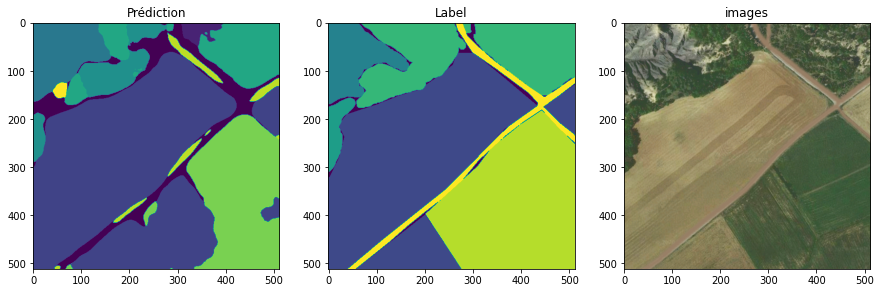

In [28]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
annotation = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [27]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
    label = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)
valid_imgs.shape,valid_labels.shape

((73, 512, 512, 3), (73, 512, 512, 3))

In [20]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [21]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [22]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

In [23]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [24]:
predictions = np.zeros(predictions.shape)

for idx_class in range(12):
    predictions[...,idx_class][label_pred == idx_class] = 1

IOU moyen et par classe

In [29]:
iou = []
for idx_classe in range(12):
    prediction = predictions[...,idx_classe]
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction)
    union = np.logical_or(target,prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.346652330561511, 0.6929472944292168, 0.8622813442417808, 0.8146090329635045, 0.5476718584027577, 0.7817355895431054, 0.5345335372560742, 0.6721135579893489, 0.6792246212503021, 0.584646538017302, 0.8536211005345146, 0.6112735735038319]
mIou:  0.6651091982244376


matrice de confusion par classe

In [42]:
conf_mat = np.zeros((12,12))

for idx_pred_class in range(12):
    for idx_target_class in range(12):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,predictions[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [50]:
classes = list(CLASSES)

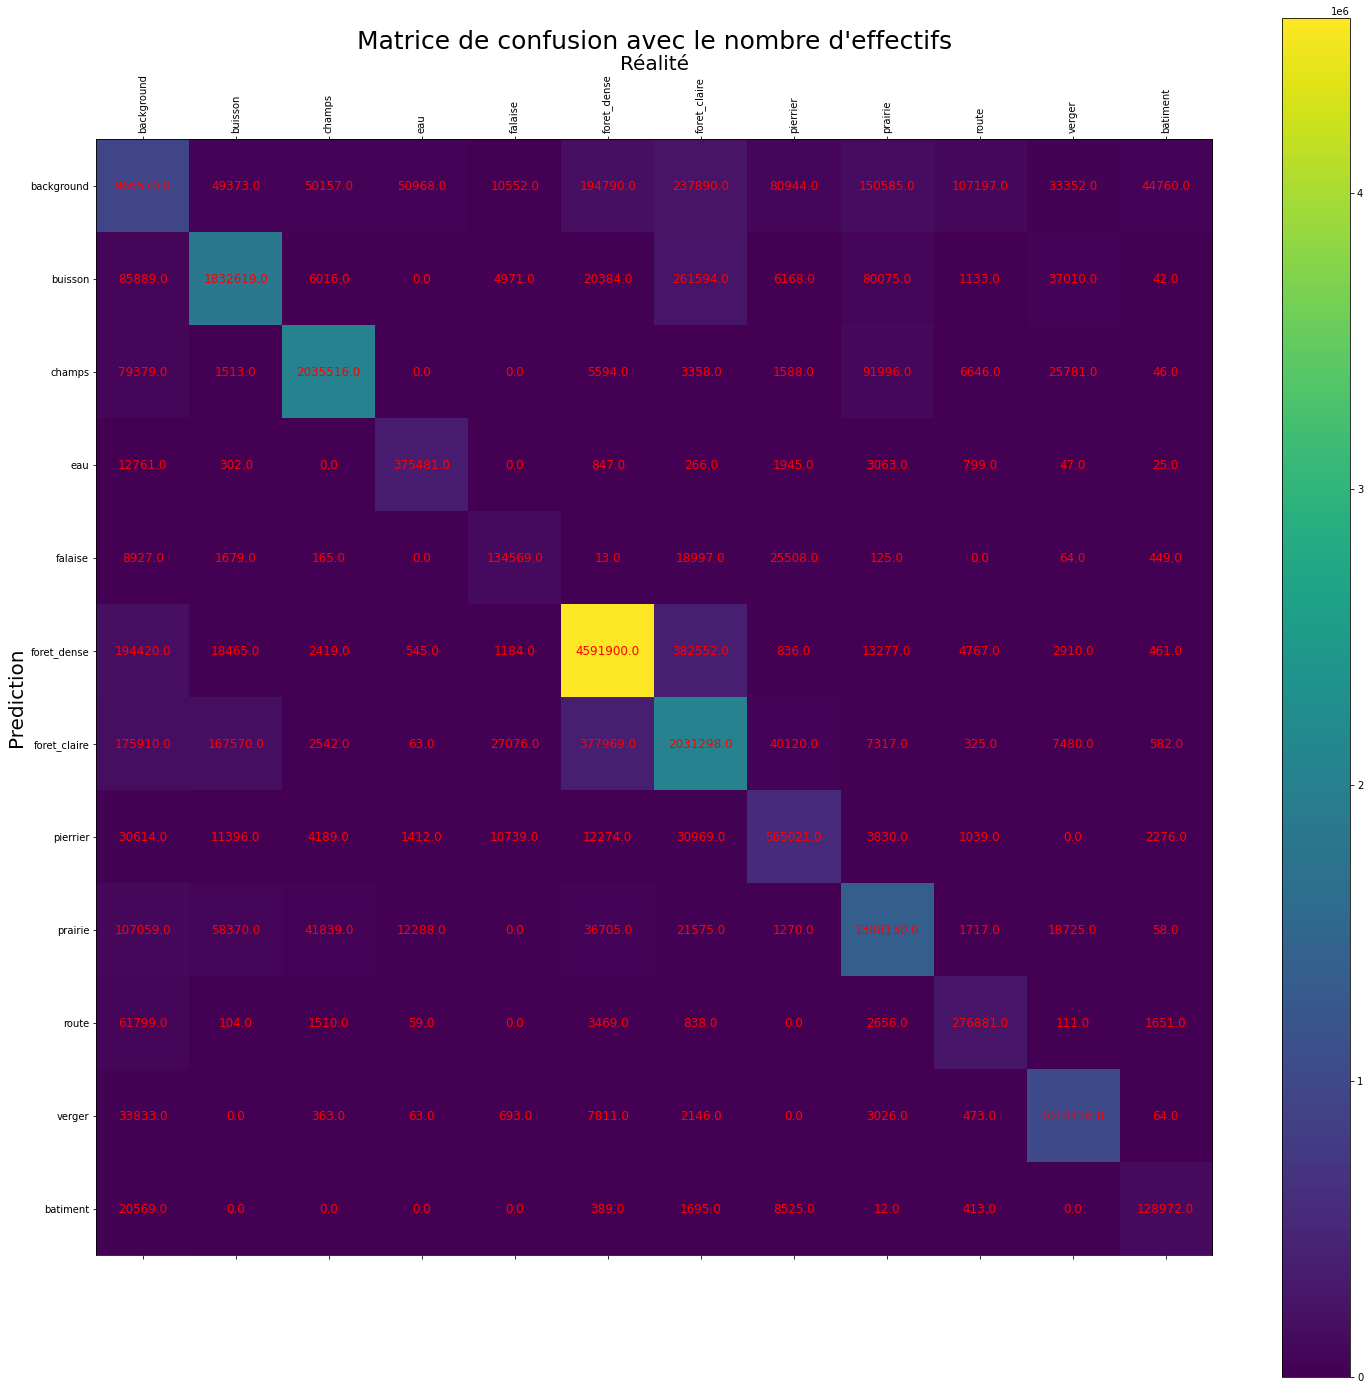

In [51]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()


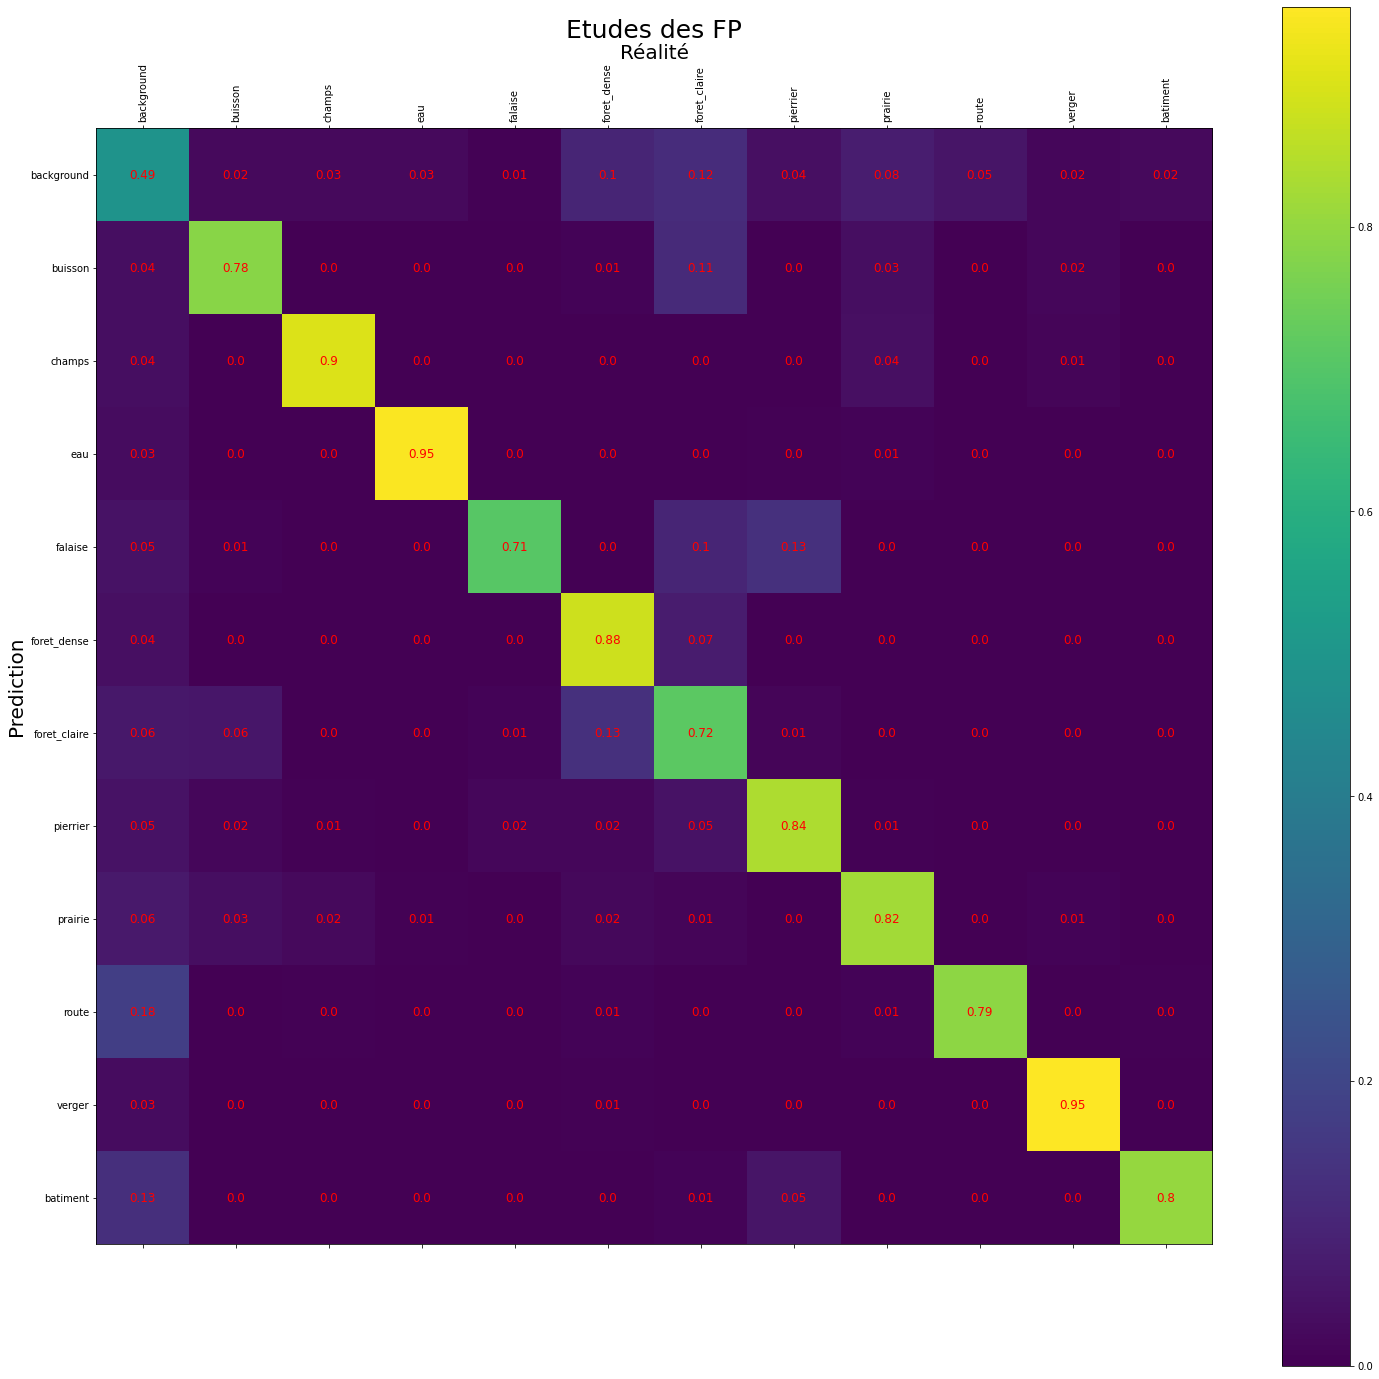

In [52]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

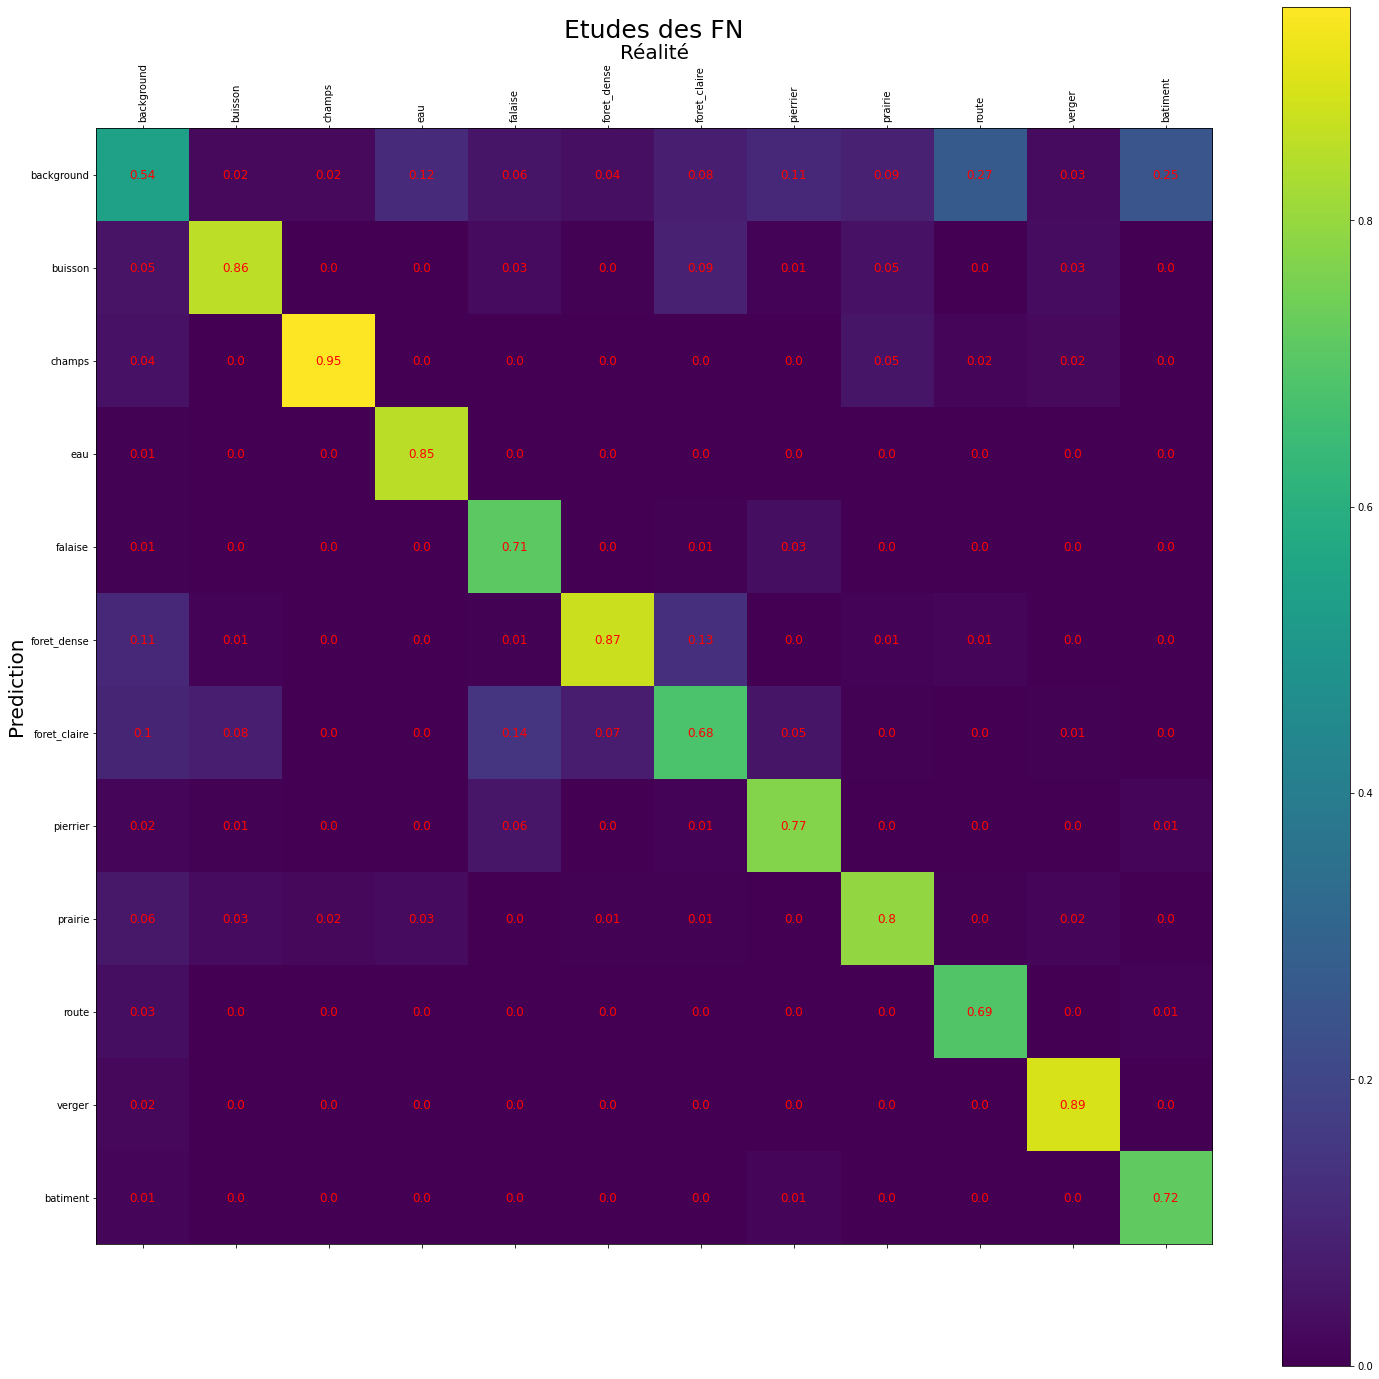

In [53]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()


In [54]:
dico = {}
for idx,classe in zip(range(12),classes):
    precision = conf_mat[idx,idx]/np.sum(conf_mat[idx,:])
    recall = conf_mat[idx,idx]/np.sum(conf_mat[:,idx])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classe] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'background': {'precision': 0.488873310815937,
  'recall': 0.5437102372126251,
  'f1': 0.5148356746495483},
 'buisson': {'precision': 0.7845448073355848,
  'recall': 0.855807743658211,
  'f1': 0.8186283137217764},
 'champs': {'precision': 0.904104392922324,
  'recall': 0.9490841677872501,
  'f1': 0.9260484157326451},
 'eau': {'precision': 0.9492966506209296,
  'recall': 0.8516645156607595,
  'f1': 0.8978342090947675},
 'falaise': {'precision': 0.7064137829665714,
  'recall': 0.7090639885343337,
  'f1': 0.7077364047543915},
 'foret_dense': {'precision': 0.880731206950256,
  'recall': 0.8742904089662414,
  'f1': 0.8774989893349637},
 'foret_claire': {'precision': 0.7156862745098039,
  'recall': 0.6786425665296217,
  'f1': 0.6966723428044236},
 'pierrier': {'precision': 0.8386099480674841,
  'recall': 0.7719657068688732,
  'f1': 0.8039089866570296},
 'prairie': {'precision': 0.8224805301303048,
  'recall': 0.7959041151498889,
  'f1': 0.8089741094250644},
 'route': {'precision': 0.7931780

In [55]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.7891502528295535
mean precision score is: 0.8034586185102549
mean recall score is: 0.7774018528683637


###  test sur jeu de synthese

#split train/val set randomly
data_root = "data/synthese2/"
split_dir = 'splits_synthese/'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  #select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  #select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
import re
valid_index = []
with open(osp.join(data_root, split_dir) + "val.txt", 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

In [ ]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
    label = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [ ]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
annotation = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [ ]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [ ]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

predictions = np.zeros(predictions.shape)

for idx_class in range(11):
    predictions[...,idx_class][label_pred == idx_class] = 1


In [ ]:
predictions.shape,valid_imgs.shape,valid_labels.shape

In [ ]:
classes_real = {0:"background",1:"buisson",2:"champs",3:"eau",
         4:"falaise",5:"foret_dense",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}


correspondance = {0:4,1:11,2:9,3:7,4:10,5:2,6:8,7:5,8:6,9:1,10:3,11:0}

In [ ]:
a = list(classes_syn.values())
a.append("background")

In [ ]:
iou = {}
for idx_classe in range(11):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,predictions[...,correspondance[idx_classe]])
    union = np.logical_or(target,predictions[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score

print(iou)  
print("mIou: ", np.mean(list(iou.values())))